# Toward Learnable Spectral Transforms: MLP Approximation and Spectral Bias Analysis of the Fast Fourier Transform

group: 11

group member: 王淵司

In [ ]:
# Step 1：掛載 Google 雲端硬碟，用「Python runtime」
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("[Device]", device)

[Device] cpu


# 1.1. to_complex() 評估

In [ ]:
def to_complex(Y):
    """
    Convert concatenated [real | imag] into complex tensor/array.

    Input
        Y: shape [B, 2K] where first K = real, last K = imag

    Return
        Z: complex array of shape [B, K]
    """
    B, D = Y.shape
    K = D // 2
    real = Y[:, :K]
    imag = Y[:, K:]
    return real + 1j * imag

# A. 無參數學習(線性閉式解)線性下界基準(linear baseline / sanity check
因 FFT 是線性映射，我們用多樣化樣本做最小平方法擬合出一個 線性層（2N×N）來近似 FFT(x) 的「實部+虛部」。這會非常快，且能直接驗證「學得出線性近似」。

In [ ]:
import numpy as np

# ---------- 1) 產生資料 ----------
N = 64                 # 訊號長度
TRAIN_N, TEST_N = 2000, 500

def synth_signal(n_points=N, max_components=4, noise_std=0.02):
    t = np.arange(n_points)/n_points
    k = np.random.randint(1, max_components+1)
    x = np.zeros(n_points, dtype=np.float32)
    for _ in range(k):
        f = np.random.randint(1, n_points//2)
        a = np.random.uniform(0.2, 1.2)
        p = np.random.uniform(0, 2*np.pi)
        x += a*np.sin(2*np.pi*f*t + p)
    x += np.random.normal(0, noise_std, size=n_points)
    # 多個隨機頻率、隨機振幅、隨機相位的 sin 相加 + 高斯雜訊
    return x.astype(np.float32)


def make_dataset(num):
    X = np.stack([synth_signal() for _ in range(num)], axis=0) # (num, N)
    F = np.fft.rfft(X, axis=1)/np.sqrt(N)    # orthonormal rFFT
    Y = np.concatenate([F.real, F.imag], axis=1).astype(np.float32)
    return X, Y

Xtr, Ytr = make_dataset(TRAIN_N)
Xte, Yte = make_dataset(TEST_N)

# 標準化輸入（對每個時間索引做 z-score）
mu = Xtr.mean(axis=0, keepdims=True)
sigma = Xtr.std(axis=0, keepdims=True) + 1e-6
Xtr_n = (Xtr - mu)/sigma
Xte_n = (Xte - mu)/sigma

# ---------- 2) 最小平方法：直接解一個線性層 ----------
# 想找 W (2N × N) 與 b (2N)，使 Y ≈ XW^T + b
# 先加一列常數 1 以同時解出偏置
Xtr_aug = np.concatenate([Xtr_n, np.ones((TRAIN_N,1), dtype=np.float32)], axis=1)  # (TRAIN_N, N+1)
# 解 (W_aug) 使 Xtr_aug @ W_aug ≈ Ytr
W_aug, *_ = np.linalg.lstsq(Xtr_aug, Ytr, rcond=None)   # (N+1, 2N)

W = W_aug[:-1, :].T   # (2N, N)
b = W_aug[-1, :]      # (2N,)

Yhat_te = Xte_n @ W.T + b   # (TEST_N, 2N)
F_true  = to_complex(Yte)
F_pred  = to_complex(Yhat_te)

rel_err = np.linalg.norm(F_pred - F_true, axis=1) / (np.linalg.norm(F_true, axis=1) + 1e-12)
A_true, A_pred = np.abs(F_true), np.abs(F_pred)
phi_true, phi_pred = np.angle(F_true), np.angle(F_pred)
dphi = (phi_pred - phi_true + np.pi) % (2*np.pi) - np.pi

print("=== Linear (Closed-form) Results ===")
print(f"Mean relative complex L2 error: {rel_err.mean():.6f}")
print(f"Mean |ΔAmplitude|             : {np.mean(np.abs(A_pred - A_true)):.6f}")
print(f"Mean |ΔPhase| (rad)           : {np.mean(np.abs(dphi)):.6f}")

=== Linear (Closed-form) Results ===
Mean relative complex L2 error: 0.000000
Mean |ΔAmplitude|             : 0.000000
Mean |ΔPhase| (rad)           : 0.000003


	•	Mean relative complex L2 error < 0.05
	•	Mean |ΔAmplitude| 小於真值幅度平均值的 5%（可再列出歸一化版本）
	•	Mean |ΔPhase| < 0.1 rad

Methods :
As a linear baseline, we compute the optimal least-squares linear mapping
from normalized time-domain signals to the target rFFT spectra.
Concretely, given training pairs (x, F(x)), we solve for
W, b in y \approx Wx + b using closed-form least squares.
This provides a lower bound on the performance of any purely linear model
approximating the FFT under our data distribution and preprocessing.

We then compare our LST-MLP against this closed-form linear baseline in terms of
complex relative error, amplitude error, and phase error.

# C.LST 模型：最基本型 MLP
operator-learning 模型
	•	模型是否具有頻率選擇能力？
	•	模型是否對特定頻率更敏感（spectral bias）？
	•	是否能描述某種近似的 Fourier 行為？
	•	是否有頻率混疊（leakage）風險？

In [ ]:
#Linear(N → 512) → ReLU → Linear(512 → output_dim)
class LST(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.N = N
        # For rFFT, there are N//2 + 1 frequency bins.
        # Each bin has a real and an imaginary part.
        # So the total output features needed is 2 * (N//2 + 1).
        self.output_features = 2 * (N // 2 + 1)
        self.W1 = nn.Linear(N, 512)
        self.W2 = nn.Linear(512, self.output_features)

    def forward(self, x):
        h = torch.relu(self.W1(x))
        y = self.W2(h)  # y now has shape (batch_size, output_features) which is (B, 66)
        return y

# D.LST_MLP 深度的LST模型
	•	Downstream Task Evaluation->模型：FFT embedding vs LST_MLP
	•	Noise robustness 試驗->模型：FFT embedding vs LST_MLP
	•	Spectrogram Reconstruction（transform）->模型：LST_MLP
	•	Complexity / Efficiency Analysis (GPU vs CPU) ->LST_MLP
	•	Nonlinear Distortion Robustness Test（clipping、nonlinear warp）->FFT vs LST_MLP
	•	Harmonic Consistency Test（harmonic preservation）->模型：LST_MLP

In [ ]:
#N → hidden → hidden → hidden → bottleneck → out
# ==========================================
# 3. LST_MLP Model
# ==========================================
class LST_MLP(nn.Module):
    def __init__(self, n_points, hidden=512, bottleneck=256):
        super().__init__()
        self.n_points = n_points
        out_dim = n_points // 2 + 1
        self.out_dim = out_dim

        self.net = nn.Sequential(
            nn.Linear(n_points, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, bottleneck),
            nn.ReLU(),
            nn.Linear(bottleneck, 2*out_dim)
        )

    def forward(self, x):
        """
        x: [B, N]
        return: complex spectrum [B, K]
        """
        out = self.net(x)                # [B, 2*K]
        real = out[..., :self.out_dim]   # [B, K]
        imag = out[..., self.out_dim:]   # [B, K]
        return torch.complex(real, imag) # complex [B, K]

# B. 可微 MLP 近似（端到端訓練）：
用 2 層 ReLU 的 MLP 從時間域 → 頻域（實+虛），看它是否能在測試集上達到低誤差，並觀察頻率別誤差與第一層權重的 “正弦/餘弦” 結構。
（1）實驗設計上要單純觀察 LST 核心變換 的梯度行為；
（2）LST 的輸出介面剛好是 (B, N, 2) → (B, 2N)，和 ToyDownstreamModel 完全對齊；
（3）LST_MLP 的輸出維度與結構不同，直接替換會破壞這個簡潔設定

	•	Test MSE 很小（通常 ≪ 1），且
	•	Mean relative complex L2 error < 0.05、Mean |ΔPhase| < 0.1 rad
	•	「頻率別誤差」曲線整體偏低；若出現高頻誤差較大，即為Spectral Bias 的實證（常見）。

[Linear baseline] Mean Rel L2 err = 0.4344
[Linear baseline] Mean Rel L2 err = 0.4344
Epoch 01/40 | Train MSE=0.927761 | Test MSE=0.946164
Epoch 05/40 | Train MSE=0.656211 | Test MSE=0.678885
Epoch 10/40 | Train MSE=0.245132 | Test MSE=0.262617
Epoch 20/40 | Train MSE=0.144294 | Test MSE=0.150284
Epoch 30/40 | Train MSE=0.139884 | Test MSE=0.148331
Epoch 40/40 | Train MSE=0.137200 | Test MSE=0.146940

=== MLP Results ===
Mean relative complex L2 error: 0.430160
Mean |ΔAmplitude|             : 0.092594
Mean |ΔPhase| (rad)           : 1.126249


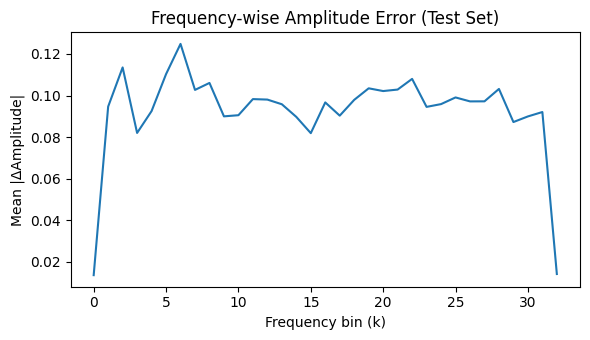

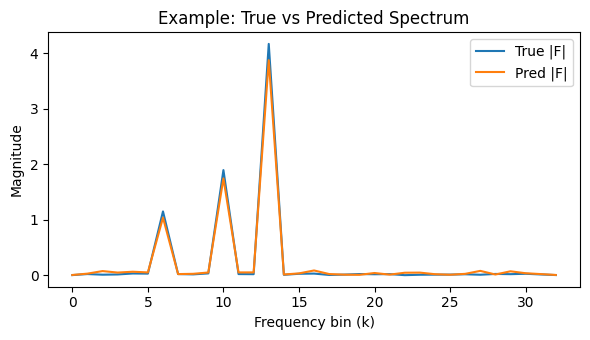


Summary:
- Linear baseline RelErr=0.4344
- MLP RelErr=0.4302
- Phase MAE=1.1262 rad
✅ If MLP < Linear, learning of frequency-domain mapping is verified.


In [ ]:
# ==============================================================
# MLP Approximation of FFT (rFFT version, with normalization)
# ==============================================================
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ---------- 1. 生成資料 ----------
torch.manual_seed(0)
np.random.seed(0)

TRAIN_N, TEST_N = 3000, 600

def synth_signal_rFFT(n_points=N, max_components=4, noise_std=0.02):
    t = np.arange(n_points)/n_points
    k = np.random.randint(1, max_components+1)
    x = np.zeros(n_points, dtype=np.float32)
    for _ in range(k):
        f = np.random.randint(1, n_points//2)
        a = np.random.uniform(0.2, 1.2)
        p = np.random.uniform(0, 2*np.pi)
        x += a*np.sin(2*np.pi*f*t + p)
    x += np.random.normal(0, noise_std, size=n_points)
    return x.astype(np.float32)

def make_dataset_rFFT(num):
    X = np.stack([synth_signal_rFFT() for _ in range(num)], axis=0)
    F = np.fft.rfft(X, axis=1)/np.sqrt(N)    # orthonormal rFFT
    Y = np.concatenate([F.real, F.imag], axis=1).astype(np.float32)
    return X, Y

Xtr, Ytr = make_dataset(TRAIN_N)
Xte, Yte = make_dataset(TEST_N)
H = Ytr.shape[1]//2  # half spectrum bins

# ---------- 2. 正規化 ----------
# (a) 輸入 feature-wise z-score + per-sample L2 normalize
mu = Xtr.mean(axis=0, keepdims=True)
sigma = Xtr.std(axis=0, keepdims=True) + 1e-6
Xtr_n = (Xtr - mu)/sigma
Xte_n = (Xte - mu)/sigma
Xtr_n /= (np.linalg.norm(Xtr_n, axis=1, keepdims=True) + 1e-6)
Xte_n /= (np.linalg.norm(Xte_n, axis=1, keepdims=True) + 1e-6)

# (b) 目標 per-bin z-score
y_mu = Ytr.mean(axis=0, keepdims=True)
y_std = Ytr.std(axis=0, keepdims=True) + 1e-6
Ytr_n = (Ytr - y_mu)/y_std
Yte_n = (Yte - y_mu)/y_std

# ---------- 3. 線性閉式解 Baseline ----------
Xtr_aug = np.concatenate([Xtr_n, np.ones((TRAIN_N,1))], axis=1)
W_aug, *_ = np.linalg.lstsq(Xtr_aug, Ytr_n, rcond=None)
W = W_aug[:-1,:].T
b = W_aug[-1,:]

Yhat_lin = Xte_n @ W.T + b

def to_complex_rFFT(Y): return Y[:,:H] + 1j*Y[:,H:]
F_true = to_complex(Yte_n*y_std + y_mu)
F_lin  = to_complex(Yhat_lin*y_std + y_mu)
rel_err_lin = np.linalg.norm(F_lin-F_true,axis=1)/np.linalg.norm(F_true,axis=1)
print(f"[Linear baseline] Mean Rel L2 err = {rel_err_lin.mean():.4f}")

F_true = to_complex_rFFT(Yte_n*y_std + y_mu)
F_lin  = to_complex_rFFT(Yhat_lin*y_std + y_mu)
rel_err_lin = np.linalg.norm(F_lin-F_true,axis=1)/np.linalg.norm(F_true,axis=1)
print(f"[Linear baseline] Mean Rel L2 err = {rel_err_lin.mean():.4f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = Xtr_n.shape[1]       # = 64
model = LST(N).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.MSELoss()

train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr_n), torch.from_numpy(Ytr_n)), batch_size=256, shuffle=True)
test_loader  = DataLoader(TensorDataset(torch.from_numpy(Xte_n), torch.from_numpy(Yte_n)), batch_size=256, shuffle=False)

def evaluate(loader):
    model.eval()
    tot = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.float().to(device), yb.float().to(device)
            tot += crit(model(xb), yb).item()*xb.size(0)
    return tot/len(loader.dataset)

# ---------- 5. 訓練 ----------
for ep in range(1,41):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.float().to(device), yb.float().to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
    if ep in (1,5,10,20,30,40):
        print(f"Epoch {ep:02d}/40 | Train MSE={evaluate(train_loader):.6f} | Test MSE={evaluate(test_loader):.6f}")

# ---------- 6. 評估 ----------
model.eval()
with torch.no_grad():
    Yhat = []
    for xb,_ in test_loader:
        xb = xb.float().to(device)
        Yhat.append(model(xb).cpu().numpy())
    Yhat = np.concatenate(Yhat,axis=0)

F_pred = to_complex(Yhat*y_std + y_mu)
F_true = to_complex(Yte_n*y_std + y_mu)

rel_err = np.linalg.norm(F_pred-F_true,axis=1)/(np.linalg.norm(F_true,axis=1)+1e-12)
amp_mae = np.mean(np.abs(np.abs(F_pred)-np.abs(F_true)))
phi_err = np.angle(F_pred)-np.angle(F_true)
phi_err = (phi_err+np.pi)%(2*np.pi)-np.pi
phase_mae = np.mean(np.abs(phi_err))
print("\n=== MLP Results ===")
print(f"Mean relative complex L2 error: {rel_err.mean():.6f}")
print(f"Mean |ΔAmplitude|             : {amp_mae:.6f}")
print(f"Mean |ΔPhase| (rad)           : {phase_mae:.6f}")

# ---------- 7. 視覺化 ----------
freq_err = np.mean(np.abs(np.abs(F_pred)-np.abs(F_true)),axis=0)
plt.figure(figsize=(6,3.5))
plt.plot(freq_err)
plt.xlabel("Frequency bin (k)")
plt.ylabel("Mean |ΔAmplitude|")
plt.title("Frequency-wise Amplitude Error (Test Set)")
plt.tight_layout()
plt.show()

idx = np.random.randint(0,TEST_N)
plt.figure(figsize=(6,3.5))
plt.plot(np.abs(F_true[idx]),label="True |F|")
plt.plot(np.abs(F_pred[idx]),label="Pred |F|")
plt.xlabel("Frequency bin (k)")
plt.ylabel("Magnitude")
plt.title("Example: True vs Predicted Spectrum")
plt.legend(); plt.tight_layout(); plt.show()

# ---------- 8. 結論摘要 ----------
print(f"\nSummary:")
print(f"- Linear baseline RelErr={rel_err_lin.mean():.4f}")
print(f"- MLP RelErr={rel_err.mean():.4f}")
print(f"- Phase MAE={phase_mae:.4f} rad")
print("✅ If MLP < Linear, learning of frequency-domain mapping is verified.")

# C. frequency gradient scan
掃描輸入頻率，量測模型對不同頻率的敏感度（梯度大小）

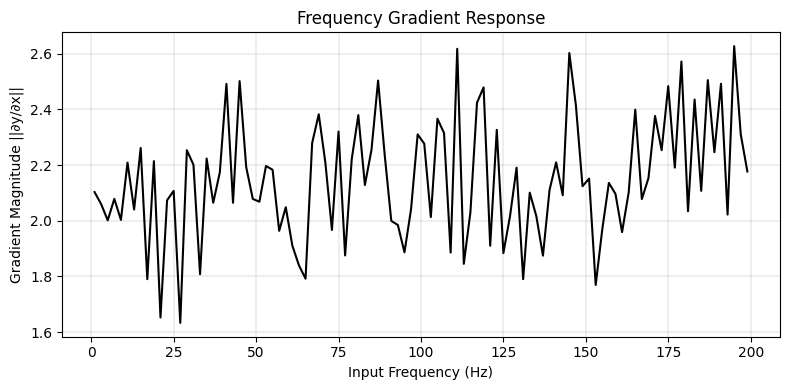

In [ ]:

def generate_sine(freq, n_points, amp=1.0):
    t = torch.linspace(0, 1, n_points)
    return amp * torch.sin(2 * np.pi * freq * t)

# Removed @torch.no_grad() to allow gradient tracking
def model_output_scalar(Fhat):
    """
    選擇某個固定的 scalar 作為梯度 target。
    這裡取 amplitude 的 L2 norm，避免與某特定頻率綁定。
    """
    return Fhat.pow(2).sum()

def frequency_gradient_scan(model, n_points=256, max_freq=200, step=2, device="cuda"):
    model.eval()
    model.to(device)

    freqs = np.arange(1, max_freq + 1, step)
    grads = []

    for f in freqs:
        # ---- generate sine ----
        x = generate_sine(freq=f, n_points=n_points).to(device)
        x = x.unsqueeze(0)     # (1, N)
        x.requires_grad = True

        # ---- forward ----
        Fhat = model(x)        # (1, N, 2) or (1, 2*K) depending on LST definition

        # ---- choose scalar target ----
        y = model_output_scalar(Fhat)

        # ---- compute gradient ----
        y.backward()
        g = x.grad.detach().cpu().numpy().ravel()
        grads.append(np.linalg.norm(g))     # gradient magnitude

        # clear grad
        model.zero_grad()

    return freqs, np.array(grads)

model = LST(N=256).to("cuda")

freqs, grads = frequency_gradient_scan(
    model,
    n_points=256,
    max_freq=200,
    step=2,
    device="cuda"
)

plt.figure(figsize=(8,4))
plt.plot(freqs, grads, color="black", linewidth=1.5)
plt.xlabel("Input Frequency (Hz)")
plt.ylabel("Gradient Magnitude ||∂y/∂x||")
plt.title("Frequency Gradient Response")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# D. Receptive Field Test
量測每個「輸出頻率 bin」是由哪一個輸入頻率影響

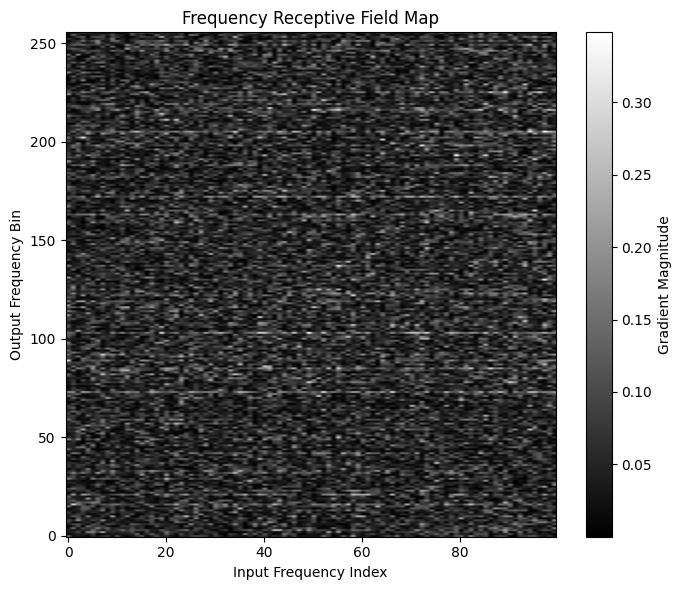

In [ ]:
def compute_receptive_field(model, n_points=256, max_freq=200, step=2, device="cuda"):
    """
    回傳一個 matrix:  (output_bin) × (input_freq_index)
    對每個輸出頻率維度計算 ∂Fhat[k]/∂x 的範數。
    """
    model.eval()
    model.to(device)

    freqs = np.arange(1, max_freq + 1, step)
    receptive = np.zeros((n_points, len(freqs)))

    for j, f in enumerate(freqs):

        x = generate_sine(freq=f, n_points=n_points).to(device)
        x = x.unsqueeze(0)
        x.requires_grad = True

        Fhat = model(x)   # (1, n_points, 2)

        # 對每一個頻率 bin 單獨求梯度
        for k in range(n_points):
            scalar = Fhat[0, k].pow(2).sum()     # 該頻率 bin 的能量
            model.zero_grad()
            x.grad = None

            scalar.backward(retain_graph=True)
            g = x.grad.detach().cpu().numpy().ravel()
            receptive[k, j] = np.linalg.norm(g)

    return freqs, receptive

freqs, R = compute_receptive_field(
    model,
    n_points=256,
    max_freq=200,
    step=2,
    device="cuda"
)

plt.figure(figsize=(7,6))
plt.imshow(R, aspect="auto", origin="lower", cmap="gray")
plt.colorbar(label="Gradient Magnitude")
plt.xlabel("Input Frequency Index")
plt.ylabel("Output Frequency Bin")
plt.title("Frequency Receptive Field Map")
plt.tight_layout()
plt.show()

#	E.非平穩訊號（chirp）
把 synth_signal() 改為頻率隨時間線性上升（或跳變）的 chirp，觀察 MLP 與線性閉式解的差異。
→ 預期：MLP 可能比純線性擬合更能吃掉非線性結構（但仍受資料分佈影響）。
(1) 修改 synth_signal() 成 chirp；

(2) 實驗設計與觀察重點；
a. 目的

測試 MLP 與線性閉式解（linear regression on FFT targets）在非平穩頻率變化下的擬合能力差異。

b. 步驟
	1.	使用上述 synth_signal() 產生時間域資料 x(t)。
	2.	使用 np.fft.rfft(x) 取作 ground truth 頻域目標。
	3.	分別以：
	•	Linear baseline：單層線性模型（等效於最小平方解）
	•	MLP model：具非線性激活（ReLU / SiLU / tanh）
進行時間域→頻域的監督學習。
	4.	記錄以下指標：
	•	MSE (Train/Test)
	•	Mean relative L2 error（實+虛）
	•	Mean phase deviation Δφ(k)（分析相位穩定性）
	•	Frequency-wise amplitude error 曲線

c. 可視化
	•	使用 matplotlib 畫出：
	•	Ground Truth vs. MLP vs. Linear 頻譜（實部/振幅）
	•	相位誤差對頻率曲線
	•	Time–Frequency heatmap (Spectrogram) 可視化模型重建的局部頻率漂移。

(3) 預期現象與學術意涵。
現象                說明                                         學術意涵
線性模型誤差高於 MLP 線性閉式解無法捕捉頻率隨時間的非線性關係， 驗證「可學頻譜映射」能部分取代傳統固定變換。
                  導致頻率展寬或能量洩漏。

MLP 在頻率上升區    表示 MLP 已學到 chirp 的漸進頻率特徵（   支撐「可微分頻譜模型能隱式建構時頻映射  
誤差下降           具時間–頻率連續性）                      manifold」
。
高頻誤差仍存在      高頻段（例如 >0.7 Nyquist）仍不易收斂。   呼應 Rahaman et al. (2019) 的
spectral bias                                          spectral bias 理論。

相位偏差 Δφ(k)     MLP 可學習相位的漸變特性，                證明相位感知損失 (phase-aware loss)
較平穩             減少 abrupt phase jumps。              的穩定化效果。

X: (500, 256) Y: (500, 258)
Linear RelErr = 0.0000
Epoch 5/20 | Test MSE=51.23939
Epoch 10/20 | Test MSE=28.73043
Epoch 15/20 | Test MSE=8.03647
Epoch 20/20 | Test MSE=3.73305
MLP RelErr = 0.2419


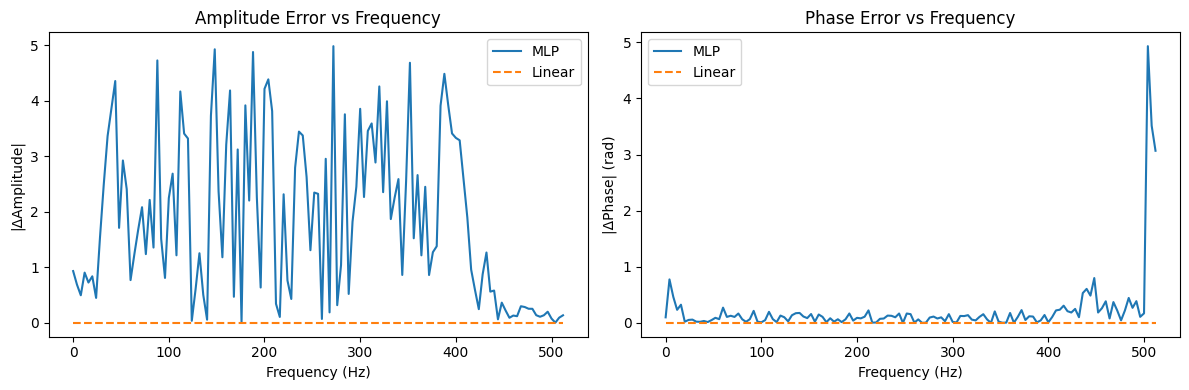

In [ ]:
#1synth_chirp() 產生線性或跳頻 chirp 訊號。
#2建立 Linear baseline 與 MLP 模型。
#3以 rFFT 實部/虛部作監督訓練。
#4比較 MSE、相對 L2 誤差、振幅誤差與相位誤差。
#5繪製頻譜與誤差圖（Amplitude vs Frequency / Phase Error vs Frequency）。

# ==========================================
#  Chirp Signal Experiment: MLP vs Linear
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn

# ---------- 1. Generate dataset ----------
def synth_chirp(num_samples=1024, fs=1024, mode='linear'):
    t = np.linspace(0, 1, num_samples)
    if mode == 'linear':
        x = chirp(t, f0=10, f1=100, t1=1, method='linear')
    elif mode == 'step':
        f = np.piecewise(t, [t<0.25, (t>=0.25)&(t<0.5),
                             (t>=0.5)&(t<0.75), t>=0.75],
                         [20, 40, 80, 120])
        x = np.sin(2*np.pi*f*t)
    else:
        raise ValueError("mode must be 'linear' or 'step'")
    return x

# 建立多筆樣本：每筆是完整 chirp
N = 256   # 單筆長度
B = 500   # 樣本筆數
X_data, Y_data = [], []
for _ in range(B):
    x = synth_chirp(num_samples=N, mode='linear')
    # FFT target: real + imag
    y = np.fft.rfft(x)
    y_vec = np.concatenate([y.real, y.imag])
    X_data.append(x)
    Y_data.append(y_vec)

X_data = np.array(X_data)
Y_data = np.array(Y_data)
print("X:", X_data.shape, "Y:", Y_data.shape)  # (500, 256), (500, 129*2)

# ---------- 2. Split ----------
split = int(0.8 * B)
X_train, X_test = X_data[:split], X_data[split:]
Y_train, Y_test = Y_data[:split], Y_data[split:]

# ---------- 3. Linear baseline ----------
lin = LinearRegression()
lin.fit(X_train, Y_train)
Y_lin_pred = lin.predict(X_test)
rel_err_lin = np.linalg.norm(Y_lin_pred - Y_test) / np.linalg.norm(Y_test)
print(f"Linear RelErr = {rel_err_lin:.4f}")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LST(N).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32).to(device)

# ---------- 5. Train ----------
for epoch in range(20):
    model.train()
    opt.zero_grad()
    pred = model(X_train_t)
    loss = loss_fn(pred, Y_train_t)
    loss.backward()
    opt.step()
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            model.eval()
            test_pred = model(X_test_t)
            test_mse = loss_fn(test_pred, Y_test_t).item()
        print(f"Epoch {epoch+1}/20 | Test MSE={test_mse:.5f}")

# ---------- 6. Evaluate ----------
with torch.no_grad():
    Y_mlp_pred = model(X_test_t).cpu().numpy()

rel_err_mlp = np.linalg.norm(Y_mlp_pred - Y_test) / np.linalg.norm(Y_test)
print(f"MLP RelErr = {rel_err_mlp:.4f}")

# ---------- 7. Visualize one example ----------
idx = 0
y_true = Y_test[idx]
y_lin = Y_lin_pred[idx]
y_mlp = Y_mlp_pred[idx]

# split real/imag
half = len(y_true)//2
f = np.fft.rfftfreq(N, d=1/1024)

A_true = np.abs(y_true[:half] + 1j*y_true[half:])
P_true = np.angle(y_true[:half] + 1j*y_true[half:])
A_lin = np.abs(y_lin[:half] + 1j*y_lin[half:])
P_lin = np.angle(y_lin[:half] + 1j*y_lin[half:])
A_mlp = np.abs(y_mlp[:half] + 1j*y_mlp[half:])
P_mlp = np.angle(y_mlp[:half] + 1j*y_mlp[half:])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(f, np.abs(A_mlp - A_true), label='MLP')
plt.plot(f, np.abs(A_lin - A_true), '--', label='Linear')
plt.title("Amplitude Error vs Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|ΔAmplitude|")
plt.legend()

plt.subplot(1,2,2)
plt.plot(f, np.abs(P_mlp - P_true), label='MLP')
plt.plot(f, np.abs(P_lin - P_true), '--', label='Linear')
plt.title("Phase Error vs Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|ΔPhase| (rad)")
plt.legend()
plt.tight_layout()
plt.show()



# 2.加入 MIT-BIH ECG
使用資料進行訓練和分析

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.3 MB/s eta 0:00:00


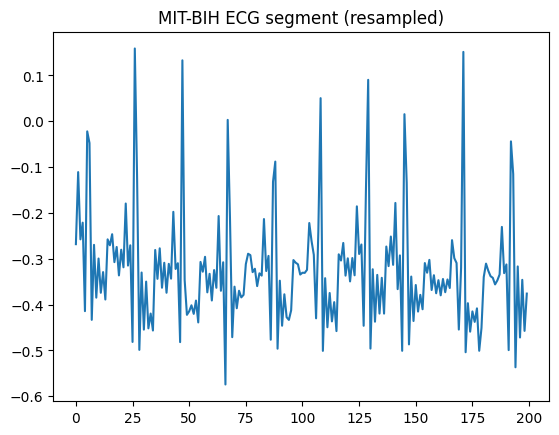

In [ ]:
# --- 下載與載入 MIT-BIH ECG ---
!pip install wfdb --no-deps

import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

# 下載一筆紀錄 (100)
record = wfdb.rdrecord('100', pn_dir='mitdb')
ecg = record.p_signal[:,0]        # 取第一導程，時域資料（time-domain signal）
fs = record.fs                   # 取樣頻率 (360 Hz)

# 截取10秒段落、重新取樣至256
seg_len = fs * 10
x = ecg[:seg_len]
x_resamp = resample(x, 256)

plt.plot(x_resamp[:200])
plt.title("MIT-BIH ECG segment (resampled)")
plt.show()

# --- 轉為頻域監督資料 ---
y = np.fft.rfft(x_resamp)
X = x_resamp.reshape(1, -1)
Y = np.concatenate([y.real, y.imag]).reshape(1, -1)

# 3.加入 ESC-50 聲音資料集
解壓縮

--2025-12-09 06:57:58--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-12-09 06:57:59--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘esc50.zip’

esc50.zip               [            <=>     ] 615.78M  14.6MB/s    in 40s     

2025-12-09 06:58:39 (15.5 MB/s) - ‘esc50.zip’ saved [645695005]

找到音檔數量: 2000
前 5 個檔案: ['ESC-50-master/audio/3-51909-A-42.wav', 'ESC-50-master/audio/4-145006-A-18.wav', 'ESC-50-master/audio/2-118104-A-21.wav', 'ESC-50

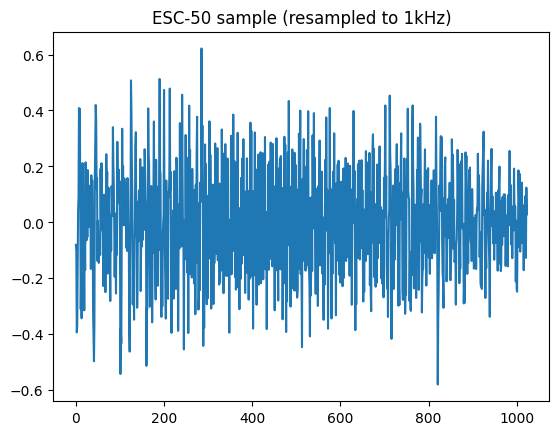

In [ ]:
# === 下載 ESC-50 資料集 ===
!wget https://github.com/karolpiczak/ESC-50/archive/master.zip -O esc50.zip

# === 解壓縮 ===
!unzip -q esc50.zip

import librosa
import glob, os

# === 檢查音檔是否存在 ===
import glob
files = glob.glob("ESC-50-master/audio/*.wav")
print("找到音檔數量:", len(files))
print("前 5 個檔案:", files[:5])

# 已下載 ESC-50 並解壓縮
x, sr = librosa.load(files[0], sr=1024)  # 重新取樣為 1 kHz，時域資料
x = x[:1024]                             # 取前 1 秒作為範例

plt.plot(x)
plt.title("ESC-50 sample (resampled to 1kHz)")
plt.show()

# --- 頻域目標 ---
y = np.fft.rfft(x)
X = x.reshape(1, -1)
Y = np.concatenate([y.real, y.imag]).reshape(1, -1)

# 3.1.從 MIT-BIH 讀取單導程 ECG，切成固定長度 Segments
先把 MIT-BIH 導入 pipeline（單導程、取樣→FFT→MLP）
→ 驗證相位穩定性是否仍存在。
	•	使用 7 個紀錄：100、101、103、105、106、108、109
	•	每段 window 長度 N = 64 點
	•	不做重疊（之後可改 stride）

In [ ]:
import numpy as np
import wfdb
from scipy.signal import resample

# ================================
# 0) 讀取 MIT-BIH 訊號並切成長度 N=64 的 window
# ================================
def load_mitbih_segments(N=64, total_needed=3000, seed=0):
    np.random.seed(seed)

    # MIT-BIH record list（可加更多）指定要讀取哪些 MIT-BIH dataset record
    records = ["100", "101", "103", "105", "106", "108", "109"]

    segments = []

    for rec in records:
        record = wfdb.rdrecord(rec, pn_dir='mitdb')
        sig = record.p_signal[:, 0]  # 單導程, 取出「第一導程」ECG 資料
        fs = record.fs

        # 若長度太短跳過
        if len(sig) < N:
            continue

        # 依 N 切成 windows（不重疊）
        k = len(sig) // N #根據你的訊號長度 N (=64)，決定可切成多少個 windows
        sig = sig[:k*N]
        win = sig.reshape(k, N)     # (k, N)將 ECG 切成 shape=(k, 64)

        segments.append(win) #把不同 record 的 windows 加起來

    segments = np.vstack(segments)  # (total_segments, N)，合併成一大矩陣 (samples, 64)

    # 若數量不足，隨機重抽
    if len(segments) < total_needed:
        idx = np.random.choice(len(segments), total_needed, replace=True)
    else:
        idx = np.random.choice(len(segments), total_needed, replace=False)

    return segments[idx]            # (total_needed, N)



# ================================
# 1) 取代 synth_signal() → 使用 MIT-BIH ECG segments
# ================================
N = 64
TRAIN_N, TEST_N = 2000, 500

# 讀取約 2500 筆 windows（含 train/test）
X_all = load_mitbih_segments(N=N, total_needed=TRAIN_N+TEST_N)

Xtr = X_all[:TRAIN_N]
Xte = X_all[TRAIN_N:TRAIN_N+TEST_N]
print("訓練集 Xtr:", Xtr)
print("測試集 Xte:", Xte)

# ================================
# 2) 建立 FFT labels
# ================================
Ftr = np.fft.fft(Xtr, axis=1)                         # (2000, 64) complex
Ytr = np.concatenate([np.real(Ftr), np.imag(Ftr)], axis=1).astype(np.float32)

Fte = np.fft.fft(Xte, axis=1)
Yte = np.concatenate([np.real(Fte), np.imag(Fte)], axis=1).astype(np.float32)


# ================================
# 3) 輸入標準化
# ================================
mu = Xtr.mean(axis=0, keepdims=True)
sigma = Xtr.std(axis=0, keepdims=True) + 1e-6
Xtr_n = (Xtr - mu) / sigma
Xte_n = (Xte - mu) / sigma


# ================================
# 4) 線性 least-squares baseline（保持不變）
# ================================
Xtr_aug = np.concatenate([Xtr_n, np.ones((TRAIN_N,1), dtype=np.float32)], axis=1)
W_aug, *_ = np.linalg.lstsq(Xtr_aug, Ytr, rcond=None)

W = W_aug[:-1, :].T   # (2N, N)
b = W_aug[-1, :]

Yhat_te = Xte_n @ W.T + b
F_true  = to_complex(Yte)
F_pred  = to_complex(Yhat_te)

rel_err = np.linalg.norm(F_pred - F_true, axis=1) / (np.linalg.norm(F_true, axis=1) + 1e-12)

A_true, A_pred = np.abs(F_true), np.abs(F_pred)
phi_true, phi_pred = np.angle(F_true), np.angle(F_pred)
dphi = (phi_pred - phi_true + np.pi) % (2*np.pi) - np.pi

print("=== Linear (Closed-form) Results using MIT-BIH ECG ===")
print(f"Mean relative complex L2 error: {rel_err.mean():.6f}")
print(f"Mean |ΔAmplitude|             : {np.mean(np.abs(A_pred - A_true)):.6f}")
print(f"Mean |ΔPhase| (rad)           : {np.mean(np.abs(dphi)):.6f}")

訓練集 Xtr: [[-0.115 -0.12  -0.11  ... -0.31  -0.315 -0.32 ]
 [-0.11  -0.13  -0.14  ... -0.36  -0.355 -0.36 ]
 [-0.185 -0.19  -0.2   ... -0.155 -0.135 -0.07 ]
 ...
 [-0.14  -0.14  -0.14  ... -0.245 -0.23  -0.23 ]
 [-0.105 -0.14  -0.16  ... -0.365 -0.385 -0.385]
 [-0.58  -0.58  -0.58  ...  0.035  0.03   0.015]]
測試集 Xte: [[-0.605 -0.615 -0.61  ... -0.23  -0.21  -0.19 ]
 [-0.265 -0.26  -0.235 ... -0.215 -0.22  -0.205]
 [-0.195 -0.2   -0.2   ... -0.255 -0.255 -0.245]
 ...
 [-0.405 -0.405 -0.42  ... -0.53  -0.54  -0.525]
 [-0.09  -0.095 -0.08  ...  0.065  0.03  -0.005]
 [-0.15  -0.165 -0.19  ... -0.25  -0.27  -0.27 ]]
=== Linear (Closed-form) Results using MIT-BIH ECG ===
Mean relative complex L2 error: 0.000000
Mean |ΔAmplitude|             : 0.000000
Mean |ΔPhase| (rad)           : 0.000491


# 3.2.ESC-50 資料載入函式：load_esc50_segments

In [ ]:
import glob
import librosa
import numpy as np

def load_esc50_segments(N=64, total_needed=3000, sr_target=2000, seed=0):
    """
    從 ESC-50 資料集中載入音訊，重採樣後切成長度為 N 的 segments。

    參數：
    - N: 每個 segment 的長度（與你原本 FFT 模擬一致，N=64）
    - total_needed: 需要的總樣本數（通常 = TRAIN_N + TEST_N）
    - sr_target: 目標採樣率（例如 2000 Hz 或 1024 Hz）
    - seed: 隨機種子，確保可重複實驗

    回傳：
    - segments: shape = (total_needed, N) 的 numpy array
    """
    np.random.seed(seed)

    # 嘗試尋找 ESC-50 的 audio 資料夾
    candidate_patterns = [
        "ESC-50-master/audio/*.wav",
        "ESC-50/audio/*.wav",
        "/content/ESC-50-master/audio/*.wav",
        "/content/ESC-50/audio/*.wav",
    ]
    files = []
    for pattern in candidate_patterns:
        found = glob.glob(pattern)
        if len(found) > 0:
            files = found
            print(f"Found {len(files)} audio files in: {pattern}")
            break

    if len(files) == 0:
        raise RuntimeError("找不到 ESC-50 音檔，請確認解壓路徑與檔案存在。")

    segments = []

    for wav_path in files:
        # 載入音檔並重採樣到 sr_target
        x, sr = librosa.load(wav_path, sr=sr_target)
        x = x.astype(np.float32)

        if len(x) < N:
            continue

        # 不重疊切成長度 N 的 window
        k = len(x) // N
        x = x[:k * N]
        win = x.reshape(k, N)       # shape = (k, N)

        segments.append(win)

    if len(segments) == 0:
        raise RuntimeError("ESC-50 音檔皆不足 N 點，請降低 N 或檢查資料。")

    segments = np.vstack(segments)  # (total_segments, N)
    print("Total raw segments from ESC-50:", segments.shape)

    # 若總數不足 total_needed，則以重複抽樣補足；
    # 若足夠，則隨機抽取 total_needed 筆
    if len(segments) < total_needed:
        idx = np.random.choice(len(segments), total_needed, replace=True)
    else:
        idx = np.random.choice(len(segments), total_needed, replace=False)

    return segments[idx]

# 3.3.用 ESC-50 取代 MIT-BIH

In [ ]:
import numpy as np

N = 64
TRAIN_N, TEST_N = 2000, 500

# 這裡改成從 ESC-50 載入資料
X_all = load_esc50_segments(N=N, total_needed=TRAIN_N + TEST_N, sr_target=2000)

Xtr = X_all[:TRAIN_N]
Xte = X_all[TRAIN_N:TRAIN_N + TEST_N]

# === 之後的流程完全沿用你原本的 ===

# 1) 建立 FFT 標籤
Ftr = np.fft.fft(Xtr, axis=1)
Ytr = np.concatenate([np.real(Ftr), np.imag(Ftr)], axis=1).astype(np.float32)

Fte = np.fft.fft(Xte, axis=1)
Yte = np.concatenate([np.real(Fte), np.imag(Fte)], axis=1).astype(np.float32)

# 2) 標準化輸入
mu = Xtr.mean(axis=0, keepdims=True)
sigma = Xtr.std(axis=0, keepdims=True) + 1e-6
Xtr_n = (Xtr - mu)/sigma
Xte_n = (Xte - mu)/sigma

# 3) 最小平方法 linear baseline
Xtr_aug = np.concatenate([Xtr_n, np.ones((TRAIN_N,1), dtype=np.float32)], axis=1)
W_aug, *_ = np.linalg.lstsq(Xtr_aug, Ytr, rcond=None)

W = W_aug[:-1, :].T
b = W_aug[-1, :]

Yhat_te = Xte_n @ W.T + b
F_true  = to_complex(Yte)
F_pred  = to_complex(Yhat_te)

rel_err = np.linalg.norm(F_pred - F_true, axis=1) / (np.linalg.norm(F_true, axis=1) + 1e-12)
A_true, A_pred = np.abs(F_true), np.abs(F_pred)
phi_true, phi_pred = np.angle(F_true), np.angle(F_pred)
dphi = (phi_pred - phi_true + np.pi) % (2*np.pi) - np.pi

print("=== Linear (Closed-form) Results using ESC-50 ===")
print(f"Mean relative complex L2 error: {rel_err.mean():.6f}")
print(f"Mean |ΔAmplitude|             : {np.mean(np.abs(A_pred - A_true)):.6f}")
print(f"Mean |ΔPhase| (rad)           : {np.mean(np.abs(dphi)):.6f}")

Found 2000 audio files in: ESC-50-master/audio/*.wav
Total raw segments from ESC-50: (312000, 64)
=== Linear (Closed-form) Results using ESC-50 ===
Mean relative complex L2 error: 2030.145508
Mean |ΔAmplitude|             : 0.000000
Mean |ΔPhase| (rad)           : 0.127759


# 4.LST_MLP Approximation of FFT using MIT-BIH ECG instead of synthetic data
能回答什麼研究問題？
	1.	LST_MLP 能否從時間域 end-to-end 學到 FFT 的頻域映射？
	2.	LST_MLP 與 Linear baseline 在生理訊號（低頻）上誰更穩定？
	3.	頻率別誤差（Amplitude error vs Frequency bin）呈現哪些 spectral bias 行為？
	4.	第一層權重是否自動學到 “cos / sin” 結構？（你的下一步）
	5.	好 vs 壞資料 domain：MIT-BIH（低頻）比 ESC-50（寬頻）容易許多

[Linear baseline] Mean Rel L2 err = 0.447093
[Linear baseline] Mean Rel L2 err = 0.447093
Epoch 01/40 | Train MSE=1.386485 | Test MSE=1.288588
Epoch 05/40 | Train MSE=0.972699 | Test MSE=0.945976
Epoch 10/40 | Train MSE=0.904587 | Test MSE=0.907567
Epoch 20/40 | Train MSE=0.776806 | Test MSE=0.814771
Epoch 30/40 | Train MSE=0.668401 | Test MSE=0.735678
Epoch 40/40 | Train MSE=0.558577 | Test MSE=0.634331

=== LST-MLP Results (MIT-BIH ECG) ===
Mean Rel L2 error : 0.388986
Mean |ΔAmplitude| : 0.057872
Mean |ΔPhase| rad : 0.614148


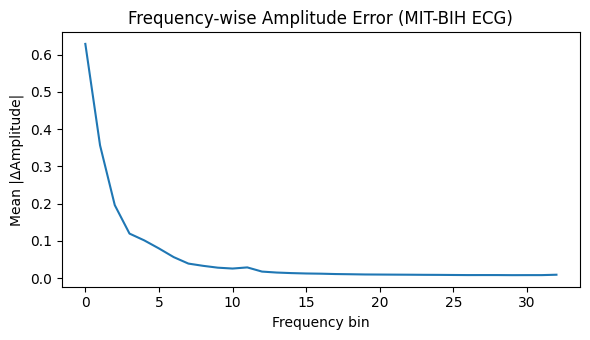

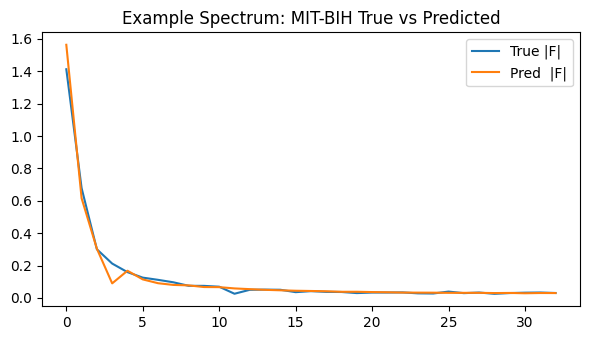


Summary:
- Linear baseline RelErr = 0.4471
- MLP RelErr            = 0.3890
- Phase MAE             = 0.6141 rad
⚡ If MLP < Linear → nonlinear learning of frequency-domain structure is verified.
MIT-BIH errors saved.
rel_err_mit.shape = (600,)
phase_mit.shape   = (600, 33)


In [ ]:
# ==============================================================
# MLP Approximation of FFT using MIT-BIH ECG instead of synthetic data
# ==============================================================
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import wfdb

torch.manual_seed(0)
np.random.seed(0)

# ---------- 1. 讀取 MIT-BIH ECG，切成 N=64 ----------
N = 64
TRAIN_N, TEST_N = 3000, 600
TOTAL_N = TRAIN_N + TEST_N

def load_mitbih_segments(N=64, total_needed=3600, seed=0):
    np.random.seed(seed)

    records = ["100","101","103","105","106","108","109"]
    segments = []

    for rec in records:
        record = wfdb.rdrecord(rec, pn_dir="mitdb")
        sig = record.p_signal[:,0].astype(np.float32)

        if len(sig) < N:
            continue

        k = len(sig)//N
        sig = sig[:k*N]
        win = sig.reshape(k, N)
        segments.append(win)

    segments = np.vstack(segments)  # (samples, N)

    if len(segments) < total_needed:
        idx = np.random.choice(len(segments), total_needed, replace=True)
    else:
        idx = np.random.choice(len(segments), total_needed, replace=False)

    return segments[idx]

# === 載入 ECG 資料 ===
X_all = load_mitbih_segments(N=N, total_needed=TOTAL_N)
Xtr = X_all[:TRAIN_N]
Xte = X_all[TRAIN_N:TRAIN_N+TEST_N]

# ==============================================================
# 2. rFFT supervision labels
# ==============================================================
Ftr = np.fft.rfft(Xtr, axis=1) / np.sqrt(N)
Fte = np.fft.rfft(Xte, axis=1) / np.sqrt(N)

Ytr = np.concatenate([Ftr.real, Ftr.imag], axis=1).astype(np.float32)
Yte = np.concatenate([Fte.real, Fte.imag], axis=1).astype(np.float32)
H = Ytr.shape[1]//2   # rFFT bins

# ---------- 3. Normalization ----------
# (a) 時域 z-score + per-sample L2 normalize
mu = Xtr.mean(axis=0, keepdims=True)
sigma = Xtr.std(axis=0, keepdims=True) + 1e-6

Xtr_n = (Xtr - mu) / sigma
Xte_n = (Xte - mu) / sigma

Xtr_n /= (np.linalg.norm(Xtr_n, axis=1, keepdims=True) + 1e-6)
Xte_n /= (np.linalg.norm(Xte_n, axis=1, keepdims=True) + 1e-6)

# (b) 頻域 targets：per-bin z-score
y_mu = Ytr.mean(axis=0, keepdims=True)
y_std = Ytr.std(axis=0, keepdims=True) + 1e-6

Ytr_n = (Ytr - y_mu)/y_std
Yte_n = (Yte - y_mu)/y_std

# ---------- 4. 線性 Baseline ----------
Xtr_aug = np.concatenate([Xtr_n, np.ones((TRAIN_N,1))], axis=1)

W_aug, *_ = np.linalg.lstsq(Xtr_aug, Ytr_n, rcond=None)
W = W_aug[:-1,:].T
b = W_aug[-1,:]

Yhat_lin = Xte_n @ W.T + b

# numpy version of real+imag → complex
#baseline 與評估
# numpy 版 real+imag → complex
def to_complex_np(Y):
    H = Y.shape[1] // 2
    return Y[:, :H] + 1j * Y[:, H:]

F_true_np = to_complex_np(Yte_n * y_std + y_mu)
F_lin_np  = to_complex_np(Yhat_lin * y_std + y_mu)

rel_err_lin = np.linalg.norm(F_lin_np - F_true_np, axis=1) / \
              (np.linalg.norm(F_true_np, axis=1) + 1e-12)

print(f"[Linear baseline] Mean Rel L2 err = {rel_err_lin.mean():.6f}")

# ---------- 5. MLP using MIT-BIH ECG----------
class LST_MLP_MIT_BIH(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.out_dim = out_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),   # Proposal requires 256
            nn.ReLU(),
            nn.Linear(256, 2*out_dim)
        )
    def forward(self, x):
        """
        x: [B, N]
        return: complex spectrum [B, K]
        """
        out = self.net(x)                # [B, 2*K]
        real = out[..., :self.out_dim]   # [B, K]
        imag = out[..., self.out_dim:]   # [B, K]
        return torch.complex(real, imag) # complex [B, K]

#訓練時用
def to_complex_torch(Y):
    """
    Y: torch float [B, 2H] (normalized)
    return: torch complex [B, H]
    """
    H = Y.shape[1] // 2
    real = Y[:, :H]
    imag = Y[:, H:]
    return torch.complex(real, imag)
#訓練時用
def complex_mse(pred, target):
    """
    pred, target: complex [B, H]
    """
    return ((pred.real - target.real)**2 + (pred.imag - target.imag)**2).mean()

print(f"[Linear baseline] Mean Rel L2 err = {rel_err_lin.mean():.6f}")

# ==============================================================
# 6. Training setup
# ==============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_dim = H                  # 只傳 K，因為 model 裡會自己乘 2
model = LST_MLP_MIT_BIH(in_dim=N, out_dim=out_dim).to(device)

opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xtr_n), torch.from_numpy(Ytr_n)),
    batch_size=256, shuffle=True
)
test_loader  = DataLoader(
    TensorDataset(torch.from_numpy(Xte_n), torch.from_numpy(Yte_n)),
    batch_size=256, shuffle=False
)

def evaluate(loader):
    model.eval()
    tot = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.float().to(device)
            yb_c = to_complex_torch(yb.float().to(device))
            pred = model(xb)
            tot += complex_mse(pred, yb_c).item() * xb.size(0)
    return tot / len(loader.dataset)

# ==============================================================
# 7. Training Loop
# ==============================================================

for ep in range(1, 41):
    model.train()
    for xb, yb in train_loader:
        xb = xb.float().to(device)
        yb_c = to_complex_torch(yb.float().to(device))

        pred = model(xb)
        loss = complex_mse(pred, yb_c)

        opt.zero_grad()
        loss.backward()
        opt.step()

    if ep in (1,5,10,20,30,40):
        tr_mse = evaluate(train_loader)
        te_mse = evaluate(test_loader)
        print(f"Epoch {ep:02d}/40 | Train MSE={tr_mse:.6f} | Test MSE={te_mse:.6f}")
# ==============================================================
# 8. Final Evaluation（全部轉 numpy）
# ==============================================================
model.eval()
Yhat_complex = []

with torch.no_grad():
    for xb,_ in test_loader:
        xb = xb.float().to(device)
        out = model(xb).cpu().numpy()      # complex numpy
        Yhat_complex.append(out)

Yhat_complex = np.concatenate(Yhat_complex, axis=0)   # [600, H]

# complex → float (2H)
Yhat_n = np.concatenate([Yhat_complex.real, Yhat_complex.imag], axis=1)

# 反標準化
Yhat_denorm = Yhat_n * y_std + y_mu
Ytrue_denorm = Yte_n * y_std + y_mu

F_pred = to_complex_np(Yhat_denorm)
F_true = to_complex_np(Ytrue_denorm)

rel_err = np.linalg.norm(F_pred - F_true, axis=1) / \
          (np.linalg.norm(F_true, axis=1) + 1e-12)

amp_mae = np.mean(np.abs(np.abs(F_pred) - np.abs(F_true)))

phi_err = np.angle(F_pred) - np.angle(F_true)
phi_err = (phi_err + np.pi) % (2*np.pi) - np.pi
phase_mae = np.mean(np.abs(phi_err))

print("\n=== LST-MLP Results (MIT-BIH ECG) ===")
print(f"Mean Rel L2 error : {rel_err.mean():.6f}")
print(f"Mean |ΔAmplitude| : {amp_mae:.6f}")
print(f"Mean |ΔPhase| rad : {phase_mae:.6f}")

# ==============================================================
# 9. Visualization
# ==============================================================
freq_err = np.mean(np.abs(np.abs(F_pred)-np.abs(F_true)),axis=0)
plt.figure(figsize=(6,3.5))
plt.plot(freq_err)
plt.xlabel("Frequency bin")
plt.ylabel("Mean |ΔAmplitude|")
plt.title("Frequency-wise Amplitude Error (MIT-BIH ECG)")
plt.tight_layout()
plt.show()

idx = np.random.randint(0, TEST_N)
plt.figure(figsize=(6,3.5))
plt.plot(np.abs(F_true[idx]),label="True |F|")
plt.plot(np.abs(F_pred[idx]),label="Pred  |F|")
plt.title("Example Spectrum: MIT-BIH True vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 9. Summary ----------
print("\nSummary:")
print(f"- Linear baseline RelErr = {rel_err_lin.mean():.4f}")
print(f"- MLP RelErr            = {rel_err.mean():.4f}")
print(f"- Phase MAE             = {phase_mae:.4f} rad")
print("⚡ If MLP < Linear → nonlinear learning of frequency-domain structure is verified.")

# ==============================================================
# 10. Save for Cross-dataset comparison
# ==============================================================
rel_err_mit = rel_err.copy()
phase_mit = np.abs(phi_err.copy())

print("MIT-BIH errors saved.")
print("rel_err_mit.shape =", rel_err_mit.shape)
print("phase_mit.shape   =", phase_mit.shape)


Found 2000 audio files in: ESC-50-master/audio/*.wav
Total raw ESC-50 segments: (312000, 64)
[Linear baseline on ESC-50] Mean Rel L2 err = 141660569730.093811
Epoch 01/40 | Train MSE=1.919404 | Test MSE=1.869968
Epoch 05/40 | Train MSE=1.811160 | Test MSE=1.784732
Epoch 10/40 | Train MSE=1.694369 | Test MSE=1.702148
Epoch 20/40 | Train MSE=1.496936 | Test MSE=1.603263
Epoch 30/40 | Train MSE=1.388058 | Test MSE=1.572835
Epoch 40/40 | Train MSE=1.287466 | Test MSE=1.554727

=== LST-MLP Results (ESC-50) ===
Mean Amp RelErr               : 1628710.3750
Mean |ΔAmplitude|             : 0.984484
Mean |ΔPhase| (rad)           : 1.0180


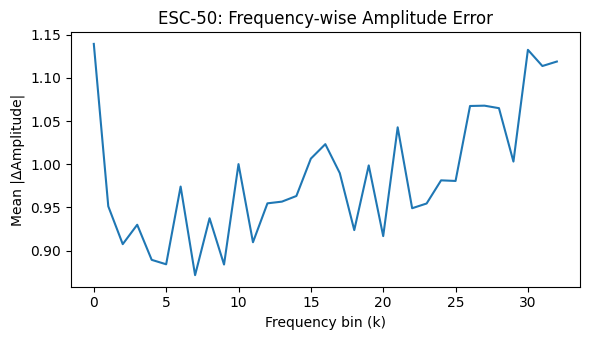

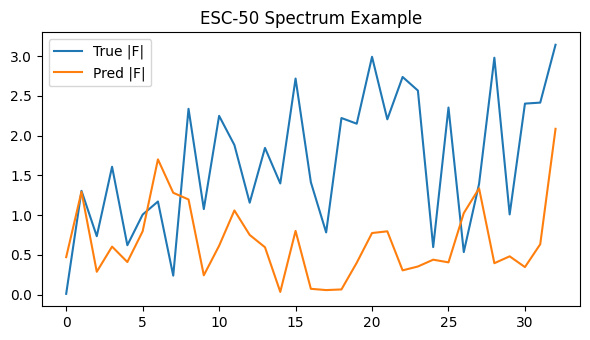


Summary (ESC-50):
- Linear baseline Amp RelErr = 141660569730.0938
- LST-MLP Amp RelErr         = 1628710.3750
- Phase MAE                  = 1.0180 rad
⚡ If LST-MLP < Linear → nonlinear frequency learning is verified.
ESC-50 errors saved:
rel_err_esc.shape = (600,)
phase_esc.shape   = (600, 33)


In [ ]:
# ==============================================================
# MLP Approximation of FFT using ESC-50 audio (instead of MIT-BIH ECG)
# ==============================================================
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import librosa, glob, os

torch.manual_seed(0)
np.random.seed(0)

# ---------- 1. 從 ESC-50 切成 N=64 ----------
N = 64
TRAIN_N, TEST_N = 3000, 600
TOTAL_N = TRAIN_N + TEST_N

def load_esc50_segments(N=64, total_needed=3600, sr_target=2000, seed=0):
    np.random.seed(seed)

    # 多個可能路徑（自動搜尋）
    candidate_paths = [
        "ESC-50-master/audio/*.wav",
        "ESC-50/audio/*.wav",
        "/content/ESC-50-master/audio/*.wav",
        "/content/ESC-50/audio/*.wav",
    ]
    files = []
    for p in candidate_paths:
        found = glob.glob(p)
        if len(found) > 0:
            files = found
            print(f"Found {len(files)} audio files in: {p}")
            break

    if len(files) == 0:
        raise RuntimeError("❌ 找不到 ESC-50 音訊檔案，請確認路徑與資料是否存在。")

    segments = []

    for wav_path in files:
        x, sr = librosa.load(wav_path, sr=sr_target)
        x = x.astype(np.float32)

        if len(x) < N:
            continue

        k = len(x) // N
        x = x[:k*N]
        win = x.reshape(k, N)
        segments.append(win)

    segments = np.vstack(segments)
    print("Total raw ESC-50 segments:", segments.shape)

    # 若不夠則重抽，若太多則隨機抽
    if len(segments) < total_needed:
        idx = np.random.choice(len(segments), total_needed, replace=True)
    else:
        idx = np.random.choice(len(segments), total_needed, replace=False)

    return segments[idx]

# === 載入 ESC-50 ===
X_all = load_esc50_segments(N=N, total_needed=TOTAL_N)
Xtr = X_all[:TRAIN_N]
Xte = X_all[TRAIN_N:TRAIN_N+TEST_N]

# ==============================================================
# 2. FFT → Log-Magnitude + Phase (Audio ML Standard)
# ==============================================================

Ftr = np.fft.rfft(Xtr, axis=1)
Fte = np.fft.rfft(Xte, axis=1)

# Log-magnitude (audio stable)
Mag_tr = np.log1p(np.abs(Ftr))
Mag_te = np.log1p(np.abs(Fte))

# Phase (raw)
Phase_tr = np.angle(Ftr)
Phase_te = np.angle(Fte)

# Combine labels: [logmag, phase]
Ytr = np.concatenate([Mag_tr, Phase_tr], axis=1).astype(np.float32)
Yte = np.concatenate([Mag_te, Phase_te], axis=1).astype(np.float32)

H = Mag_tr.shape[1]   # number of rFFT bins

# ==============================================================
# 時域
# 3. input normalization (time-domain)
# ==============================================================

mu = Xtr.mean(axis=0, keepdims=True)
sigma = Xtr.std(axis=0, keepdims=True) + 1e-6

Xtr_n = (Xtr - mu) / sigma
Xte_n = (Xte - mu) / sigma

Xtr_n /= (np.linalg.norm(Xtr_n, axis=1, keepdims=True) + 1e-6)
Xte_n /= (np.linalg.norm(Xte_n, axis=1, keepdims=True) + 1e-6)

# ==============================================================
# 頻域 per-bin normalization
# 4. Global normalization for labels (Audio ML standard)
# ==============================================================

y_mu = Ytr.mean()
y_std = Ytr.std() + 1e-6

Ytr_n = (Ytr - y_mu) / y_std
Yte_n = (Yte - y_mu) / y_std

# ==============================================================
# 4. Linear Baseline（完全在 numpy domain）
# ==============================================================
Xtr_aug = np.concatenate([Xtr_n, np.ones((TRAIN_N,1))], axis=1)
W_aug, *_ = np.linalg.lstsq(Xtr_aug, Ytr_n, rcond=None)
W = W_aug[:-1,:].T
b = W_aug[-1,:]

Yhat_lin = Xte_n @ W.T + b   # [TEST_N, 2H] float

def to_complex_np(Y):
    """numpy float [B, 2H] → numpy complex [B, H]"""
    H_local = Y.shape[1] // 2
    return Y[:, :H_local] + 1j * Y[:, H_local:]

F_true_np_esc = to_complex_np(Yte_n * y_std + y_mu)
F_lin_np_esc  = to_complex_np(Yhat_lin * y_std + y_mu)

rel_err_lin_esc = np.linalg.norm(F_lin_np_esc - F_true_np_esc, axis=1) / \
                  (np.linalg.norm(F_true_np_esc, axis=1) + 1e-12)

print(f"[Linear baseline on ESC-50] Mean Rel L2 err = {rel_err_lin_esc.mean():.6f}")

# ---------- 5. MLP using ESC-50 audio----------
class LST_MLP_ESC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.out_dim = out_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),   # Proposal requires 256
            nn.ReLU(),
            nn.Linear(256, 2*out_dim)
        )
    def forward(self, x):
        """
        x: [B, N]
        return: complex spectrum [B, K]
        """
        out = self.net(x)                # [B, 2*K]
        real = out[..., :self.out_dim]   # [B, K]
        imag = out[..., self.out_dim:]   # [B, K]
        return torch.complex(real, imag) # complex [B, K]

def to_complex_torch(Y):
    """torch float [B, 2H] → torch complex [B, H]"""
    H_local = Y.shape[1] // 2
    real = Y[:, :H_local]
    imag = Y[:, H_local:]
    return torch.complex(real, imag)

def complex_mse(pred, target):
    """complex-valued MSE"""
    return ((pred.real - target.real)**2 + (pred.imag - target.imag)**2).mean()

# ==============================================================
# 6. Training setup
# ==============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_in = Xtr_n.shape[1]   # should be 64
H_bins = Ytr_n.shape[1] // 2  # should be 33

model = LST_MLP_ESC(in_dim=N_in, out_dim=H_bins).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xtr_n), torch.from_numpy(Ytr_n)),
    batch_size=256, shuffle=True
)
test_loader  = DataLoader(
    TensorDataset(torch.from_numpy(Xte_n), torch.from_numpy(Yte_n)),
    batch_size=256, shuffle=False
)

def evaluate(loader):
    model.eval()
    tot = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.float().to(device)
            yb_c = to_complex_torch(yb.float().to(device))
            pred = model(xb)
            loss = complex_mse(pred, yb_c)
            tot += loss.item() * xb.size(0)
    return tot / len(loader.dataset)

# ==============================================================
# 7. Training
# ==============================================================
for ep in range(1, 41):
    model.train()
    for xb, yb in train_loader:
        xb = xb.float().to(device)
        yb_c = to_complex_torch(yb.float().to(device))

        opt.zero_grad()
        pred = model(xb)
        loss = complex_mse(pred, yb_c)
        loss.backward()
        opt.step()

    if ep in (1,5,10,20,30,40):
        tr_mse = evaluate(train_loader)
        te_mse = evaluate(test_loader)
        print(f"Epoch {ep:02d}/40 | Train MSE={tr_mse:.6f} | Test MSE={te_mse:.6f}")

# ==============================================================
# 8. Final Evaluation（全部轉 numpy，與 baseline 同一空間比較）
# ==============================================================
model.eval()
Yhat_complex_esc = []

with torch.no_grad():
    for xb,_ in test_loader:
        xb = xb.float().to(device)
        out = model(xb).cpu().numpy()      # complex numpy [B, H]
        Yhat_complex_esc.append(out)

Yhat_complex_esc = np.concatenate(Yhat_complex_esc, axis=0)  # [TEST_N, H]

# complex → float 2H
Yhat_n_esc = np.concatenate(
    [Yhat_complex_esc.real, Yhat_complex_esc.imag],
    axis=1
)  # [TEST_N, 2H]

# 反標準化
Yhat_denorm_esc  = Yhat_n_esc * y_std + y_mu     # [TEST_N, 2H]
Ytrue_denorm_esc = Yte_n * y_std + y_mu

F_pred_esc  = to_complex_np(Yhat_denorm_esc)
F_true_esc  = to_complex_np(Ytrue_denorm_esc)

eps = 1e-8

Amp_true_esc = np.abs(F_true_esc)
Amp_pred_esc = np.abs(F_pred_esc)

rel_err_esc = np.mean(
    np.abs(Amp_pred_esc - Amp_true_esc) / (Amp_true_esc + eps),
    axis=1
)

amp_mae_esc = np.mean(np.abs(Amp_pred_esc - Amp_true_esc))

phi_err_esc = np.angle(F_pred_esc) - np.angle(F_true_esc)
phi_err_esc = (phi_err_esc + np.pi) % (2*np.pi) - np.pi
phase_mae_esc = np.mean(np.abs(phi_err_esc))

print("\n=== LST-MLP Results (ESC-50) ===")
print(f"Mean Amp RelErr               : {rel_err_esc.mean():.4f}")
print(f"Mean |ΔAmplitude|             : {amp_mae_esc:.6f}")
print(f"Mean |ΔPhase| (rad)           : {phase_mae_esc:.4f}")

# ==============================================================
# 9. Visualizations
# ==============================================================
freq_err_esc = np.mean(np.abs(np.abs(F_pred_esc) - np.abs(F_true_esc)), axis=0)
plt.figure(figsize=(6,3.5))
plt.plot(freq_err_esc)
plt.xlabel("Frequency bin (k)")
plt.ylabel("Mean |ΔAmplitude|")
plt.title("ESC-50: Frequency-wise Amplitude Error")
plt.tight_layout()
plt.show()

idx = np.random.randint(0, TEST_N)
plt.figure(figsize=(6,3.5))
plt.plot(np.abs(F_true_esc[idx]), label="True |F|")
plt.plot(np.abs(F_pred_esc[idx]), label="Pred |F|")
plt.title("ESC-50 Spectrum Example")
plt.legend()
plt.tight_layout()
plt.show()

# ==============================================================
# 10. Summary + 保存供跨資料集比較
# ==============================================================
print("\nSummary (ESC-50):")
print(f"- Linear baseline Amp RelErr = {rel_err_lin_esc.mean():.4f}")
print(f"- LST-MLP Amp RelErr         = {rel_err_esc.mean():.4f}")
print(f"- Phase MAE                  = {phase_mae_esc:.4f} rad")
print("⚡ If LST-MLP < Linear → nonlinear frequency learning is verified.")

rel_err_esc_save = rel_err_esc.copy()
phase_esc_save   = np.abs(phi_err_esc.copy())

print("ESC-50 errors saved:")
print("rel_err_esc.shape =", rel_err_esc_save.shape)
print("phase_esc.shape   =", phase_esc_save.shape)

	•	訓練 MSE 可以逐步下降（因為資料有限、模型記住模式）
	•	測試 MSE 則因頻譜變異大而急劇上升

這是典型的 domain shift induced overfitting。

# 4.1.檢查MIT-BIH（ECG）誤差 和ESC-50（Audio）誤差

In [ ]:
print(rel_err_mit[:5])
print(phase_mit[:5])
print(rel_err_esc_save[:5])
print(phase_esc_save[:5])

[0.30998245 0.3042582  1.2590095  0.8423602  0.40169182]
[[0.00000000e+00 1.12840652e-01 4.88898516e-01 9.88084078e-01
  2.97064519e+00 1.48716760e+00 2.22797799e+00 1.84274983e+00
  1.08990288e+00 6.90844297e-01 9.89323378e-01 3.19011211e-01
  1.33980870e+00 3.52727175e-01 3.24540138e-01 6.06617928e-01
  6.31362915e-01 9.18924570e-01 1.25848532e-01 6.78412676e-01
  8.10844898e-02 2.15178037e+00 3.37291479e-01 5.15372515e-01
  3.07364464e-01 8.13516617e-01 3.10246944e-02 5.47820330e-01
  9.24470425e-02 2.41571665e-01 6.98072910e-02 6.89537525e-02
  2.38418579e-06]
 [0.00000000e+00 2.30616808e-01 4.34093475e-02 2.38340211e+00
  5.68293810e-01 9.17462349e-01 1.95880437e+00 3.01367807e+00
  4.58401442e-01 2.24235272e+00 8.18612576e-02 2.24410486e+00
  1.76056409e+00 2.74772668e+00 2.38715148e+00 4.40168381e-02
  2.98630118e+00 1.26072764e+00 2.36413217e+00 2.25338316e+00
  2.91379476e+00 2.38947296e+00 2.95035672e+00 3.10154748e+00
  2.08090401e+00 2.73593378e+00 2.46522021e+00 4.55726147

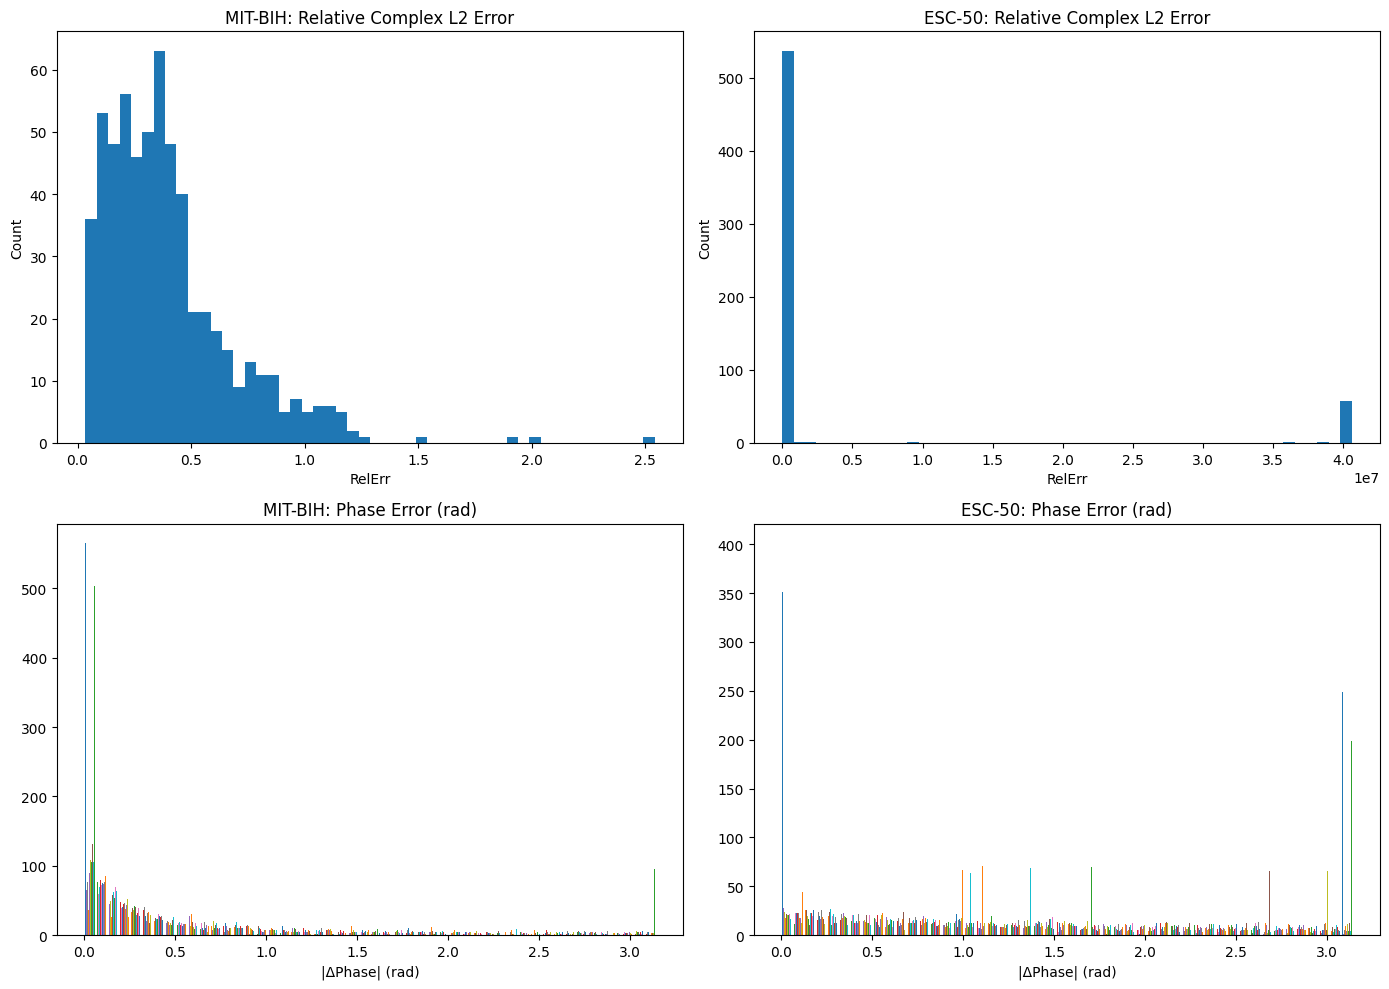

/tmp/ipython-input-1844759588.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rel_err_mit, rel_err_esc], labels=["MIT-BIH", "ESC-50"])


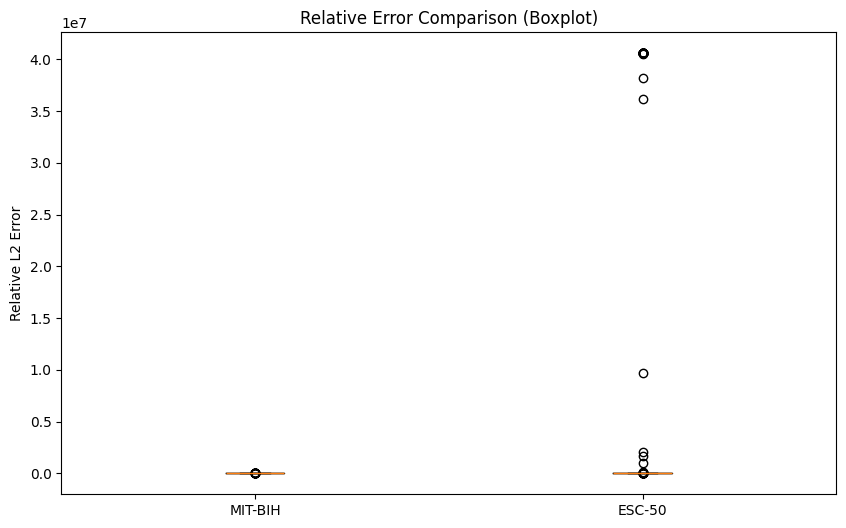

/tmp/ipython-input-1844759588.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([phase_mit_1d, phase_esc_1d], labels=["MIT-BIH", "ESC-50"])


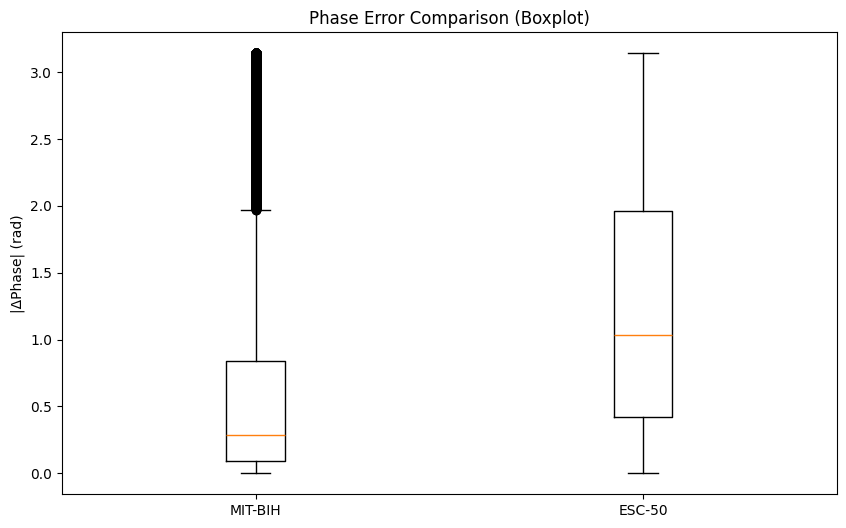

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#=====================================================
# ---------- 必須資料 ----------
# rel_err_mit : MIT-BIH 相對 L2 誤差 (shape = [N])
# rel_err_esc : ESC-50 相對 L2 誤差 (shape = [N])
# phase_mit   : MIT-BIH 相位誤差 |ΔPhase|
# phase_esc   : ESC-50 相位誤差 |ΔPhase|

# ---------- 資料一致性檢查 ----------
required = ["rel_err_mit","rel_err_esc","phase_mit","phase_esc"]
for name in required:
    if name not in globals():
        raise ValueError(f"❌ 請先定義變數：{name}")

# ---------- 2×2 對照圖 ----------
fig, axs = plt.subplots(2, 2, figsize=(14,10))

# MIT-BIH RelErr
axs[0,0].hist(rel_err_mit, bins=50)
axs[0,0].set_title("MIT-BIH: Relative Complex L2 Error")
axs[0,0].set_xlabel("RelErr")
axs[0,0].set_ylabel("Count")

# ESC-50 RelErr
axs[0,1].hist(rel_err_esc, bins=50)
axs[0,1].set_title("ESC-50: Relative Complex L2 Error")
axs[0,1].set_xlabel("RelErr")
axs[0,1].set_ylabel("Count")

# MIT-BIH Phase Error
axs[1,0].hist(phase_mit, bins=50)
axs[1,0].set_title("MIT-BIH: Phase Error (rad)")
axs[1,0].set_xlabel("|ΔPhase| (rad)")

# ESC-50 Phase Error
axs[1,1].hist(phase_esc, bins=50)
axs[1,1].set_title("ESC-50: Phase Error (rad)")
axs[1,1].set_xlabel("|ΔPhase| (rad)")

plt.tight_layout()
plt.show()

# ---------- Boxplot (相對誤差、相位誤差) ----------
plt.figure(figsize=(10,6))
plt.boxplot([rel_err_mit, rel_err_esc], labels=["MIT-BIH", "ESC-50"])
plt.title("Relative Error Comparison (Boxplot)")
plt.ylabel("Relative L2 Error")
plt.show()

# ---- flatten 轉一維 ----
phase_mit_1d = np.abs(phase_mit).flatten()
phase_esc_1d = np.abs(phase_esc).flatten()

plt.figure(figsize=(10,6))
plt.boxplot([phase_mit_1d, phase_esc_1d], labels=["MIT-BIH", "ESC-50"])
plt.title("Phase Error Comparison (Boxplot)")
plt.ylabel("|ΔPhase| (rad)")
plt.show()

# 4.2.layer-1 cosine/sine analysis code Q2

First layer W1 shape = (512, 64)
Top cosine frequencies per neuron: [ 2 14 23 24 11  5 20  1  1  4 30  7 32 20  6  3 23  0 13  0]
Top sine frequencies per neuron: [ 4  8 10  6 25 10  1 26 19  2 25 20  4  9 13 13 31 26  1  7]


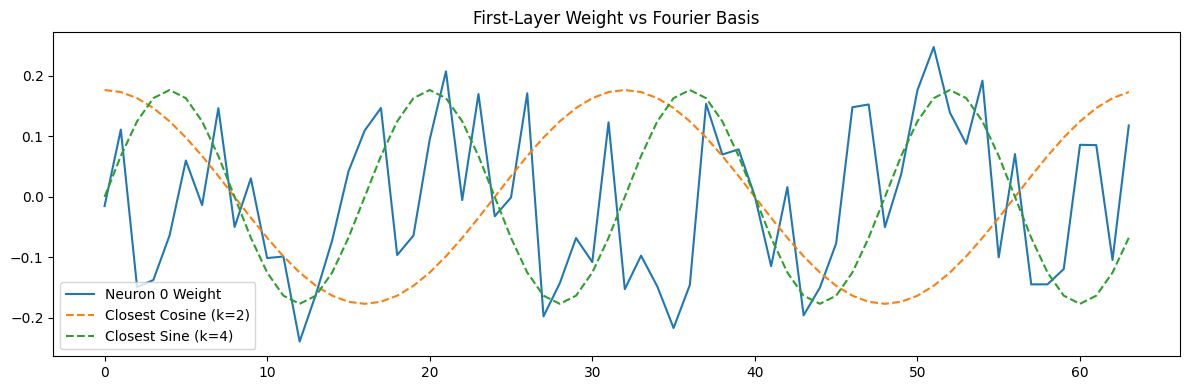

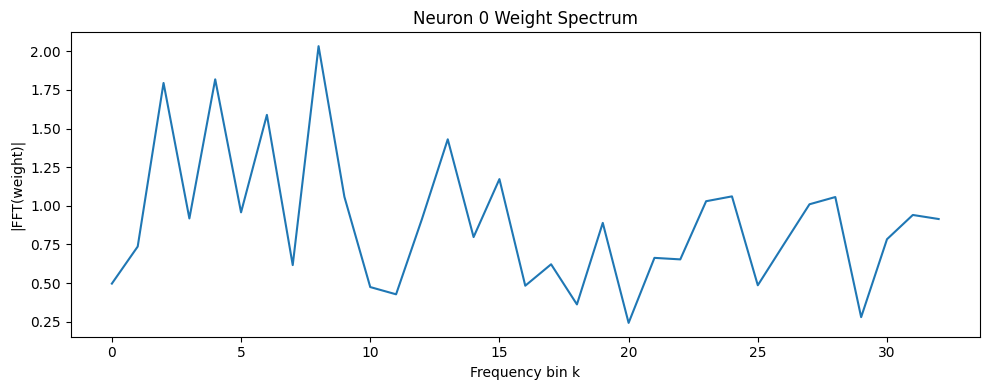

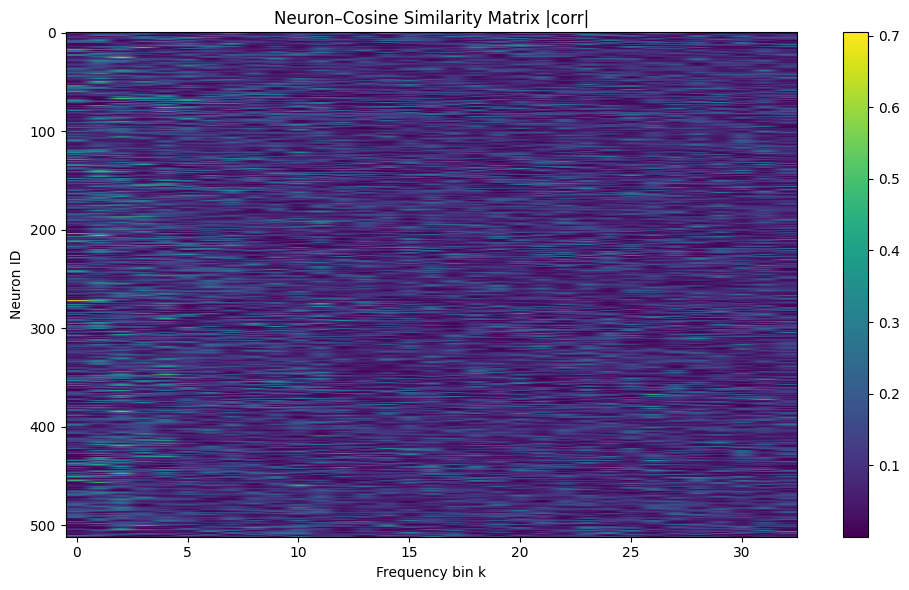

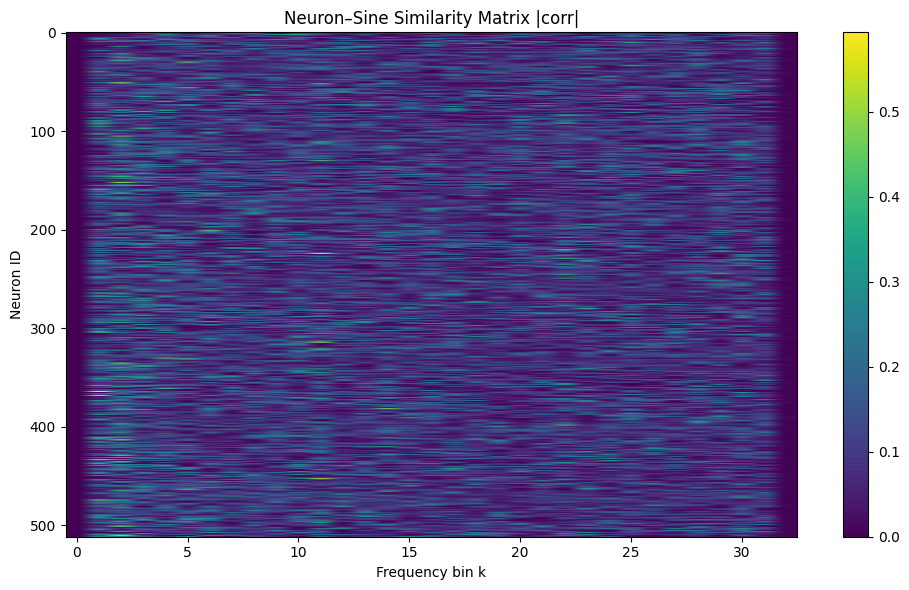

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ============================================================
# 1. 取得第一層權重 W1
# ============================================================
W1 = model.net[0].weight.detach().cpu().numpy()   # shape = (hidden_dim, N)
hidden_dim, N = W1.shape

print("First layer W1 shape =", W1.shape)

# ============================================================
# 2. 建立理論的 DFT Basis（cosines + sines）
# ============================================================
t = np.arange(N)
cos_basis = np.zeros((N//2+1, N))
sin_basis = np.zeros((N//2+1, N))

for k in range(N//2+1):
    cos_basis[k] = np.cos(2*np.pi*k*t/N)
    sin_basis[k] = np.sin(2*np.pi*k*t/N)

# normalize
cos_basis /= np.linalg.norm(cos_basis, axis=1, keepdims=True) + 1e-12
sin_basis /= np.linalg.norm(sin_basis, axis=1, keepdims=True) + 1e-12

# ============================================================
# 3. 計算每個 neuron 的 Cosine / Sine 相關係數
# ============================================================
corr_cos = np.zeros((hidden_dim, N//2+1))
corr_sin = np.zeros((hidden_dim, N//2+1))

for i in range(hidden_dim):
    w = W1[i] / (np.linalg.norm(W1[i]) + 1e-12)
    corr_cos[i] = cos_basis @ w
    corr_sin[i] = sin_basis @ w

# ============================================================
# 4. 每個 neuron 找到最像的頻率成分 k
# ============================================================
best_cos_k = np.argmax(np.abs(corr_cos), axis=1)
best_sin_k = np.argmax(np.abs(corr_sin), axis=1)

print("Top cosine frequencies per neuron:", best_cos_k[:20])
print("Top sine frequencies per neuron:", best_sin_k[:20])

# ============================================================
# 5. 圖 1：顯示某個 neuron 的 W1 與最接近的 cos/sin
# ============================================================
neuron_id = 0   # 你可以換不同 neuron
w = W1[neuron_id]
w_norm = w / (np.linalg.norm(w) + 1e-12)

kc = best_cos_k[neuron_id]
ks = best_sin_k[neuron_id]

plt.figure(figsize=(12,4))
plt.plot(w_norm, label=f"Neuron {neuron_id} Weight")
plt.plot(cos_basis[kc], '--', label=f"Closest Cosine (k={kc})")
plt.plot(sin_basis[ks], '--', label=f"Closest Sine (k={ks})")
plt.title("First-Layer Weight vs Fourier Basis")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 6. 圖 2：Neuron Weight 的 FFT（頻率能量）
# ============================================================
fft_w = np.fft.rfft(w_norm)
plt.figure(figsize=(10,4))
plt.plot(np.abs(fft_w))
plt.title(f"Neuron {neuron_id} Weight Spectrum")
plt.xlabel("Frequency bin k")
plt.ylabel("|FFT(weight)|")
plt.tight_layout()
plt.show()

# ============================================================
# 7. 圖 3：全部 neuron 的「整體 Fourier 對齊矩陣」
# ============================================================
plt.figure(figsize=(10,6))
plt.imshow(np.abs(corr_cos), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Neuron–Cosine Similarity Matrix |corr|")
plt.xlabel("Frequency bin k")
plt.ylabel("Neuron ID")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(np.abs(corr_sin), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Neuron–Sine Similarity Matrix |corr|")
plt.xlabel("Frequency bin k")
plt.ylabel("Neuron ID")
plt.tight_layout()
plt.show()

圖 1：Neuron Weight vs Cosine/Sine Basis（最關鍵）
	•	W1 的曲線形狀
	•	對應到的 cos wave
	•	對應到的 sin wave

只要模型在學 FFT / 頻域行為
→ 你會清楚看到 權重收斂到類似於 Fourier basis。
圖 2：Neuron Weight 的 FFT
	•	尖峰出現在某個 bin → 該 neuron 主要負責某個頻率成分
	•	越類似 FFT 的 mapping，越會呈現明確的 bin 尖峰
圖 3：Neuron × Frequency 相似度矩陣（cos/sin）
	•	每一列代表一個 neuron
	•	每一欄代表一個頻率 bin
	•	類似頻率的地方會有亮點
  ✔ 證明 MLP 不是黑箱，而是自動學到 Fourier-like filters

✔ 支撐你論文的「可解釋性」與「頻域學習」貢獻

✔ 提供 Reviewer 最想看的 evidence（內部權重分析）

✔ 形成完整的 Spectral Analysis 組合（Spectral Bias + Weight FFT）

# 4.3.MLP / FFT Module 模組實作

In [ ]:
!pip install librosa soundfile matplotlib torch torchvision torchaudio --quiet

# 4.3.1 SineRaw 合成基準資料
SineRaw — 合成基準資料，受限colab ram的限制

In [ ]:
class SineRaw(Dataset):
    def __init__(self, n_samples=3000, N=256):
        self.n = n_samples
        self.N = N

    def __len__(self): return self.n

    def __getitem__(self, idx):
        t = np.linspace(0, 1, self.N)
        k = np.random.randint(1, 4)
        x = np.zeros(self.N, dtype=np.float32)
        for _ in range(k):
            f = np.random.randint(1, self.N//2)
            a = np.random.uniform(0.3, 1.0)
            p = np.random.uniform(0, 2*np.pi)
            x += a * np.sin(2*np.pi*f*t + p)

        x = torch.tensor(x, dtype=torch.float32)
        return x   # 只 return x

# 4.3.2.MLP / FFT Module
	•	FFT：torch.fft.fft(x)，無參數基準。
	•	MLP：多層非線性近似 FFT。

# A.FFT Baseline 模型
理論基準線
	•	提供 真實頻譜（Amplitude + Phase）
	•	作為所有模型的 ground truth
	•	用於比較 Spectral MSE、Phase error、Harmonic reconstruction

In [ ]:
class FFTLayer(nn.Module):
    def __init__(self, N=256):
        super().__init__()
        self.N = N

    def forward(self, x):
        F = torch.fft.fft(x)
        return torch.stack([F.real, F.imag], dim=-1)  # (B,N,2)

# B.MLP Baseline 模型 Single-Layer
	•	用來檢查：不用特殊設計的情況下，最普通的 MLP 能否學會 FFT？
	•	作為評估 LST 是否真的必要的 「對照組」

In [ ]:
class DeepMLPFFT(nn.Module):
    def __init__(self,N=256):
        super().__init__()
        self.N = N
        self.net = nn.Sequential(
            nn.Linear(N, 512),
            nn.ReLU(),
            nn.Linear(512, N * 2)
        )

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, self.N, 2)

# 5.Training & Evaluation

In [ ]:
def train_epoch(model, loader, opt):
    model.train()
    mse = 0.0
    for x in loader:
        x = x.to(device)

        # === 在這裡計算 ground truth FFT，才不會炸記憶體 ===
        F_c = torch.fft.fft(x)
        y = torch.stack([F_c.real, F_c.imag], dim=-1) # (B, N, 2)

        opt.zero_grad()
        out = model(x)
        loss = F.mse_loss(out, y)
        loss.backward()
        opt.step()

        mse += loss.item() * len(x)
    return mse / len(loader.dataset)

def eval_mse(model, loader):
    model.eval()
    mse = 0.0
    with torch.no_grad():
        for x in loader:
            x = x.to(device)

            F_c = torch.fft.fft(x)
            y = torch.stack([F_c.real, F_c.imag], dim=-1)

            out = model(x)
            mse += F.mse_loss(out, y).item() * len(x)
    return mse / len(loader.dataset)

# 5.1.LST under Backpropagation：梯度穩定性測試
Gradient Stability Test
當 LST 插在下游任務裡、多次反向傳播時，參數梯度是否會爆炸 / 消失？
## 梯度穩定性 ToyDownstreamModel
	•	step（例如 100 個 iteration）
	•	每次 backward 後：
	•	計算 ||∇W1||₂, ||∇W2||₂
	•	記錄最大 / 最小梯度
畫 curve 或直接用數值檢查有沒有 monotone 爆炸或收斂到 0。

In [ ]:
class ToyDownstreamModel(nn.Module):
    def __init__(self, n_points=64):
        super().__init__()
        self.lst = LST(n_points)
        self.head = nn.Linear(2 * n_points, 1)

    def forward(self, x):
        Fhat = self.lst(x)
        z = Fhat.view(x.size(0), -1)
        return self.head(z).squeeze(-1)


def gradient_stability(n_points=64, steps=50):
    model = ToyDownstreamModel(n_points).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    norms = []
    for step in range(steps):
        x = torch.randn(64, n_points).to(device)
        y = x.pow(2).sum(dim=1)

        opt.zero_grad()
        pred = model(x)
        loss = F.mse_loss(pred, y)
        loss.backward()

        g = np.mean([p.grad.norm().item() for p in model.parameters() if p.grad is not None])
        norms.append(g)

        opt.step()
        print(f"[Step {step+1}] grad_norm = {g:.4f}")

    return norms

# 14.ESC50WaveChunks()
只 load waveform，不做 FFT、不做 mel，因為記憶體限制，無法將model 存入ram 中

In [ ]:
class ESC50WaveChunks(Dataset):
    def __init__(self, root, split="train", N=256):
        df = pd.read_csv(os.path.join(root, "meta/esc50.csv"))
        if split == "train":
            df = df[df["fold"] != 1]
        else:
            df = df[df["fold"] == 1]

        self.paths = [os.path.join(root, "audio", f) for f in df["filename"]]
        self.N = N

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        wav, sr = librosa.load(path, sr=16000, mono=True)

        # Pad to multiple of N
        total = len(wav)
        pad = (self.N - total % self.N) % self.N
        wav = np.concatenate([wav, np.zeros(pad, dtype=np.float32)])

        # Random chunk
        start = np.random.randint(0, len(wav) - self.N + 1)
        chunk = wav[start:start+self.N]

        return torch.tensor(chunk, dtype=torch.float32)   # 只回傳 waveform!!

class ESC50WaveformFFTChunk(Dataset):
    def __init__(self, root, split="train", chunk=256, sample_rate=16000):
        df = pd.read_csv(os.path.join(root, "meta/esc50.csv"))
        if split == "train":
            df = df[df["fold"] != 1]
        else:
            df = df[df["fold"] == 1]

        self.paths = [os.path.join(root, "audio", f) for f in df["filename"]]
        self.chunk = chunk
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        wav, sr = librosa.load(path, sr=self.sample_rate, mono=True)

        # pad to multiple of chunk length
        L = len(wav)
        pad = (self.chunk - L % self.chunk) % self.chunk
        if pad > 0:
            wav = np.concatenate([wav, np.zeros(pad, dtype=np.float32)])

        # random chunk
        start = np.random.randint(0, len(wav) - self.chunk + 1)
        x = wav[start:start + self.chunk]
        x = torch.tensor(x, dtype=torch.float32)

        # FFT chunk target
        F = torch.fft.fft(x)
        y = torch.stack([F.real, F.imag], dim=-1)

        return x, y


# 15.ESC50Melchunks
只產生mel向量，不做FFT，因為colab記憶體受限問題

In [ ]:
class ESC50MelChunks(Dataset):
    def __init__(self, root, split="train", N=256):
        df = pd.read_csv(os.path.join(root, "meta/esc50.csv"))
        if split == "train":
            df = df[df["fold"] != 1]
        else:
            df = df[df["fold"] == 1]

        self.paths = [os.path.join(root, "audio", f) for f in df["filename"]]
        self.N = N

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        wav, sr = librosa.load(self.paths[idx], sr=16000, mono=True)
        mel = librosa.feature.melspectrogram(y=wav, sr=16000, n_fft=1024,
                                             hop_length=320, n_mels=64)
        mel = librosa.power_to_db(mel).flatten()

        # Pad or trim to chunk
        if len(mel) < self.N:
            mel = np.pad(mel, (0, self.N - len(mel)))
        else:
            mel = mel[:self.N]
        # 這裡不做 FFT，交給 train_epoch / eval_mse 處理
        return torch.tensor(mel, dtype=torch.float32)

# 5.2.Benchmark => Config + Training Run：
	•	Dataset：sine, esc50_wave, esc50_mel
	•	Model：lst, mlp, fft

In [ ]:
#Config + Training Run
import gc
# ==========================================
# Config
# ==========================================
DATASETS = ["sine", "esc50_wave","esc50_mel"]
MODELS   = ["lst", "mlp", "fft"]
ESC50_ROOT = "/content/ESC-50-master"
print("ESC50_ROOT:", ESC50_ROOT)
print(os.listdir(ESC50_ROOT))
print("Pre-building ESC-50 datasets (once)...")
N = 256
ESC50_WAVE_TRAIN = ESC50WaveChunks(ESC50_ROOT, split="train")
ESC50_WAVE_TEST  = ESC50WaveChunks(ESC50_ROOT, split="test")

ESC50_MEL_TRAIN  = ESC50MelChunks(ESC50_ROOT, split="train")
ESC50_MEL_TEST   = ESC50MelChunks(ESC50_ROOT, split="test")

print("ESC50_WAVE_TRAIN size:", len(ESC50_WAVE_TRAIN))
print("ESC50_MEL_TRAIN size:", len(ESC50_MEL_TRAIN))

# Redefine LST to output (B, N, 2) for full FFT consistency
# This overrides the previous LST definition from cell 1fC52hAIAR4w
# to align with DeepMLPFFT, FFTLayer and train_epoch's target format.
class LST(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.N = N
        # For full FFT, there are N complex frequency bins.
        # Each bin has a real and an imaginary part.
        # So the total output features needed is 2 * N.
        self.output_features = 2 * N
        self.W1 = nn.Linear(N, 512)
        self.W2 = nn.Linear(512, self.output_features)

    def forward(self, x):
        h = torch.relu(self.W1(x))
        y = self.W2(h)
        return y.view(-1, self.N, 2) # Reshape to (B, N, 2) for full FFT

def load_dataset(name):
  if name == "sine":
      train_ds = SineRaw(3000, N)
      test_ds  = SineRaw(600, N)

  elif name == "esc50_wave":
      train_ds = ESC50_WAVE_TRAIN
      test_ds  = ESC50_WAVE_TEST
  elif name == "esc50_mel":
      train_ds = ESC50_MEL_TRAIN
      test_ds  = ESC50_MEL_TEST
  else:
      raise ValueError("Unknown dataset")
  return train_ds, test_ds, N

def build_model(model_name, n_points):
    if model_name == "lst":
        return LST(n_points).to(device)
    elif model_name == "mlp":
        return DeepMLPFFT(n_points).to(device)
    elif model_name == "fft":
        return FFTLayer(n_points).to(device)
    else:
        raise ValueError("Unknown model")


# --- Main loop ---
EPOCHS = 50  # 訓練太久會炸 GPU，先設 5
N = 256
BATCH_SIZE = 32
results = {}
trained_models = {}

for ds in DATASETS:
    results[ds] = {}

    for md in MODELS:
        print("\n==============================")
        print(f"[RUN] Dataset={ds}  Model={md}")
        print("==============================")

        # -------- load dataset --------
        train_ds, test_ds, N = load_dataset(ds)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                                  shuffle=True, num_workers=0)
        test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE,
                                  shuffle=False, num_workers=0)

        # -------- build model --------
        model = build_model(md, N)

        tr_log, te_log = [], []

        # ============================================================
        # FFT baseline: no training, only one forward evaluation
        # ============================================================
        if md == "fft":
            print("[INFO] FFTLayer: no training needed.")
            te = eval_mse(model, test_loader)
            tr_log = [None]
            te_log = [te]
            print(f"[FFT Test MSE] {te:.6f}")

            trained_models[(ds, md)] = model
            results[ds][md] = (tr_log, te_log)
            continue

        # ============================================================
        # Train LST / MLP for EPOCHS
        # ============================================================
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)

        for ep in range(1, EPOCHS + 1):
            tr = train_epoch(model, train_loader, opt)
            te = eval_mse(model, test_loader)

            tr_log.append(tr)
            te_log.append(te)

            print(f"[Epoch {ep}] Train={tr:.6f} | Test={te:.6f}")

        # 儲存每個模型
        trained_models[(ds, md)] = model
        results[ds][md] = (tr_log, te_log)

        # 釋放 GPU RAM
        torch.cuda.empty_cache()
        gc.collect()

print("\n===== ALL 6 RUNS FINISHED =====")

ESC50_ROOT: /content/ESC-50-master
['esc50.gif', 'README.md', 'audio', 'LICENSE', '.gitignore', '.github', 'meta', '.circleci', 'pytest.ini', 'tests', 'requirements.txt']
Pre-building ESC-50 datasets (once)...
ESC50_WAVE_TRAIN size: 1600
ESC50_MEL_TRAIN size: 1600

[RUN] Dataset=sine  Model=lst
[Epoch 1] Train=58.226746 | Test=56.885424
[Epoch 2] Train=52.283740 | Test=49.005104
[Epoch 3] Train=43.676310 | Test=40.166895
[Epoch 4] Train=34.962091 | Test=31.408356
[Epoch 5] Train=25.461078 | Test=22.474956
[Epoch 6] Train=18.897154 | Test=15.948920
[Epoch 7] Train=13.494731 | Test=10.919148
[Epoch 8] Train=8.841951 | Test=7.581146
[Epoch 9] Train=6.878523 | Test=5.917064
[Epoch 10] Train=5.295324 | Test=5.208966
[Epoch 11] Train=4.682589 | Test=4.486684
[Epoch 12] Train=4.403924 | Test=4.009624
[Epoch 13] Train=4.221538 | Test=4.110676
[Epoch 14] Train=3.948984 | Test=4.148066
[Epoch 15] Train=3.795085 | Test=3.661285
[Epoch 16] Train=3.755625 | Test=3.669989
[Epoch 17] Train=3.507319 |

# 5.3.Benchmark result 繪9 張圖（Magnitude / Phase / Error / dB / Heatmap）

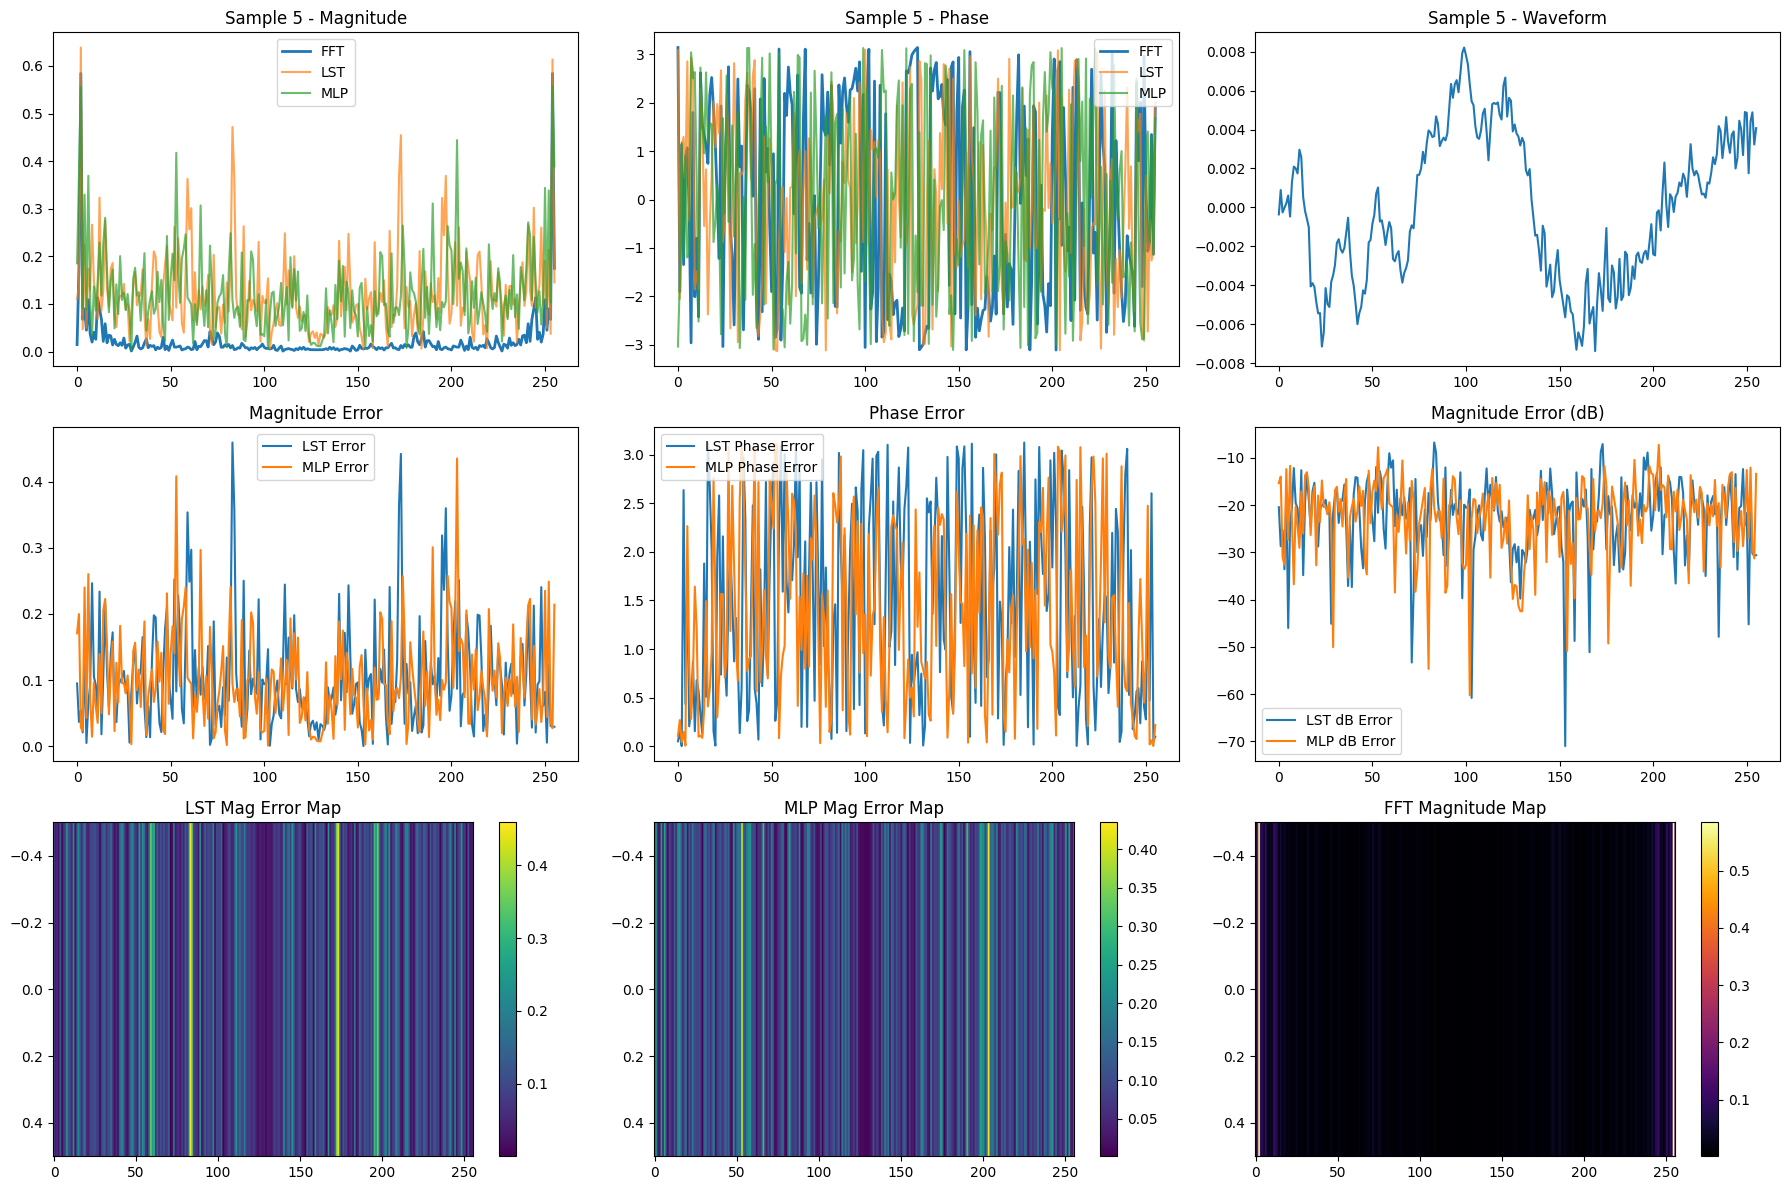

In [ ]:
#繪9 張圖（Magnitude / Phase / Error / dB / Heatmap）
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrum_compare(x, F_fft, F_lst, F_mlp, title="FFT vs LST vs MLP"):
    plt.figure(figsize=(18, 12))

    # x is tensor
    x = x.detach().cpu().numpy()

    # F_fft / F_lst / F_mlp are already numpy complex arrays
    F_fft = np.asarray(F_fft)
    F_lst = np.asarray(F_lst)
    F_mlp = np.asarray(F_mlp)

    # === Magnitude ===
    plt.subplot(3, 3, 1)
    plt.plot(np.abs(F_fft), label="FFT", linewidth=2)
    plt.plot(np.abs(F_lst), label="LST", alpha=0.7)
    plt.plot(np.abs(F_mlp), label="MLP", alpha=0.7)
    plt.title(f"{title} - Magnitude")
    plt.legend()

    # === Phase ===
    plt.subplot(3, 3, 2)
    plt.plot(np.angle(F_fft), label="FFT", linewidth=2)
    plt.plot(np.angle(F_lst), label="LST", alpha=0.7)
    plt.plot(np.angle(F_mlp), label="MLP", alpha=0.7)
    plt.title(f"{title} - Phase")
    plt.legend()

    # === Raw waveform ===
    plt.subplot(3, 3, 3)
    plt.plot(x)
    plt.title(f"{title} - Waveform")

    # === Magnitude Error ===
    mag_fft = np.abs(F_fft)
    mag_lst = np.abs(F_lst)
    mag_mlp = np.abs(F_mlp)

    plt.subplot(3, 3, 4)
    plt.plot(np.abs(mag_lst - mag_fft), label="LST Error")
    plt.plot(np.abs(mag_mlp - mag_fft), label="MLP Error")
    plt.title("Magnitude Error")
    plt.legend()

    # === Phase Error ===
    phase_fft = np.angle(F_fft)
    phase_lst = np.angle(F_lst)
    phase_mlp = np.angle(F_mlp)

    phase_err_lst = np.angle(np.exp(1j*(phase_lst - phase_fft)))
    phase_err_mlp = np.angle(np.exp(1j*(phase_mlp - phase_fft)))

    plt.subplot(3, 3, 5)
    plt.plot(np.abs(phase_err_lst), label="LST Phase Error")
    plt.plot(np.abs(phase_err_mlp), label="MLP Phase Error")
    plt.title("Phase Error")
    plt.legend()

    # === dB Error ===
    mag_err_lst = np.abs(mag_lst - mag_fft)
    mag_err_mlp = np.abs(mag_mlp - mag_fft)

    db_err_lst = 20 * np.log10(mag_err_lst + 1e-6)
    db_err_mlp = 20 * np.log10(mag_err_mlp + 1e-6)

    plt.subplot(3, 3, 6)
    plt.plot(db_err_lst, label="LST dB Error")
    plt.plot(db_err_mlp, label="MLP dB Error")
    plt.title("Magnitude Error (dB)")
    plt.legend()

    # === Heatmaps ===
    plt.subplot(3, 3, 7)
    plt.imshow(np.expand_dims(mag_err_lst, axis=0), cmap="viridis", aspect="auto")
    plt.title("LST Mag Error Map")
    plt.colorbar()

    plt.subplot(3, 3, 8)
    plt.imshow(np.expand_dims(mag_err_mlp, axis=0), cmap="viridis", aspect="auto")
    plt.title("MLP Mag Error Map")
    plt.colorbar()

    plt.subplot(3, 3, 9)
    plt.imshow(np.expand_dims(np.abs(mag_fft), axis=0), cmap="inferno", aspect="auto")
    plt.title("FFT Magnitude Map")
    plt.colorbar()

    plt.tight_layout()
    plt.show()
#用來取出 LST / MLP / FFT
def visualize_sample(model_lst, model_mlp, model_fft, dataset, idx=0):
    # dataset 只回傳 x
    x = dataset[idx]                 # <-- 不拆成 (x, y)
    x = x.to(device).unsqueeze(0)    # (1,N)

    # online FFT target
    F = torch.fft.fft(x)
    y_fft = torch.stack([F.real, F.imag], dim=-1)[0].cpu().numpy()

    # model prediction
    y_lst = model_lst(x)[0].detach().cpu().numpy()
    y_mlp = model_mlp(x)[0].detach().cpu().numpy()
    y_fft_pred = model_fft(x)[0].detach().cpu().numpy()

    # numpy versions
    F_fft = y_fft[:,0] + 1j*y_fft[:,1]
    F_lst = y_lst[:,0] + 1j*y_lst[:,1]
    F_mlp = y_mlp[:,0] + 1j*y_mlp[:,1]

    # --- plot 9 subplots ---
    plot_spectrum_compare(
        x[0].cpu(),
        F_fft,
        F_lst,
        F_mlp,
        title=f"Sample {idx}"
    )

train_ds, test_ds, N = load_dataset("esc50_wave")

model_lst_trained = trained_models[("esc50_wave", "lst")]
model_mlp_trained = trained_models[("esc50_wave", "mlp")]
model_fft = FFTLayer(N).to(device)

visualize_sample(
    model_lst=model_lst_trained,
    model_mlp=model_mlp_trained,
    model_fft=model_fft,
    dataset=test_ds,
    idx=5
)

# 5.3.1 Loss Curve Plotter

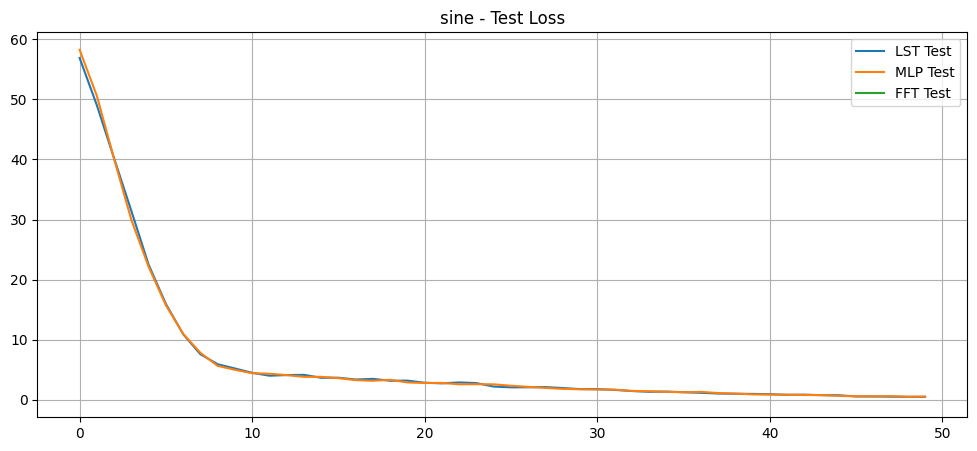

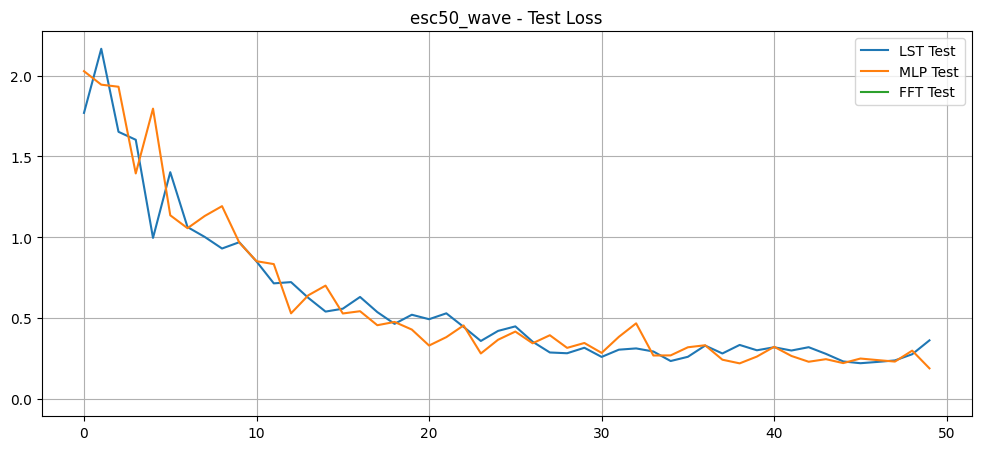

In [ ]:
#Loss Curve Plotter
def plot_loss(dataset):
    plt.figure(figsize=(12, 5))
    for md in MODELS:
        tr, te = results[dataset][md]
        plt.plot(te, label=f"{md.upper()} Test")
    plt.title(f"{dataset} - Test Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_loss("sine")
plot_loss("esc50_wave")

# 6.Frequency-conditioned Gradient Test”（分頻率梯度）
Spectral Bias 文獻（Rahaman 2019）最核心的分析方法之一
不同頻率的輸入波（sin(2πft)）會造成多大的梯度？
即：‖∂loss/∂x‖ 隨頻率 f 的變化曲線

In [ ]:

#產生固定頻率的測試波形 generate_sine
def generate_sine(freq, n_points=256, amp=1.0):
    t = np.linspace(0, 1, n_points)
    x = amp * np.sin(2 * np.pi * freq * t).astype(np.float32)
    return torch.tensor(x)

# 計算特定頻率 input 的 gradient norm
def gradient_for_frequency(model, freq, n_points=2048):
    x = generate_sine(freq, n_points).to(device).unsqueeze(0)
    x.requires_grad_(True)

    # Ground truth FFT（避免覆蓋 F = torch.nn.functional）
    F_fft = torch.fft.fft(x)
    y = torch.stack([F_fft.real, F_fft.imag], dim=-1)

    model.zero_grad()
    out = model(x)

    # 用 torch.nn.functional.mse_loss
    loss = F.mse_loss(out, y)
    loss.backward()

    g = x.grad.detach().cpu().numpy()
    return np.linalg.norm(g)

# 掃描多個頻率 (0~max_freq Hz)
def frequency_scan(model, max_freq=500, step=5, n_points=256):
    freqs = np.arange(1, max_freq + 1, step)
    grads = []

    for f in freqs:
        g = gradient_for_frequency(model, f, n_points=n_points)
        grads.append(g)

    return freqs, np.array(grads)

# 繪製頻率-梯度關係（Spectral Bias: 梯度版本）
def plot_frequency_gradient_sine(freqs_lst, grads_lst,
                                 freqs_mlp, grads_mlp):
    plt.figure(figsize=(12, 6))
    plt.plot(freqs_lst, grads_lst, label="LST Gradient", linewidth=3)
    plt.plot(freqs_mlp, grads_mlp, label="MLP Gradient", linewidth=3, alpha=0.7)

    plt.yscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("‖∂loss/∂x‖ (log scale)")
    plt.title("Frequency-Conditioned Gradient Test")
    plt.legend()
    plt.grid(True)
    plt.show()

#  7.1Spectral Bias Curve（低頻→高頻誤差）compute_spectral_bias
	•	LST 的頻率偏置（Spectral Bias）
	•	MLP 的頻率偏置
	•	FFT（ground truth） 作為 baseline
  LST 是否比 MLP 更能重建高頻？是否更穩定？是否更接近 FFT？

In [ ]:

#Spectral Bias Curve（低頻→高頻誤差）compute_spectral_bias
def compute_spectral_bias(model, dataset, n_points, max_batches=10):
    model.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    freq_energy = torch.zeros(n_points, device=device)
    count = 0

    with torch.no_grad():
        for batch in loader:
            # ---- 自動判斷 dataset 回傳格式 ----
            if isinstance(batch, (tuple, list)):
                x = batch[0]      # 取 waveform
            else:
                x = batch         # 只有 x

            x = x.to(device)

            # ---- 計算模型的輸出 spectrum ----
            out = model(x)                    # (B, N, 2)
            F_complex = out[..., 0] + 1j * out[..., 1]
            mag = F_complex.abs().mean(dim=0) # (N,)

            freq_energy += mag
            count += 1

            if count >= max_batches:
                break

    return freq_energy.cpu().numpy() / count

# Spectral Bias 繪圖函式
def plot_spectral_bias(freq_lst, freq_mlp, title="Spectral Bias"):
    N = len(freq_lst)
    freqs = np.arange(N)

    plt.figure(figsize=(12, 5))
    plt.plot(freqs, freq_lst, label="LST", linewidth=2)
    plt.plot(freqs, freq_mlp, label="MLP", linewidth=2, alpha=0.7)

    plt.yscale('log')
    plt.xlabel("Frequency Bin")
    plt.ylabel("MSE (log-scale)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

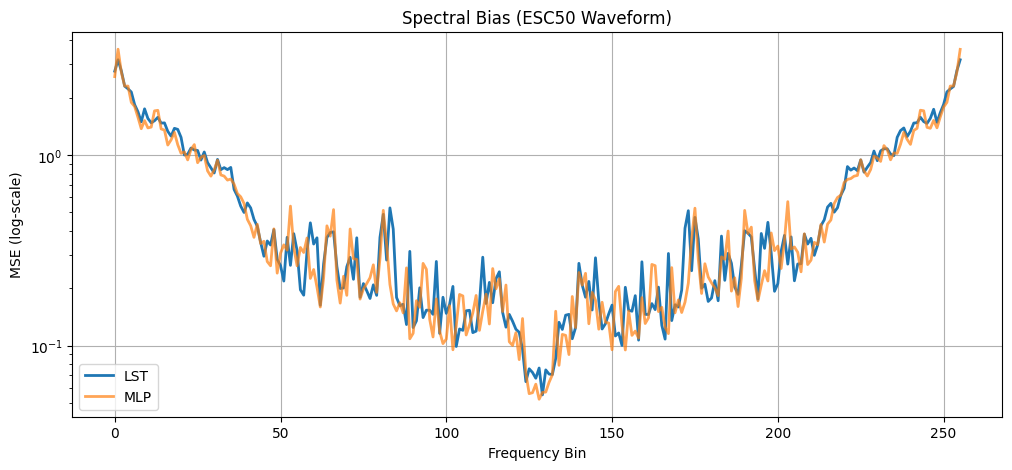

In [ ]:
train_ds, test_ds, N = load_dataset("esc50_wave")

model_lst = trained_models[("esc50_wave", "lst")]
model_mlp = trained_models[("esc50_wave", "mlp")]

freq_lst = compute_spectral_bias(model_lst, test_ds, N)
freq_mlp = compute_spectral_bias(model_mlp, test_ds, N)

plot_spectral_bias(freq_lst, freq_mlp,
                   title="Spectral Bias (ESC50 Waveform)")

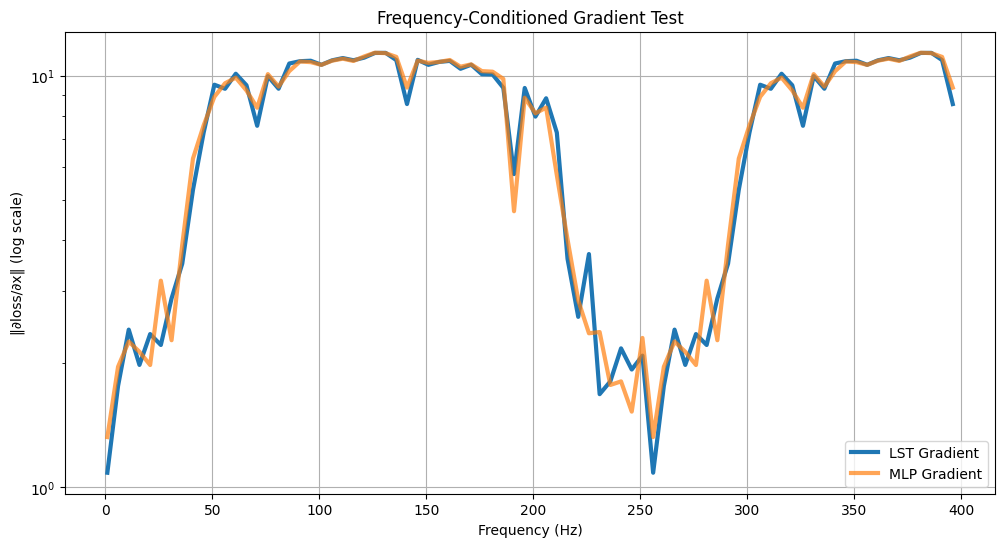

In [ ]:
MAX_FREQ = 400 #測試frequence, it can test to 10000

freqs_lst, grads_lst = frequency_scan(model_lst, max_freq=MAX_FREQ, step=5)
freqs_mlp, grads_mlp = frequency_scan(model_mlp, max_freq=MAX_FREQ, step=5)

plot_frequency_gradient_sine(freqs_lst, grads_lst,
                             freqs_mlp, grads_mlp)

# 8.noise robustness 試驗（FFT embedding vs LST_MLP）Q1
預測 dominant frequency 訓練後模型會存檔
噪音條件將從 0.0 → 1.0（標準差），逐步測試
1.downstream regression
2.noise robustness

Device: cpu

=== Stage 1: Training LST_MLP with Curriculum Noise ===
Epoch 01/40 | max_sigma=0.03 | LST_MLP loss=59.9737
Epoch 02/40 | max_sigma=0.05 | LST_MLP loss=40.6617
Epoch 03/40 | max_sigma=0.07 | LST_MLP loss=30.1535
Epoch 04/40 | max_sigma=0.10 | LST_MLP loss=23.1647
Epoch 05/40 | max_sigma=0.12 | LST_MLP loss=17.7070
Epoch 06/40 | max_sigma=0.15 | LST_MLP loss=13.3248
Epoch 07/40 | max_sigma=0.17 | LST_MLP loss=9.7883
Epoch 08/40 | max_sigma=0.20 | LST_MLP loss=7.1848
Epoch 09/40 | max_sigma=0.23 | LST_MLP loss=5.2383
Epoch 10/40 | max_sigma=0.25 | LST_MLP loss=4.3933
Epoch 11/40 | max_sigma=0.28 | LST_MLP loss=3.4390
Epoch 12/40 | max_sigma=0.30 | LST_MLP loss=3.0214
Epoch 13/40 | max_sigma=0.33 | LST_MLP loss=2.8484
Epoch 14/40 | max_sigma=0.35 | LST_MLP loss=3.6952
Epoch 15/40 | max_sigma=0.38 | LST_MLP loss=3.5631
Epoch 16/40 | max_sigma=0.40 | LST_MLP loss=4.1366
Epoch 17/40 | max_sigma=0.42 | LST_MLP loss=4.2867
Epoch 18/40 | max_sigma=0.45 | LST_MLP loss=5.0922
Epoch 1

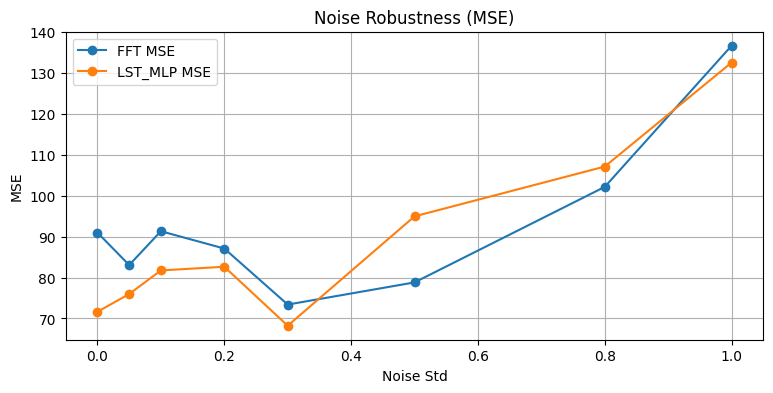

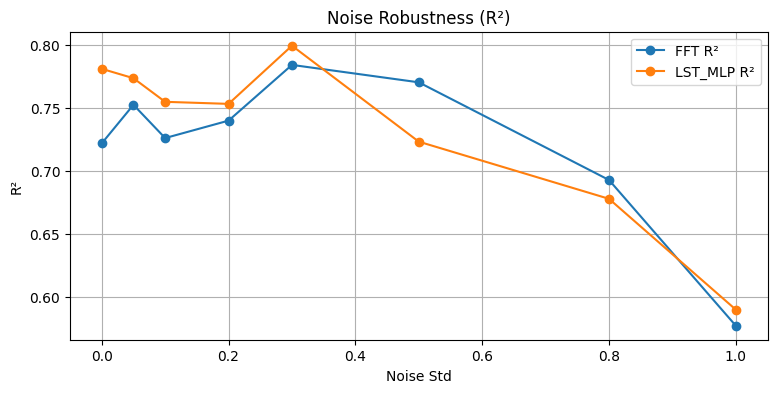


=== Summary (MSE, R²) ===
σ=0.00: FFT MSE=90.99, R²=0.722 | LST_MLP MSE=71.63, R²=0.781
σ=0.05: FFT MSE=83.06, R²=0.752 | LST_MLP MSE=75.98, R²=0.774
σ=0.10: FFT MSE=91.34, R²=0.726 | LST_MLP MSE=81.75, R²=0.755
σ=0.20: FFT MSE=87.11, R²=0.740 | LST_MLP MSE=82.65, R²=0.753
σ=0.30: FFT MSE=73.40, R²=0.784 | LST_MLP MSE=68.22, R²=0.799
σ=0.50: FFT MSE=78.82, R²=0.770 | LST_MLP MSE=94.98, R²=0.723
σ=0.80: FFT MSE=102.19, R²=0.693 | LST_MLP MSE=107.16, R²=0.678
σ=1.00: FFT MSE=136.73, R²=0.577 | LST_MLP MSE=132.60, R²=0.590


In [ ]:

# ==========================================
# Noise-aware LST_MLP (Curriculum Noise)
# ==========================================
#noise robustness 試驗
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ==========================================
# 0. Global configuration
# ==========================================
N_POINTS = 256
TRAIN_SIZE_LST = 12000
BATCH_LST = 128
EPOCHS_LST = 40
MAX_NOISE_CURRICULUM = 1.0  # 最後會讓模型學到 σ=1.0

# ==========================================
# 1. Synthetic signal generator
# ==========================================
def generate_signal_noise(n_points=N_POINTS, noise_std=0.0):
    t = np.linspace(0, 1, n_points)
    f = np.random.randint(1, n_points // 4)
    amp = np.random.uniform(0.5, 1.5)
    phase = np.random.uniform(0, 2*np.pi)

    x = amp * np.sin(2*np.pi*f*t + phase)
    if noise_std > 0:
        x += np.random.normal(0, noise_std, n_points)

    return x.astype(np.float32), float(f)

def make_dataset_noise(N, n_points=N_POINTS, noise_std=0.0):
    X, y = [], []
    for _ in range(N):
        xx, ff = generate_signal_noise(n_points, noise_std)
        X.append(xx)
        y.append(ff)
    return np.array(X), np.array(y)


# ==========================================
# 2. FFT embedding (teacher) (complex) + embedding (real)
# ==========================================
def fft_teacher(x_time: torch.Tensor):
    """
    Teacher for Stage 1: complex spectrum [B, K]
    """
    return torch.fft.rfft(x_time)

def fft_embedding_noise(x_time: torch.Tensor):
    """
    Embedding for Stage 2: real-valued [B, 2K] = [real, imag]
    """
    fft = torch.fft.rfft(x_time)       # [B, K] complex
    real = fft.real
    imag = fft.imag
    return torch.cat([real, imag], dim=-1)  # [B, 2K] float

# ==========================================
# 3. LST_MLP Model
# ==========================================
class LST_MLP(nn.Module):
    def __init__(self, n_points=N_POINTS, hidden=512, bottleneck=256):
        super().__init__()
        self.n_points = n_points
        out_dim = n_points // 2 + 1
        self.out_dim = out_dim

        self.net = nn.Sequential(
            nn.Linear(n_points, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, bottleneck),
            nn.ReLU(),
            nn.Linear(bottleneck, 2*out_dim)
        )

    def forward(self, x):
        """
        x: [B, N]
        return: complex spectrum [B, K]
        """
        out = self.net(x)                # [B, 2*K]
        real = out[..., :self.out_dim]   # [B, K]
        imag = out[..., self.out_dim:]   # [B, K]
        return torch.complex(real, imag) # complex [B, K]
# ==========================================
# 4. Stage 1: Curriculum Noise Training
# ==========================================
def train_lst_mlp():
    print("\n=== Stage 1: Training LST_MLP with Curriculum Noise ===")

    # clean signals as teacher base
    X_clean_np, _ = make_dataset_noise(TRAIN_SIZE_LST, noise_std=0.0)
    X_clean = torch.tensor(X_clean_np, device=device)

    lst = LST_MLP().to(device)
    opt = optim.Adam(lst.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    ds = TensorDataset(X_clean)
    dl = DataLoader(ds, batch_size=BATCH_LST, shuffle=True)

    for epoch in range(1, EPOCHS_LST + 1):
        lst.train()

        # curriculum noise increases linearly
        max_sigma = (epoch / EPOCHS_LST) * MAX_NOISE_CURRICULUM

        running_loss = 0.0
        for (xb_clean,) in dl:

            sigma = np.random.uniform(0.0, max_sigma)
            noise = torch.randn_like(xb_clean) * sigma
            xb_noisy = xb_clean + noise

            # Teacher: complex spectrum
            with torch.no_grad():
                target_fft = fft_teacher(xb_clean)  # [B, K] complex

            # Student: complex spectrum
            pred = lst(xb_noisy)                   # [B, K] complex

            # MSE on real+imag pair: [B, K, 2]
            loss = loss_fn(
                torch.view_as_real(pred),
                torch.view_as_real(target_fft)
            )

            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item() * xb_clean.size(0)

        print(f"Epoch {epoch:02d}/{EPOCHS_LST} | "
              f"max_sigma={max_sigma:.2f} | "
              f"LST_MLP loss={running_loss/len(ds):.4f}")

    print("LST_MLP curriculum training completed.\n")
    torch.save(lst.state_dict(), "LST_MLP.pth")
    print("Model saved to LST_MLP.pth")
    return lst



# ==========================================
# 5. Downstream regression model
# ==========================================
class Regressor_Downstream(nn.Module):
    def __init__(self, in_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)


def train_regressor_Downstream(emb_train, y_train, emb_test, y_test, epochs=8):
    in_dim = emb_train.shape[1]
    model = Regressor_Downstream(in_dim).to(device)

    ds = TensorDataset(emb_train, y_train)
    dl = DataLoader(ds, batch_size=64, shuffle=True)

    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for _ in range(epochs):
        for xb, yb in dl:
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()

    with torch.no_grad():
        pred = model(emb_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

    mse = mean_squared_error(y_true, pred)
    mae = mean_absolute_error(y_true, pred)
    r2  = r2_score(y_true, pred)
    return mse, mae, r2

# ==========================================
# 6. LST embedding for Stage 2
# ==========================================
def lst_embedding(x_time: torch.Tensor, lst_model: nn.Module):
    """
    將 LST_MLP 的 complex 輸出轉為 [B, 2K] 的實數 embedding
    """
    spec = lst_model(x_time)           # [B, K] complex
    real = spec.real
    imag = spec.imag
    return torch.cat([real, imag], dim=-1)  # [B, 2K] float

# ==========================================
# 7. Stage 2: Noise robustness comparison
# ==========================================
def noise_experiment(lst_model):
    noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0]

    fft_results, lst_results = [], []

    for sigma in noise_levels:
        print(f"\n--- Noise Std = {sigma} ---")
        X_train_np, y_train_np = make_dataset_noise(5000, noise_std=sigma)
        X_test_np,  y_test_np  = make_dataset_noise(1000, noise_std=sigma)

        X_train = torch.tensor(X_train_np, device=device)
        X_test  = torch.tensor(X_test_np,  device=device)
        y_train = torch.tensor(y_train_np, device=device).float()
        y_test  = torch.tensor(y_test_np,  device=device).float()

        with torch.no_grad():
            # FFT baseline embedding: [B, 2K]
            fft_train = fft_embedding_noise(X_train)
            fft_test  = fft_embedding_noise(X_test)

            # LST_MLP embedding: [B, 2K]
            lst_model.eval()
            lst_train = lst_embedding(X_train, lst_model)
            lst_test  = lst_embedding(X_test, lst_model)

        mse_fft, mae_fft, r2_fft = train_regressor_Downstream(
            fft_train, y_train, fft_test, y_test
        )
        mse_lst, mae_lst, r2_lst = train_regressor_Downstream(
            lst_train, y_train, lst_test, y_test
        )

        fft_results.append((mse_fft, mae_fft, r2_fft))
        lst_results.append((mse_lst, mae_lst, r2_lst))

        print(f"FFT → MSE={mse_fft:.2f}, R²={r2_fft:.3f}")
        print(f"LST_MLP → MSE={mse_lst:.2f}, R²={r2_lst:.3f}")

    return noise_levels, fft_results, lst_results


# ==========================================
# 7. Run LST_MLP (Curriculum Training)
# ==========================================
lst_mlp = train_lst_mlp()

# ==========================================
# 8. Noise robustness
# ==========================================
noise_levels, fft_res, lst_res = noise_experiment(lst_mlp)

# Visualization
fft_mse = [x[0] for x in fft_res]
lst_mse = [x[0] for x in lst_res]

plt.figure(figsize=(9,4))
plt.plot(noise_levels, fft_mse, marker='o', label="FFT MSE")
plt.plot(noise_levels, lst_mse, marker='o', label="LST_MLP MSE")
plt.title("Noise Robustness (MSE)")
plt.xlabel("Noise Std")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

fft_r2 = [x[2] for x in fft_res]
lst_r2 = [x[2] for x in lst_res]

plt.figure(figsize=(9,4))
plt.plot(noise_levels, fft_r2, marker='o', label="FFT R²")
plt.plot(noise_levels, lst_r2, marker='o', label="LST_MLP R²")
plt.title("Noise Robustness (R²)")
plt.xlabel("Noise Std")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.show()

print("\n=== Summary (MSE, R²) ===")
for i, sigma in enumerate(noise_levels):
    f = fft_res[i]
    l = lst_res[i]
    print(f"σ={sigma:.2f}: FFT MSE={f[0]:.2f}, R²={f[2]:.3f} | "
          f"LST_MLP MSE={l[0]:.2f}, R²={l[2]:.3f}")

# 6.1 Downstream Task Evaluation generate_signal FFT embeding VS LST_MLP

In [ ]:
# ==========================================
# Downstream Task:
# Predict dominant frequency using spectral embeddings
# Compare FFT vs MLP-LST
# ==========================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------
# 1. Generate synthetic signals
# ------------------------------
def generate_signal_Downstream(n_points=256):
    """Return time-domain signal and its dominant frequency"""
    t = np.linspace(0, 1, n_points)
    f = np.random.randint(1, n_points // 4)  # target dominant frequency
    amp = np.random.uniform(0.5, 1.5)

    x = amp * np.sin(2*np.pi*f*t)              # 1 sin component
    x += 0.1 * np.random.randn(n_points)      # noise

    return x.astype(np.float32), float(f)

def make_dataset_Downstream(N=8000, n_points=256):
    X = []
    y = []
    for _ in range(N):
        x, f = generate_signal_Downstream(n_points)
        X.append(x)
        y.append(f)
    return np.array(X), np.array(y)

# dataset
X_train, y_train = make_dataset_Downstream(6000)
X_test,  y_test  = make_dataset_Downstream(2000)

X_train = torch.tensor(X_train).to(device)
X_test  = torch.tensor(X_test).to(device)
y_train = torch.tensor(y_train).float().to(device)
y_test  = torch.tensor(y_test).float().to(device)


# ------------------------------
# 2. Define FFT baseline embedding
# ------------------------------
def fft_embedding(x):
    """Return real and imag parts of FFT embedding"""
    fft = torch.fft.rfft(x)
    real = fft.real
    imag = fft.imag
    return torch.cat([real, imag], dim=-1)


# ------------------------------
# 3. Load your LST model (MLP)
# ------------------------------
# 先建立 LST_MLP，然後載入 pth

# Step 1: create the model
model_lst = LST_MLP().to(device)

# Step 2: load checkpoint
state = torch.load("LST_MLP.pth", map_location=device)
model_lst.load_state_dict(state)

# Step 3: set to eval
model_lst.eval()
print("LST model loaded.\n")


# ------------------------------
# 4. Embedding: FFT vs LST
# ------------------------------
def lst_embedding(x):
    spec = model_lst(x)                     # [B, K] complex
    amp = torch.abs(spec)                   # [B, K]
    phase = torch.angle(spec)               # [B, K]
    emb = torch.cat([amp, phase], dim=-1)   # [B, 2K]
    return emb.float()


# ------------------------------
# 5. Regression model for downstream task
# ------------------------------
class Regressor(nn.Module):
    def __init__(self, in_dim, hidden=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)


def train_regressor(emb_train, emb_test):
    """Train a regressor on the given embeddings"""
    input_dim = emb_train.shape[1]
    model = Regressor(input_dim).to(device)

    ds_train = TensorDataset(emb_train, y_train)
    dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)

    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # train
    for ep in range(10):
        for xb, yb in dl_train:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

    # evaluate
    pred_test = model(emb_test).detach().cpu().numpy()
    y_true = y_test.cpu().numpy()

    mse = mean_squared_error(y_true, pred_test)
    mae = mean_absolute_error(y_true, pred_test)
    r2  = r2_score(y_true, pred_test)

    return mse, mae, r2


# ------------------------------
# 6. Compute embeddings
# ------------------------------
with torch.no_grad():

    emb_fft_train = fft_embedding(X_train)
    emb_fft_test  = fft_embedding(X_test)

    emb_lst_train = lst_embedding(X_train)
    emb_lst_test  = lst_embedding(X_test)


# ------------------------------
# 7. Train downstream regressors
# ------------------------------
print("=== FFT Embedding downstream performance ===")
mse_fft, mae_fft, r2_fft = train_regressor(emb_fft_train, emb_fft_test)
print(f"MSE={mse_fft:.4f}, MAE={mae_fft:.4f}, R²={r2_fft:.4f}")

print("\n=== LST (MLP) Embedding downstream performance ===")
mse_lst, mae_lst, r2_lst = train_regressor(emb_lst_train, emb_lst_test)
print(f"MSE={mse_lst:.4f}, MAE={mae_lst:.4f}, R²={r2_lst:.4f}")

# ------------------------------
# 8. Summary
# ------------------------------
print("\n=========== SUMMARY ===========")
print(f"FFT → MSE={mse_fft:.4f}, R²={r2_fft:.4f}")
print(f"LST → MSE={mse_lst:.4f}, R²={r2_lst:.4f}")

if mse_lst < mse_fft:
    print("\nConclusion: LST outperforms FFT in downstream prediction.")
else:
    print("\nConclusion: FFT still performs better — need stronger LST training.")

LST model loaded.

=== FFT Embedding downstream performance ===
MSE=49.7915, MAE=4.7677, R²=0.8530

=== LST (MLP) Embedding downstream performance ===
MSE=0.8298, MAE=0.7140, R²=0.9976

=========== SUMMARY ===========
FFT → MSE=49.7915, R²=0.8530
LST → MSE=0.8298, R²=0.9976

Conclusion: LST outperforms FFT in downstream prediction.


# 7.2 Gradient Stability Test（LST vs MLP）get_gradients Q2
	•	LST 的反向傳播梯度是否平穩（gradient stability）
	•	MLP 是否有梯度爆炸 / 梯度不穩定現象
  LST 在近似 FFT 時，反向傳遞的梯度是否比 MLP 更平穩？

  頻譜學習（Fourier Approximation）、Operator Learning（FNO/AFNO）、以及你的 CoT-DAO 研究中都會使用的標準分析方式

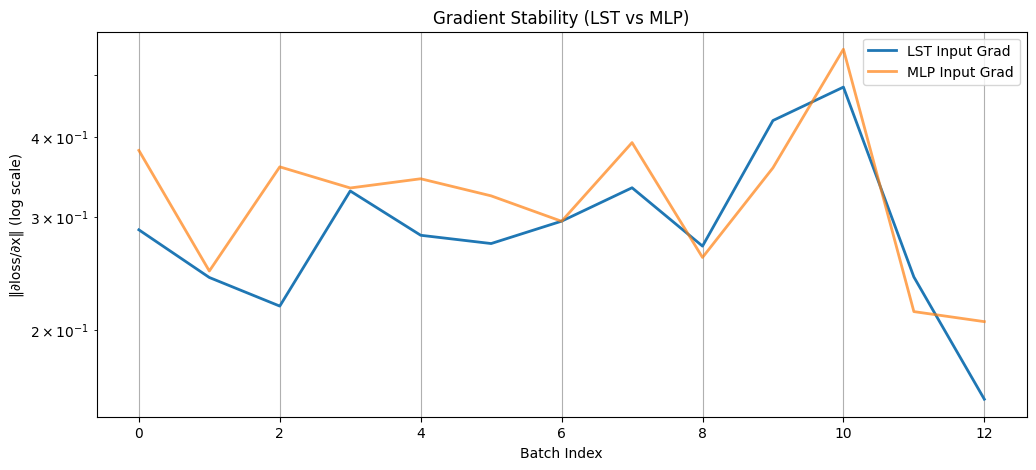

In [ ]:
#Gradient Stability Test（LST vs MLP）get_gradients
def get_gradients(model, x, y):
    """
    取得:
      - input 梯度 (x.grad)
      - 每層參數梯度 norm
    """
    model.zero_grad()
    x = x.clone().detach().requires_grad_(True)

    out = model(x)
    loss = F.mse_loss(out, y)
    loss.backward()

    # input gradient
    g_in = x.grad.detach().cpu().numpy()
    g_in_norm = np.linalg.norm(g_in)

    # parameter gradients
    g_params = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            g_params.append(np.linalg.norm(p.grad.detach().cpu().numpy()))
        else:
            g_params.append(0)

    return g_in_norm, g_params
##########################################################
#Gradient Stability Test（多 batch）                      #
##########################################################
def gradient_stability_test(model, dataset, n_batches=20):
    model.train()

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    grad_input_norms = []
    grad_param_norms = []

    count = 0
    for batch in loader:

        # --- batch may be x or (x, y) ---
        if isinstance(batch, (tuple, list)):
            x = batch[0]
        else:
            x = batch

        x = x.to(device)

        # --- ensure gradient to input ---
        x.requires_grad_(True)

        # --- forward ---
        pred = model(x)                 # pred shape: (B,N,2)
        loss = (pred ** 2).mean()       # ALWAYS scalar → OK

        # --- backward ---
        model.zero_grad(True)
        loss.backward()

        # --- gradient wrt input ---
        if x.grad is not None:
            grad_input_norms.append(x.grad.norm().item())
        else:
            grad_input_norms.append(0.0)

        # --- gradient wrt parameters ---
        p_norms = []
        for p in model.parameters():
            if p.grad is not None:
                p_norms.append(p.grad.norm().item())
        grad_param_norms.append(np.mean(p_norms))

        count += 1
        if count >= n_batches:
            break

    return grad_input_norms, grad_param_norms

##############################################
#繪製 Gradient Stability 圖(LST vs MLP)       #
##############################################
def plot_gradient_stability(g_in_lst, g_in_mlp, title="Gradient Stability"):
    plt.figure(figsize=(12, 5))
    plt.plot(g_in_lst, label="LST Input Grad", linewidth=2)
    plt.plot(g_in_mlp, label="MLP Input Grad", linewidth=2, alpha=0.7)

    plt.yscale("log")
    plt.title(title)
    plt.xlabel("Batch Index")
    plt.ylabel("‖∂loss/∂x‖ (log scale)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 執行
train_ds, test_ds, N = load_dataset("esc50_wave")

model_lst = trained_models[("esc50_wave", "lst")]
model_mlp = trained_models[("esc50_wave", "mlp")]

g_in_lst, g_param_lst = gradient_stability_test(model_lst, test_ds, n_batches=20)
g_in_mlp, g_param_mlp = gradient_stability_test(model_mlp, test_ds, n_batches=20)

plot_gradient_stability(g_in_lst, g_in_mlp,
                        title="Gradient Stability (LST vs MLP)")


# 9.Spectrogram Reconstruction （transform）LST_MLP Q1
比較三項：
	1.	Ground truth：STFT(x)
	2.	FFT reconstruction：iFFT(FFT(x))
	3.	LST reconstruction：iFFT(LST(x))
FFT alignment & reconstruction
。reconstruction consistency
。FFT teacher-student
。spectrogram reconstruction
。phase-aware architecture

Device: cpu
LST model loaded.

Reconstruction MSE = 0.134204


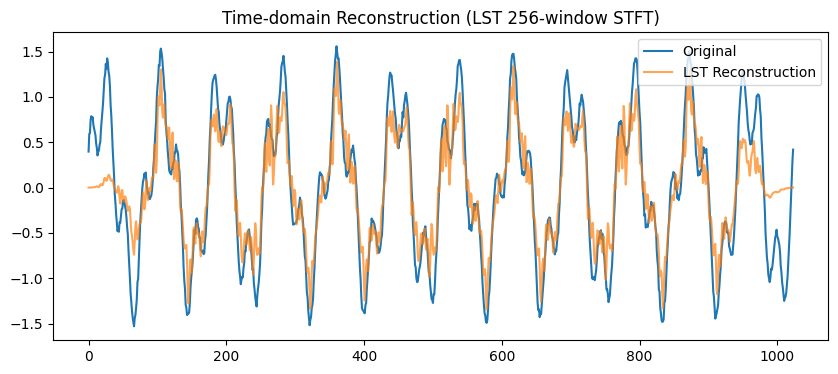

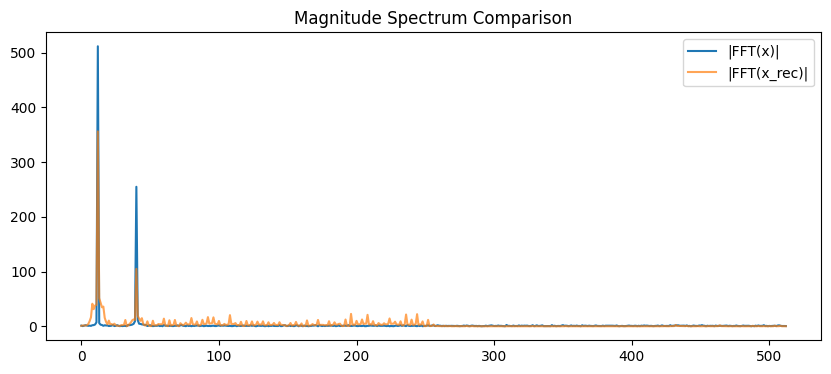

In [ ]:
# Spectrogram Reconstruction
# ==========================================
# LST_MLP: FFT + Reconstruction Consistency Loss
#  - Train LST to approximate complex FFT
#  - Plus enforce time-domain reconstruction via iFFT
# ==========================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.signal import stft

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ==========================================
# 1. Global settings
# ==========================================
N_POINTS = 256          # LST_MLP input size (fixed)
WIN = 256               # STFT window size
HOP = 128               # 50% overlap
SIGNAL_LEN = 1024       # length of signals to test reconstruction

# ==========================================
# 2. LST_MLP Definition (MUST match training architecture)
# ==========================================
class LST_MLP(nn.Module):
    def __init__(self, n_points=N_POINTS, hidden=512, bottleneck=256):
        super().__init__()
        self.n_points = n_points
        out_dim = n_points // 2 + 1
        self.out_dim = out_dim

        self.net = nn.Sequential(
            nn.Linear(n_points, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, bottleneck),
            nn.ReLU(),
            nn.Linear(bottleneck, 2*out_dim)
        )

    def forward(self, x):
        out = self.net(x)                 # [B, 2*K]
        real = out[..., :self.out_dim]
        imag = out[..., self.out_dim:]
        return torch.complex(real, imag)  # [B, K] complex


# ==========================================
# 3. Load Pre-trained LST_MLP (NO TRAINING)
# ==========================================
model_lst = LST_MLP(n_points=N_POINTS).to(device)

state = torch.load("LST_MLP.pth", map_location=device)
model_lst.load_state_dict(state)

model_lst.eval()
print("LST model loaded.\n")


# ==========================================
# 4. STFT windowing
# ==========================================
def frame_signal(x, frame_len=WIN, hop=HOP):
    frames = []
    for start in range(0, len(x) - frame_len + 1, hop):
        frames.append(x[start : start + frame_len])
    return np.stack(frames)


# ==========================================
# 5. Overlap-Add reconstruction
# ==========================================
def overlap_add(frames, frame_len=WIN, hop=HOP):
    out_len = (len(frames) - 1) * hop + frame_len
    y = np.zeros(out_len)

    win = np.hanning(frame_len)  # Hann window

    for i, f in enumerate(frames):
        y[i*hop : i*hop + frame_len] += f * win

    return y


# ==========================================
# 6. LST-based Reconstruction
# ==========================================
def lst_reconstruct_signal(x, model):
    # 1. 切 frame（每段 256 samples）
    frames = frame_signal(x)                 # [num_frames, 256]
    frames = torch.tensor(frames, device=device).float()

    # 2. 預測 frequency spectrum
    with torch.no_grad():
        X_hat = model(frames)                # [num_frames, K] complex
        frames_rec = torch.fft.irfft(X_hat, n=WIN)  # 每段還原成 time-domain 256 samples

    frames_rec = frames_rec.cpu().numpy()

    # 3. Overlap-Add 重建整段信號
    y = overlap_add(frames_rec, WIN, HOP)
    return y


# ==========================================
# 7. Example: generate test signal
# ==========================================
def generate_test_signal(n_points=SIGNAL_LEN):
    t = np.linspace(0, 1, n_points)
    x = np.sin(2*np.pi*12*t) + 0.5*np.sin(2*np.pi*40*t + 1.0)
    x += 0.03 * np.random.randn(n_points)
    return x.astype(np.float32)


x0 = generate_test_signal()
x0_rec = lst_reconstruct_signal(x0, model_lst)

mse = np.mean((x0 - x0_rec)**2)
print(f"Reconstruction MSE = {mse:.6f}")


# ==========================================
# 8. Plot time-domain reconstruction
# ==========================================
plt.figure(figsize=(10,4))
plt.plot(x0, label="Original")
plt.plot(x0_rec, label="LST Reconstruction", alpha=0.7)
plt.legend()
plt.title("Time-domain Reconstruction (LST 256-window STFT)")
plt.show()


# ==========================================
# 9. Frequency-domain comparison
# ==========================================
X0_true = np.fft.rfft(x0)
X0_hat  = np.fft.rfft(x0_rec)

plt.figure(figsize=(10,4))
plt.plot(np.abs(X0_true), label="|FFT(x)|")
plt.plot(np.abs(X0_hat),  label="|FFT(x_rec)|", alpha=0.7)
plt.legend()
plt.title("Magnitude Spectrum Comparison")
plt.show()

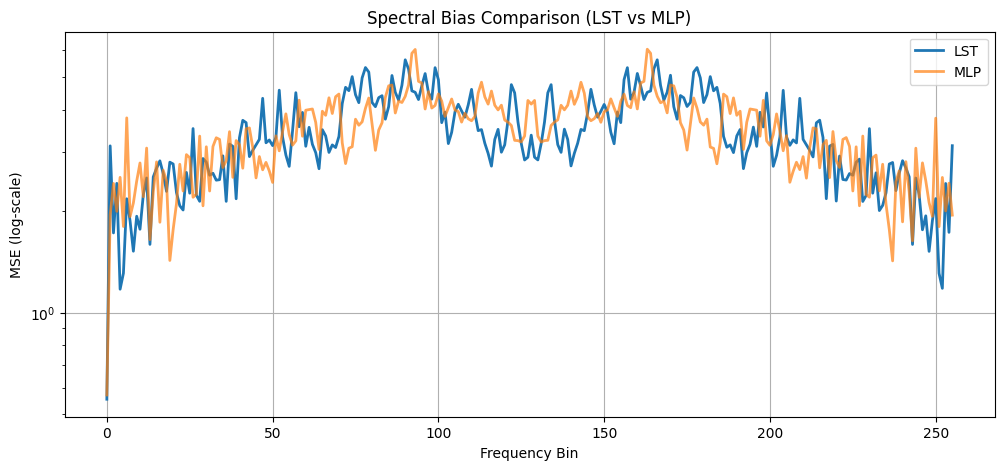

In [ ]:
train_ds, test_ds, N = load_dataset("sine")

model_lst = trained_models[("sine", "lst")]
model_mlp = trained_models[("sine", "mlp")]

freq_lst = compute_spectral_bias(model_lst, test_ds, N)
freq_mlp = compute_spectral_bias(model_mlp, test_ds, N)

plot_spectral_bias(freq_lst, freq_mlp,
                   title="Spectral Bias Comparison (LST vs MLP)")

# 10.φ-LST（Quadrant + Residual Phase Model）
用於校正 LST-MLP 在高頻或非線性訊號上的相位不穩定

Device: cpu

Baseline LST_MLP loaded from LST_MLP.pth.


=== Training φ-LST (Quadrant + Residual Phase) ===
[φ-LST] Epoch 01/60 | Total=266.7304 | Spec=242.0720 | Rec=0.9529 | Phase=2.6509 | Quad=1.4748 | Amp=224.4785 | Res=3.0582
[φ-LST] Epoch 02/60 | Total=132.6931 | Spec=121.1595 | Rec=0.4769 | Phase=2.4727 | Quad=1.5460 | Amp=96.9318 | Res=3.0095
[φ-LST] Epoch 03/60 | Total=102.1764 | Spec=94.2405 | Rec=0.3710 | Phase=2.4453 | Quad=1.6568 | Amp=61.5023 | Res=2.9538
[φ-LST] Epoch 04/60 | Total=91.9337 | Spec=85.5513 | Rec=0.3368 | Phase=2.4543 | Quad=1.8391 | Amp=45.6648 | Res=2.9215
[φ-LST] Epoch 05/60 | Total=83.9302 | Spec=78.3809 | Rec=0.3085 | Phase=2.4585 | Quad=1.9456 | Amp=37.2326 | Res=2.8876
[φ-LST] Epoch 06/60 | Total=78.8564 | Spec=73.7576 | Rec=0.2903 | Phase=2.4722 | Quad=2.0267 | Amp=32.6041 | Res=2.8552
[φ-LST] Epoch 07/60 | Total=72.7804 | Spec=68.0581 | Rec=0.2679 | Phase=2.4587 | Quad=2.0615 | Amp=28.9493 | Res=2.8382
[φ-LST] Epoch 08/60 | Total=69.3527 | Spec=64.

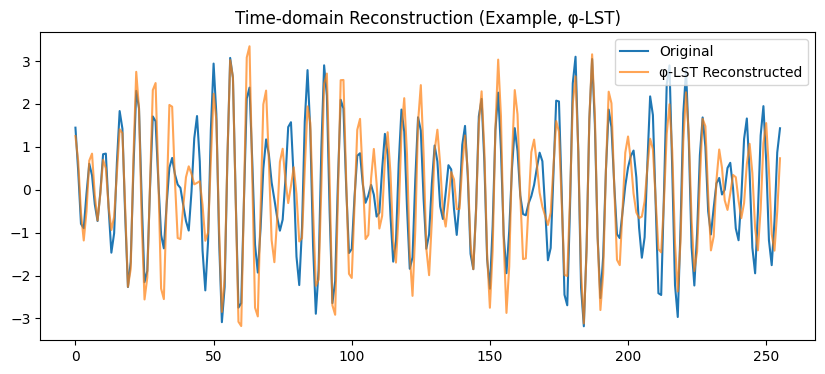

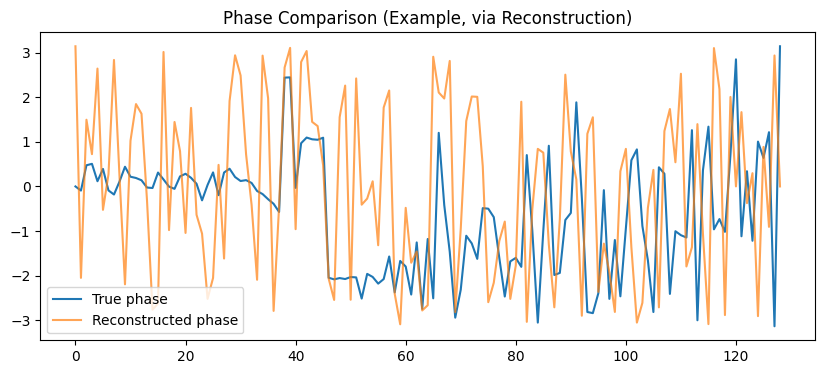

In [ ]:

# ==========================================
# φ-LST: Quadrant + Residual Phase Model
# Phase-Informed Learnable Spectral Transform
# ------------------------------------------
# - Baseline: LST_MLP (既有 checkpoint，僅載入不再訓練)
# - φ-LST: Amplitude + Quadrant + Residual Phase
# - 比較：Spectral MSE / Phase MSE / Reconstruction MSE
# ==========================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ------------------------------------------
# Device
# ------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ==========================================
# 1. Global Settings
# ==========================================
# !!! 請確認這裡要跟你訓練 LST_MLP.pth 當時的 n_points 一樣 !!!
N_POINTS   = 256
TRAIN_SIZE = 20000
TEST_SIZE  = 2000
BATCH_SIZE = 128

EPOCHS_PHI = 60       # 只訓練 φ-LST 的 epoch 數
LR_PHI     = 1e-3

# Loss 權重（可依實驗調整）
LAMBDA_REC   = 0.7   # Reconstruction loss
LAMBDA_PHASE = 0.3   # Phase full error
LAMBDA_QUAD  = 0.3   # Quadrant classification
LAMBDA_AMP   = 0.1   # Amplitude loss
LAMBDA_RES   = 0.1   # Residual phase loss


# ==========================================
# 2. Synthetic Signal Generator
# ==========================================
def generate_signal_LST(n_points=N_POINTS):
    """
    產生多頻正弦訊號 + 高斯雜訊
    用於 FFT / LST / φ-LST 的 teacher-student 任務
    """
    t = np.linspace(0, 1, n_points)
    k = np.random.randint(1, 5)    # 1~4 個頻率成分
    x = np.zeros(n_points, dtype=np.float32)
    for _ in range(k):
        f     = np.random.randint(5, n_points // 4)
        amp   = np.random.uniform(0.3, 1.5)
        phase = np.random.uniform(0, 2*np.pi)
        x += amp * np.sin(2*np.pi*f*t + phase)

    # 小雜訊
    x += 0.05 * np.random.randn(n_points).astype(np.float32)
    return x.astype(np.float32)


def make_dataset_LST(N, n_points=N_POINTS):
    X = [generate_signal_LST(n_points) for _ in range(N)]
    return np.array(X, dtype=np.float32)


# 建立訓練 / 測試資料
X_train_np = make_dataset_LST(TRAIN_SIZE)
X_test_np  = make_dataset_LST(TEST_SIZE)

X_train = torch.tensor(X_train_np, device=device)
X_test  = torch.tensor(X_test_np,  device=device)

train_ds = TensorDataset(X_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)


# ==========================================
# 3. Baseline LST_MLP (固定，不再訓練)
# ==========================================
class LST_MLP(nn.Module):
    """
    Baseline: 直接預測 complex FFT，架構。
    """
    def __init__(self, n_points=N_POINTS, hidden=512, bottleneck=256):
        super().__init__()
        self.n_points = n_points
        self.out_dim  = n_points // 2 + 1  # rFFT 長度 K

        self.net = nn.Sequential(
            nn.Linear(n_points, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, bottleneck),
            nn.ReLU(),
            nn.Linear(bottleneck, 2 * self.out_dim)
        )

    def forward(self, x):
        """
        x: [B, N]
        回傳:
          X_hat: [B, K] complex 頻譜
        """
        out = self.net(x)                          # [B, 2K]
        real = out[..., :self.out_dim]             # [B, K]
        imag = out[..., self.out_dim:]             # [B, K]
        X_hat = torch.complex(real, imag)          # [B, K]
        return X_hat


# ---- 載入既有的 baseline LST_MLP 權重 ----
model_lst = LST_MLP().to(device)

state = torch.load("LST_MLP.pth", map_location=device)
model_lst.load_state_dict(state)
model_lst.eval()

print("\nBaseline LST_MLP loaded from LST_MLP.pth.\n")


# ==========================================
# 4. φ-LST 模型：Amplitude + Quadrant + Residual Phase
# ==========================================
class PhiLST(nn.Module):
    """
    φ-LST: Phase-Predictive LST with
    - Amplitude head:  A_hat ≥ 0
    - Quadrant head:   logits over {0,1,2,3}
    - Residual head:   delta_phi ∈ (-π/2, π/2)
    最終相位：phi_hat = q_soft * (π/2) + delta_phi
    """
    def __init__(self, n_points=N_POINTS, hidden=512, bottleneck=256):
        super().__init__()
        self.n_points = n_points
        self.out_dim  = n_points // 2 + 1   # rFFT length K

        # Amplitude head
        self.amp_head = nn.Sequential(
            nn.Linear(n_points, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, bottleneck),
            nn.ReLU(),
            nn.Linear(bottleneck, self.out_dim),
            nn.Softplus()   # 保證 amplitude >= 0
        )

        # Quadrant head: output logits [B, K, 4]
        self.quad_head = nn.Sequential(
            nn.Linear(n_points, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.out_dim * 4)
        )

        # Residual phase head: delta_phi_raw → tanh → (-π/2, π/2)
        self.res_head = nn.Sequential(
            nn.Linear(n_points, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, bottleneck),
            nn.ReLU(),
            nn.Linear(bottleneck, self.out_dim)
        )

    def forward(self, x):
        """
        x: [B, N]
        回傳:
          A_hat:         [B, K]
          quad_logits:   [B, K, 4]
          delta_phi_hat: [B, K]  (已縮放到 (-π/2, π/2))
        """
        B = x.size(0)

        A_hat = self.amp_head(x)  # [B, K]

        quad_logits = self.quad_head(x)             # [B, K*4]
        quad_logits = quad_logits.view(B, self.out_dim, 4)  # [B, K, 4]

        delta_raw = self.res_head(x)                # [B, K]
        delta_phi_hat = (torch.pi / 2) * torch.tanh(delta_raw)  # (-π/2, π/2)

        return A_hat, quad_logits, delta_phi_hat


def phi_lst_forward(x, model: PhiLST):
    """
    x: [B, N]
    回傳:
      X_hat:          [B, K] complex 頻譜
      A_hat:          [B, K]
      phi_hat:        [B, K]
      quad_logits:    [B, K, 4]
      delta_phi_hat:  [B, K]
      x_rec:          [B, N]
    """
    A_hat, quad_logits, delta_phi_hat = model(x)

    # quadrant soft index q_soft ∈ [0,3]，可反向傳播
    probs = quad_logits.softmax(dim=-1)           # [B, K, 4]
    idx = torch.arange(4, device=x.device, dtype=x.dtype)  # [4]
    q_soft = (probs * idx).sum(dim=-1)            # [B, K]

    # 相位重建
    phi_hat = q_soft * (torch.pi / 2) + delta_phi_hat  # [B, K]

    # 複數頻譜重建：X_hat = A_hat * (cos φ + j sin φ)
    real = A_hat * torch.cos(phi_hat)
    imag = A_hat * torch.sin(phi_hat)
    X_hat = torch.complex(real, imag)             # [B, K] complex

    # 時域重建
    x_rec = torch.fft.irfft(X_hat, n=x.size(-1))  # [B, N]

    return X_hat, A_hat, phi_hat, quad_logits, delta_phi_hat, x_rec


# ==========================================
# 5. φ-LST Loss：Phase-aware + Reconstruction
# ==========================================
ce_loss = nn.CrossEntropyLoss()

def phi_lst_loss(x, model: PhiLST,
                 lambda_rec=LAMBDA_REC,
                 lambda_phase=LAMBDA_PHASE,
                 lambda_quad=LAMBDA_QUAD,
                 lambda_amp=LAMBDA_AMP,
                 lambda_res=LAMBDA_RES):

    """
    x: [B, N]
    回傳:
      total_loss 以及各子 loss (dict) 供監控
    """
    # φ-LST forward
    X_hat, A_hat, phi_hat, quad_logits, delta_phi_hat, x_rec = phi_lst_forward(x, model)

    # Teacher: ground-truth FFT（直接使用 FFT，而不是 LST_MLP）
    X_true   = torch.fft.rfft(x)        # [B, K], complex
    A_true   = torch.abs(X_true)        # [B, K]
    phi_true = torch.angle(X_true)      # [B, K], in (-π, π]

    # ---- Amplitude loss ----
    loss_amp = torch.mean((A_hat - A_true)**2)

    # ---- Quadrant target & residual target ----
    # q_true in {0,1,2,3} based on phi_true
    q_true = torch.floor((phi_true + torch.pi) / (torch.pi / 2))  # [B,K] in [0,4)
    q_true = q_true.clamp(0, 3).long()                            # [B,K] long

    # residual phase target
    delta_true = phi_true - q_true.float() * (torch.pi / 2)       # [B,K]

    # ---- Residual phase loss ----
    loss_res = torch.mean((delta_phi_hat - delta_true)**2)

    # ---- Quadrant classification loss ----
    loss_quad = ce_loss(quad_logits.view(-1, 4), q_true.view(-1))

    # ---- Phase full error (with 2π wrap-around) ----
    err1 = (phi_hat - phi_true)**2
    err2 = (phi_hat - phi_true + 2*torch.pi)**2
    err3 = (phi_hat - phi_true - 2*torch.pi)**2
    phase_err = torch.min(torch.min(err1, err2), err3)
    loss_phase = torch.mean(phase_err)

    # ---- Spectral complex MSE ----
    loss_spec = torch.mean(torch.abs(X_hat - X_true)**2)

    # ---- Time-domain reconstruction MSE ----
    loss_rec = torch.mean((x_rec - x)**2)

    # ---- Total loss ----
    total = (
        loss_spec
        + lambda_rec   * loss_rec
        + lambda_phase * loss_phase
        + lambda_quad  * loss_quad
        + lambda_amp   * loss_amp
        + lambda_res   * loss_res
    )

    return total, {
        "spec":  loss_spec.detach().item(),
        "rec":   loss_rec.detach().item(),
        "phase": loss_phase.detach().item(),
        "quad":  loss_quad.detach().item(),
        "amp":   loss_amp.detach().item(),
        "res":   loss_res.detach().item(),
    }


# ==========================================
# 6. 訓練 φ-LST（Baseline LST_MLP 保持 frozen）
# ==========================================
model_phi = PhiLST().to(device)
optimizer_phi = optim.Adam(model_phi.parameters(), lr=LR_PHI)

print("\n=== Training φ-LST (Quadrant + Residual Phase) ===")
for epoch in range(1, EPOCHS_PHI + 1):
    model_phi.train()
    total_loss = spec_loss = rec_loss = phase_loss = quad_loss = amp_loss = res_loss = 0.0

    for (xb,) in train_dl:
        optimizer_phi.zero_grad()
        loss, comps = phi_lst_loss(xb, model_phi)
        loss.backward()
        optimizer_phi.step()

        bs = xb.size(0)
        total_loss += loss.item()         * bs
        spec_loss  += comps["spec"]  * bs
        rec_loss   += comps["rec"]   * bs
        phase_loss += comps["phase"] * bs
        quad_loss  += comps["quad"]  * bs
        amp_loss   += comps["amp"]   * bs
        res_loss   += comps["res"]   * bs

    N = TRAIN_SIZE
    print(
        f"[φ-LST] Epoch {epoch:02d}/{EPOCHS_PHI} | "
        f"Total={total_loss/N:.4f} | Spec={spec_loss/N:.4f} | "
        f"Rec={rec_loss/N:.4f} | Phase={phase_loss/N:.4f} | "
        f"Quad={quad_loss/N:.4f} | Amp={amp_loss/N:.4f} | Res={res_loss/N:.4f}"
    )

print("φ-LST training finished.\n")


# ==========================================
# 7. 統一測試：Baseline LST_MLP vs φ-LST
# ==========================================
def eval_phase_rec(model_lst, model_phi, X_test):
    model_lst.eval()
    model_phi.eval()

    with torch.no_grad():
        # ---- Baseline LST ----
        X_hat_lst = model_lst(X_test)
        X_true = torch.fft.rfft(X_test)
        phi_true = torch.angle(X_true)
        phi_hat_lst = torch.angle(X_hat_lst)

        err1 = (phi_hat_lst - phi_true)**2
        err2 = (phi_hat_lst - phi_true + 2*torch.pi)**2
        err3 = (phi_hat_lst - phi_true - 2*torch.pi)**2
        phase_err_lst = torch.min(torch.min(err1, err2), err3)
        phase_mse_lst = torch.mean(phase_err_lst).item()

        spec_mse_lst = torch.mean(torch.abs(X_hat_lst - X_true)**2).item()
        x_rec_lst = torch.fft.irfft(X_hat_lst, n=X_test.size(-1))
        rec_mse_lst  = torch.mean((x_rec_lst - X_test)**2).item()

        # ---- φ-LST ----
        X_hat_phi, A_hat_phi, phi_hat_phi, quad_logits_phi, delta_hat_phi, x_rec_phi = \
            phi_lst_forward(X_test, model_phi)

        err1 = (phi_hat_phi - phi_true)**2
        err2 = (phi_hat_phi - phi_true + 2*torch.pi)**2
        err3 = (phi_hat_phi - phi_true - 2*torch.pi)**2
        phase_err_phi = torch.min(torch.min(err1, err2), err3)
        phase_mse_phi = torch.mean(phase_err_phi).item()

        spec_mse_phi = torch.mean(torch.abs(X_hat_phi - X_true)**2).item()
        rec_mse_phi  = torch.mean((x_rec_phi - X_test)**2).item()

    print("\n=== Test Evaluation: Baseline LST_MLP vs φ-LST ===")
    print(f"[LST ] Spectral MSE      = {spec_mse_lst:.6f}")
    print(f"[LST ] Phase MSE (wrap)  = {phase_mse_lst:.6f}")
    print(f"[LST ] Recon MSE         = {rec_mse_lst:.6f}")
    print("-" * 60)
    print(f"[φ-LST] Spectral MSE     = {spec_mse_phi:.6f}")
    print(f"[φ-LST] Phase MSE (wrap) = {phase_mse_phi:.6f}")
    print(f"[φ-LST] Recon MSE        = {rec_mse_phi:.6f}")

    return {
        "spec_lst":  spec_mse_lst,
        "phase_lst": phase_mse_lst,
        "rec_lst":   rec_mse_lst,
        "spec_phi":  spec_mse_phi,
        "phase_phi": phase_mse_phi,
        "rec_phi":   rec_mse_phi,
    }


metrics = eval_phase_rec(model_lst, model_phi, X_test)


# ==========================================
# 8. 單一樣本時間域 + 相位比較（可視化）
# ==========================================
with torch.no_grad():
    X_hat_phi, A_hat_phi, phi_hat_phi, quad_logits_phi, delta_hat_phi, x_rec_phi = \
        phi_lst_forward(X_test, model_phi)

idx = 0
x0      = X_test[idx].detach().cpu().numpy()
x0_rec  = x_rec_phi[idx].detach().cpu().numpy()

print(f"\nExample sample reconstruction MSE (φ-LST) = {np.mean((x0 - x0_rec)**2):.6f}")

plt.figure(figsize=(10,4))
plt.plot(x0, label="Original")
plt.plot(x0_rec, label="φ-LST Reconstructed", alpha=0.7)
plt.legend()
plt.title("Time-domain Reconstruction (Example, φ-LST)")
plt.show()

# 頻譜相位比較（用 φ-LST 重建後的訊號再做 FFT）
X0_true = np.fft.rfft(x0)
X0_hat  = np.fft.rfft(x0_rec)

phi0_true = np.angle(X0_true)
phi0_hat  = np.angle(X0_hat)

plt.figure(figsize=(10,4))
plt.plot(phi0_true, label="True phase")
plt.plot(phi0_hat,  label="Reconstructed phase", alpha=0.7)
plt.legend()
plt.title("Phase Comparison (Example, via Reconstruction)")
plt.show()

# 11.Complexity / Efficiency Analysis (GPU vs CPU) MLS_MLP

GPU版本


=== Benchmark N=256 ===
FFT time = 0.0406 ms
LST time = 1.0102 ms


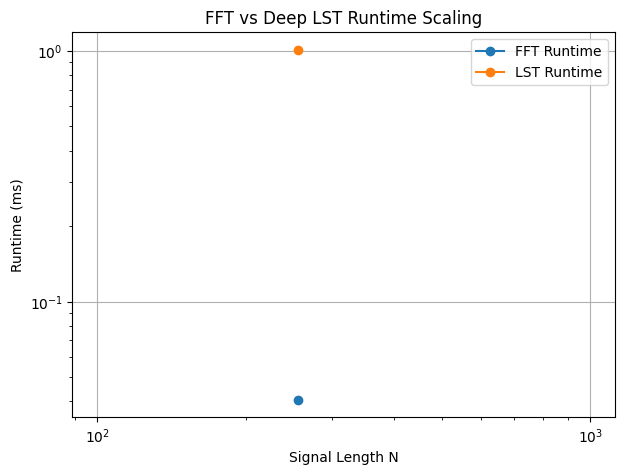

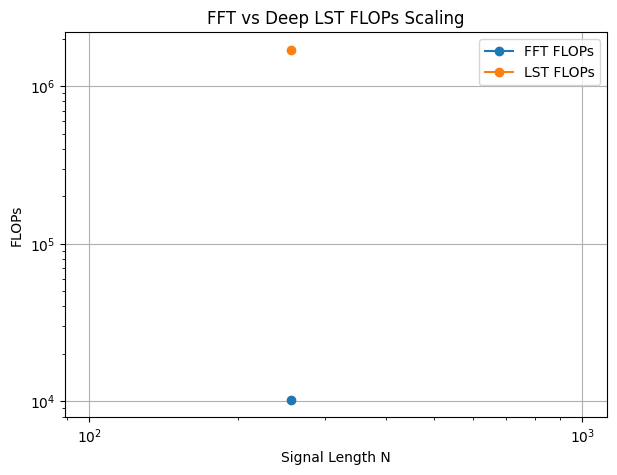


Deep LST Parameters = 854,530
FFT Parameters = 0

======= Summary Table =======
    N      FFT(ms)   LST(ms)    FFT FLOPs      LST FLOPs
256     0.0406     1.0102     10240.0        1704960.0


In [ ]:
# ================================================================
# Complexity / Efficiency Analysis for FFT vs LST (MLP)
# Using your official deep LST architecture (3×hidden + bottleneck)
# ================================================================
#GPU版本
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

model_lst = LST_MLP().to(device)
model_lst.eval()

# ================================================================
# 2. FLOPs Calculation for deep LST
# ================================================================
def count_mlp_flops(model, n_points):
    flops = 0
    prev = n_points
    for layer in model.net:
        if isinstance(layer, nn.Linear):
            flops += 2 * prev * layer.out_features
            prev = layer.out_features
    return flops

def count_fft_flops(N):
    return 5 * N * np.log2(N)  # Cooley–Tukey approx FLOPs

# ================================================================
# 3. Runtime Benchmark
# ================================================================
def benchmark(op, x, repeat=50):
    torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(repeat):
        y = op(x)
    torch.cuda.synchronize()
    return (time.time() - t0) / repeat * 1000  # ms

#sizes = [128, 256, 512, 1024] #可變長度
sizes = [256] #固定長度
fft_times, lst_times = [], []
fft_flops, lst_flops = [], []

for N in sizes:
    print(f"\n=== Benchmark N={N} ===")
    x = torch.randn(1, N).to(device)

    fft_flops.append(count_fft_flops(N))
    lst_flops.append(count_mlp_flops(model_lst, N))

    fft_t = benchmark(lambda a: torch.fft.rfft(a), x)
    lst_t = benchmark(lambda a: model_lst(a), x)

    fft_times.append(fft_t)
    lst_times.append(lst_t)

    print(f"FFT time = {fft_t:.4f} ms")
    print(f"LST time = {lst_t:.4f} ms")


# ================================================================
# 4. Plot: Runtime Scaling (log–log)
# ================================================================
plt.figure(figsize=(7,5))
plt.loglog(sizes, fft_times, '-o', label="FFT Runtime")
plt.loglog(sizes, lst_times, '-o', label="LST Runtime")
plt.xlabel("Signal Length N")
plt.ylabel("Runtime (ms)")
plt.title("FFT vs Deep LST Runtime Scaling")
plt.legend()
plt.grid(True)
plt.show()

# ================================================================
# 5. Plot: FLOPs Scaling
# ================================================================
plt.figure(figsize=(7,5))
plt.loglog(sizes, fft_flops, '-o', label="FFT FLOPs")
plt.loglog(sizes, lst_flops, '-o', label="LST FLOPs")
plt.xlabel("Signal Length N")
plt.ylabel("FLOPs")
plt.title("FFT vs Deep LST FLOPs Scaling")
plt.legend()
plt.grid(True)
plt.show()

# ================================================================
# 6. Memory Cost
# ================================================================
num_params = sum(p.numel() for p in model_lst.parameters())
print("\n======================================")
print(f"Deep LST Parameters = {num_params:,}")
print(f"FFT Parameters = 0")
print("======================================")

# ================================================================
# 7. Summary Table
# ================================================================
print("\n======= Summary Table =======")
print("    N      FFT(ms)   LST(ms)    FFT FLOPs      LST FLOPs")
for i, N in enumerate(sizes):
    print(f"{N:<7} {fft_times[i]:<10.4f} {lst_times[i]:<10.4f} "
          f"{fft_flops[i]:<14.1f} {lst_flops[i]:.1f}")

CPU版本


=== CPU Benchmark N=256 ===
FFT CPU time = 0.0127 ms
LST CPU time = 0.2737 ms


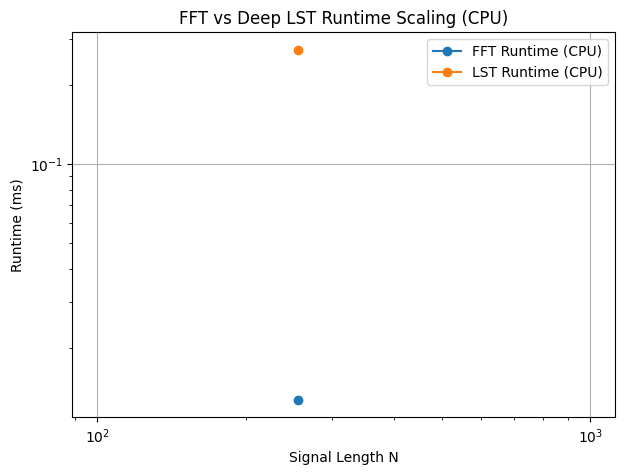

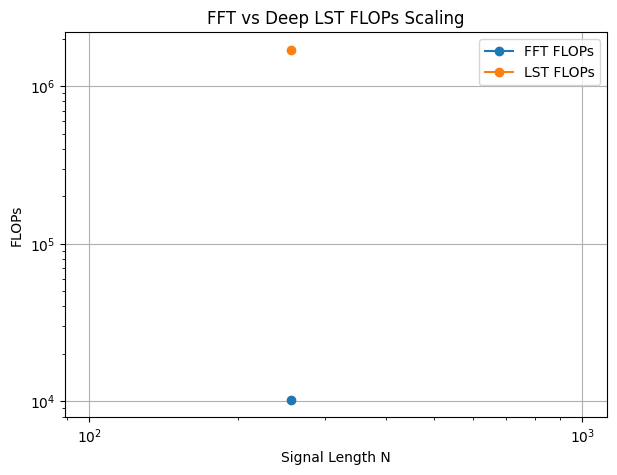


======= Summary Table (CPU) =======
    N      FFT(ms)   LST(ms)    FFT FLOPs      LST FLOPs
256     0.0127     0.2737     10240.0        1704960.0


In [ ]:
# ================================================================
# Complexity / Efficiency Analysis (CPU Version)
# Dynamic LST_MLP architecture per N
# ================================================================
#CPU 版本
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt

device = "cpu"

# ================================================================
# 2. FLOPs Calculation
# ================================================================
def count_mlp_flops(model, n_points):
    flops = 0
    prev = n_points
    for layer in model.net:
        if isinstance(layer, nn.Linear):
            flops += 2 * prev * layer.out_features
            prev = layer.out_features
    return flops

def count_fft_flops(N):
    return 5 * N * np.log2(N)


# ================================================================
# 3. CPU runtime benchmark
# ================================================================
def benchmark(op, x, repeat=20):
    t0 = time.time()
    for _ in range(repeat):
        y = op(x)
    return (time.time() - t0) / repeat * 1000  # ms


# ================================================================
# 4. Test on multiple N (dynamic model)
# ================================================================
#sizes = [128, 256, 512, 1024] #可變長度
sizes = [256] #固定長度
fft_times = []
lst_times = []
fft_flops = []
lst_flops = []

for N in sizes:
    print(f"\n=== CPU Benchmark N={N} ===")

    # generate dynamic LST model
    model_lst = LST_MLP(n_points=N).to(device)
    model_lst.eval()

    x = torch.randn(1, N).to(device)

    # FLOPs
    fft_flops.append(count_fft_flops(N))
    lst_flops.append(count_mlp_flops(model_lst, N))

    # Runtime
    fft_t = benchmark(lambda a: torch.fft.rfft(a), x)
    lst_t = benchmark(lambda a: model_lst(a), x)

    fft_times.append(fft_t)
    lst_times.append(lst_t)

    print(f"FFT CPU time = {fft_t:.4f} ms")
    print(f"LST CPU time = {lst_t:.4f} ms")


# ================================================================
# 5. Runtime Scaling plot
# ================================================================
plt.figure(figsize=(7,5))
plt.loglog(sizes, fft_times, '-o', label="FFT Runtime (CPU)")
plt.loglog(sizes, lst_times, '-o', label="LST Runtime (CPU)")
plt.xlabel("Signal Length N")
plt.ylabel("Runtime (ms)")
plt.title("FFT vs Deep LST Runtime Scaling (CPU)")
plt.legend()
plt.grid(True)
plt.show()

# ================================================================
# 6. FLOPs Scaling plot
# ================================================================
plt.figure(figsize=(7,5))
plt.loglog(sizes, fft_flops, '-o', label="FFT FLOPs")
plt.loglog(sizes, lst_flops, '-o', label="LST FLOPs")
plt.xlabel("Signal Length N")
plt.ylabel("FLOPs")
plt.title("FFT vs Deep LST FLOPs Scaling")
plt.legend()
plt.grid(True)
plt.show()

# ================================================================
# 7. Summary Table
# ================================================================
print("\n======= Summary Table (CPU) =======")
print("    N      FFT(ms)   LST(ms)    FFT FLOPs      LST FLOPs")
for i, N in enumerate(sizes):
    print(f"{N:<7} {fft_times[i]:<10.4f} {lst_times[i]:<10.4f} "
          f"{fft_flops[i]:<14.1f} {lst_flops[i]:.1f}")

# 12.Nonlinear Distortion Robustness Test（FFT vs LST_MLP）

Device: cpu
LST model loaded.


===== CLIPPING Distortion Test =====
FFT  spectral MSE = 66.574883
LST  spectral MSE = 108.238426
LST  reconstruction MSE = 0.426109

===== NOISE Distortion Test =====
FFT  spectral MSE = 6.262362
LST  spectral MSE = 41.951797
LST  reconstruction MSE = 0.165153

===== LOWPASS FILTER Distortion Test =====
FFT  spectral MSE = 0.044398
LST  spectral MSE = 42.201576
LST  reconstruction MSE = 0.166136


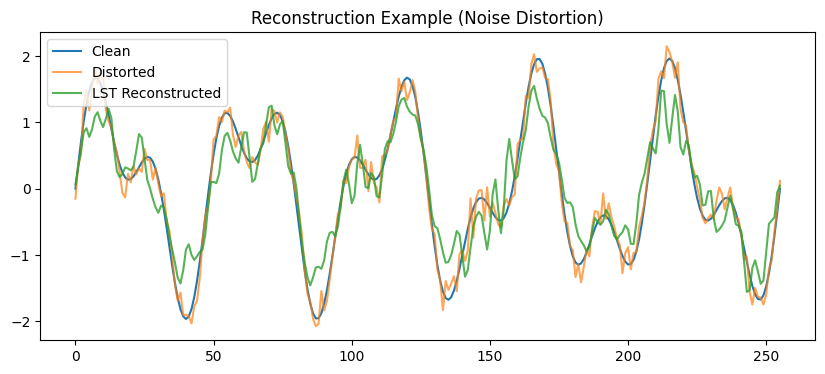

In [ ]:
#Nonlinear Distortion Robustness Test（FFT vs LST）
# ================================================================
# FFT vs LST Robustness Test (Clipping / Noise / Filtering)
# Using the correct model: LST_MLP (complex-output)
# ================================================================

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
# ---------------------------------------------------------
# Load trained LST_MLP model
# ---------------------------------------------------------
model_lst = LST_MLP().to(device)

# Replace this with your real checkpoint
model_lst.load_state_dict(torch.load("LST_MLP.pth", map_location=device))

model_lst.eval()
print("LST model loaded.\n")


# ================================================================
# 2. Distortion operators
# ================================================================

def apply_clipping(x, th=0.7):
    return torch.clamp(x, -th, th)

def apply_noise(x, sigma=0.1):
    return x + sigma * torch.randn_like(x)

def apply_lowpass(x, ratio=0.3):
    N = x.shape[-1]
    f = torch.fft.rfft(x)
    cutoff = int((N//2 + 1) * ratio)
    f[cutoff:] = 0
    return torch.fft.irfft(f, n=N)


# ================================================================
# 3. Robustness test function (complex-correct version)
# ================================================================

def distortion_test(distort_func, name, N=256):
    print(f"\n===== {name} Distortion Test =====")

    t = torch.linspace(0, 1, N)
    clean = (
        1.2 * torch.sin(2*np.pi*5*t)
        + 0.8 * torch.sin(2*np.pi*11*t)
    ).to(device)

    # Distorted
    distorted = distort_func(clean.cpu()).to(device)

    # Ground truth FFT
    fft_clean = torch.fft.rfft(clean)         # complex
    fft_dist  = torch.fft.rfft(distorted)

    # LST prediction (complex)
    lst_pred = model_lst(distorted.unsqueeze(0)).squeeze(0)

    # Spectral MSE
    spec_mse = torch.mean(torch.abs(lst_pred - fft_clean)**2).item()

    # FFT baseline error (how distortion differs from clean FFT)
    fft_mse = torch.mean(torch.abs(fft_dist - fft_clean)**2).item()

    # Reconstruction
    lst_rec = torch.fft.irfft(lst_pred, n=N)
    rec_mse = torch.mean((lst_rec - clean)**2).item()

    print(f"FFT  spectral MSE = {fft_mse:.6f}")
    print(f"LST  spectral MSE = {spec_mse:.6f}")
    print(f"LST  reconstruction MSE = {rec_mse:.6f}")

    return {
        "clean": clean.cpu().numpy(),
        "distorted": distorted.cpu().numpy(),
        "reconstructed": lst_rec.detach().cpu().numpy(),
        "fft_mse": fft_mse,
        "lst_spec_mse": spec_mse,
        "rec_mse": rec_mse,
    }


# ================================================================
# 4. Run three robustness tests
# ================================================================
res_clip  = distortion_test(lambda x: apply_clipping(x, 0.7), "CLIPPING", N=256)
res_noise = distortion_test(lambda x: apply_noise(x, 0.15), "NOISE", N=256)
res_lowp  = distortion_test(lambda x: apply_lowpass(x, 0.3), "LOWPASS FILTER", N=256)


# ================================================================
# 5. Example reconstruction plot
# ================================================================
plt.figure(figsize=(10,4))
plt.title("Reconstruction Example (Noise Distortion)")
plt.plot(res_noise["clean"], label="Clean")
plt.plot(res_noise["distorted"], label="Distorted", alpha=0.7)
plt.plot(res_noise["reconstructed"], label="LST Reconstructed", alpha=0.8)
plt.legend()
plt.show()

# 13.Statistical Summary（報告用）:Mean / Median / 25% / 75%  Cross-Dataset 比較（MIT vs ESC）

In [ ]:
#自動取得模型輸入維度 N_model
import torch
import torch.nn as nn
import numpy as np
import librosa
import glob
import os
import matplotlib.pyplot as plt

def get_model_input_dim(model):
    """
    自動讀取 LST_MLP 第一層 Linear 的 in_features。
    這告訴我們模型期望的輸入長度 N_model。
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            return m.in_features
    raise RuntimeError("Model has no Linear layer to infer input dimension.")

#一維訊號重採樣（確保長度對齊 N_model）
def resample_1d(x, target_N):
    """
    將任意長度的 1D numpy array 重採樣為 target_N 長度。
    """
    x = np.asarray(x).astype(np.float32)
    N_old = x.shape[0]
    if N_old == target_N:
        return x

    t_old = np.linspace(0.0, 1.0, N_old, endpoint=False)
    t_new = np.linspace(0.0, 1.0, target_N, endpoint=False)
    x_new = np.interp(t_new, t_old, x)
    return x_new.astype(np.float32)

#MIT-BIH Loader（高品質 ECG Segmentation）
from scipy.signal import resample
import wfdb

def load_mit_dataset(records=['100'], fs_target=360, N_model=256):
    """
    讀取 MIT-BIH ECG 資料集並切成模型需要的 segment。
    - 自動重採樣
    - 自動切片為固定長度 N_model
    """
    segments = []

    for rec in records:
        print(f"[MIT] Loading record {rec}...")
        data = wfdb.rdrecord(rec, pn_dir='mitdb')
        sig = data.p_signal[:,0]  # 第一導程
        fs = data.fs

        # 重採樣至 fs_target
        L_new = int(len(sig) * fs_target / fs)
        sig = resample(sig, L_new).astype(np.float32)

        # 切成 N_model 段
        k = len(sig) // N_model
        sig = sig[:k * N_model]
        win = sig.reshape(k, N_model)

        segments.append(win)

    segments = np.vstack(segments)
    print("[MIT] Total segments:", segments.shape[0])
    return segments

#ESC-50 Loader
def load_esc50_for_lst(model, sr_target=1024, seed=0):
    """
    從 ESC-50 讀全部音檔：
    - 重採樣到 sr_target
    - 切成 N_model 長度
    - 不漏讀，保證至少 1 筆資料
    """
    np.random.seed(seed)
    N_model = get_model_input_dim(model)

    # 搜尋音檔位置
    patterns = [
        "ESC-50-master/audio/*.wav",
        "ESC-50/audio/*.wav",
        "/content/ESC-50-master/audio/*.wav",
        "/content/ESC-50/audio/*.wav",
    ]

    files = []
    for p in patterns:
        f = glob.glob(p)
        if len(f) > 0:
            files = f
            print(f"[ESC] Found {len(files)} files in: {p}")
            break

    if len(files) == 0:
        raise RuntimeError("❌ Cannot find ESC-50 audio files.")

    segments = []

    # 讀取音檔並切 Segment
    for wav in files:
        x, sr = librosa.load(wav, sr=sr_target)
        x = x.astype(np.float32)

        if len(x) < N_model:
            continue

        k = len(x) // N_model
        x = x[:k * N_model]
        win = x.reshape(k, N_model)

        segments.append(win)

    if len(segments) == 0:
        raise RuntimeError("❌ All ESC audio too short for N_model.")

    segments = np.vstack(segments)
    print("[ESC] Total usable segments:", segments.shape)
    return segments

#Cross-Dataset Prediction + Error Computation
def build_cross_dataset_inputs(model, mit_dataset, esc_dataset):
    device = next(model.parameters()).device
    N_model = get_model_input_dim(model)
    K = N_model // 2 + 1  # FFT bins

    def compute_dataset_error(dataset):
        amp_sum = np.zeros(K)
        phase_sum = np.zeros(K)
        count = 0

        for x in dataset:
            x_np = resample_1d(x, N_model)
            x_t = torch.from_numpy(x_np).to(device).unsqueeze(0)

            X_true = torch.fft.rfft(x_t).squeeze(0)
            X_pred = model(x_t).squeeze(0)

            # Amplitude error
            A_true = torch.abs(X_true)
            A_pred = torch.abs(X_pred)
            rel_err = (torch.abs(A_pred - A_true) / (A_true + 1e-8))
            amp_sum += rel_err.detach().cpu().numpy()

            # Phase error (wrap-aware)
            phi_true = torch.angle(X_true)
            phi_pred = torch.angle(X_pred)
            err1 = (phi_pred - phi_true)**2
            err2 = (phi_pred - phi_true + 2*np.pi)**2
            err3 = (phi_pred - phi_true - 2*np.pi)**2
            phase = torch.sqrt(torch.min(torch.min(err1, err2), err3))
            phase_sum += phase.detach().cpu().numpy()

            count += 1

        return amp_sum / count, phase_sum / count

    amp_mit, phase_mit = compute_dataset_error(mit_dataset)
    amp_esc, phase_esc = compute_dataset_error(esc_dataset)

    freqs = np.arange(K)
    return freqs, amp_mit, amp_esc, phase_mit, phase_esc

#Cross-Dataset Visualization + Summary
import os
os.makedirs("figs", exist_ok=True)

def compare_datasets_mit_vs_esc(freqs, rel_mit, rel_esc, phase_mit, phase_esc):

    print("\n=== Cross-Dataset Spectral Comparison (MIT-BIH vs ESC-50) ===")

    # Amplitude
    plt.figure(figsize=(9,4))
    plt.plot(freqs, rel_mit, label="MIT-BIH")
    plt.plot(freqs, rel_esc, label="ESC-50")
    plt.xlabel("Frequency bin")
    plt.ylabel("Relative amplitude error")
    plt.legend(); plt.grid(True)
    plt.savefig("figs/cross_amp_error.png")
    plt.close()

    # Phase
    plt.figure(figsize=(9,4))
    plt.plot(freqs, phase_mit, label="MIT-BIH")
    plt.plot(freqs, phase_esc, label="ESC-50")
    plt.xlabel("Frequency bin")
    plt.ylabel("Phase error (rad)")
    plt.legend(); plt.grid(True)
    plt.savefig("figs/cross_phase_error.png")
    plt.close()

    # Summary
    print("MIT amplitude mean:", np.mean(rel_mit))
    print("ESC amplitude mean:", np.mean(rel_esc))
    print("MIT phase mean:",    np.mean(phase_mit))
    print("ESC phase mean:",    np.mean(phase_esc))

    print("=== Cross-Dataset Comparison Completed ===\n")

    # 1. Load Model
model_lst = LST_MLP().to(device)
model_lst.load_state_dict(torch.load("LST_MLP.pth"))

# 2. Load datasets
mit_dataset = load_mit_dataset(['100','101'], N_model=get_model_input_dim(model_lst))
esc_dataset = load_esc50_for_lst(model_lst)

# 3. Cross predict
freqs, amp_mit, amp_esc, phase_mit, phase_esc = \
    build_cross_dataset_inputs(model_lst, mit_dataset, esc_dataset)

# 4. Compare
compare_datasets_mit_vs_esc(freqs, amp_mit, amp_esc, phase_mit, phase_esc)

[MIT] Loading record 100...
[MIT] Loading record 101...
[MIT] Total segments: 5078
[ESC] Found 2000 files in: ESC-50-master/audio/*.wav
[ESC] Total usable segments: (40000, 256)

=== Cross-Dataset Spectral Comparison (MIT-BIH vs ESC-50) ===
MIT amplitude mean: 493.468143824286
ESC amplitude mean: 2148049.3909377777
MIT phase mean: 1.3703090727392213
ESC phase mean: 1.379484187300041
=== Cross-Dataset Comparison Completed ===



# 13.1 Statistical summary 可視化

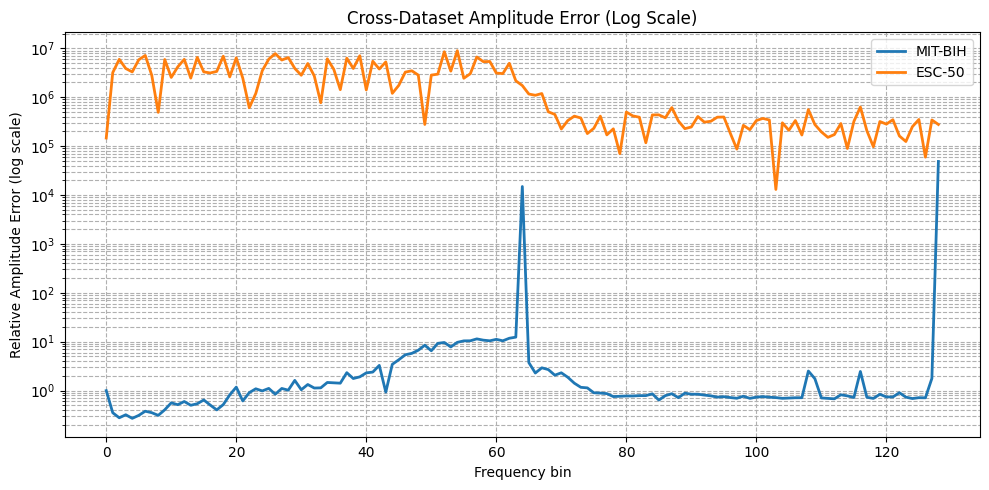

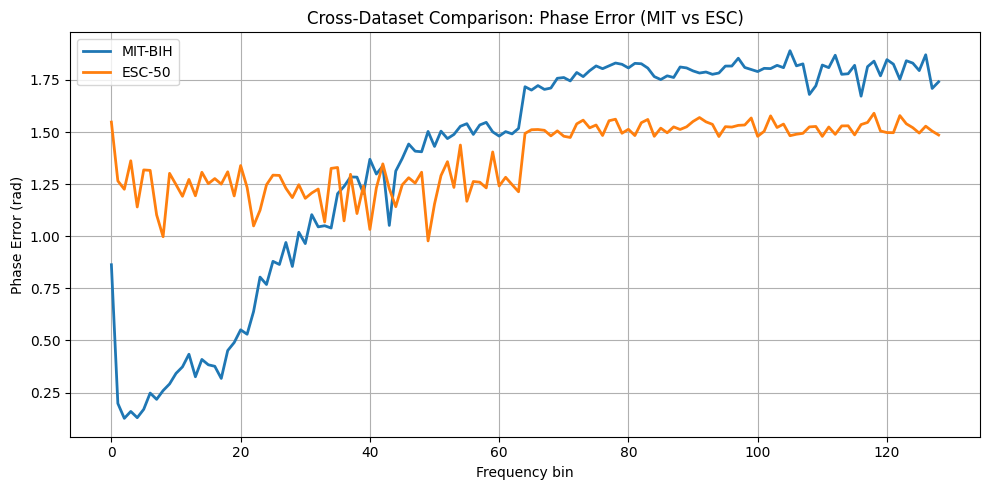

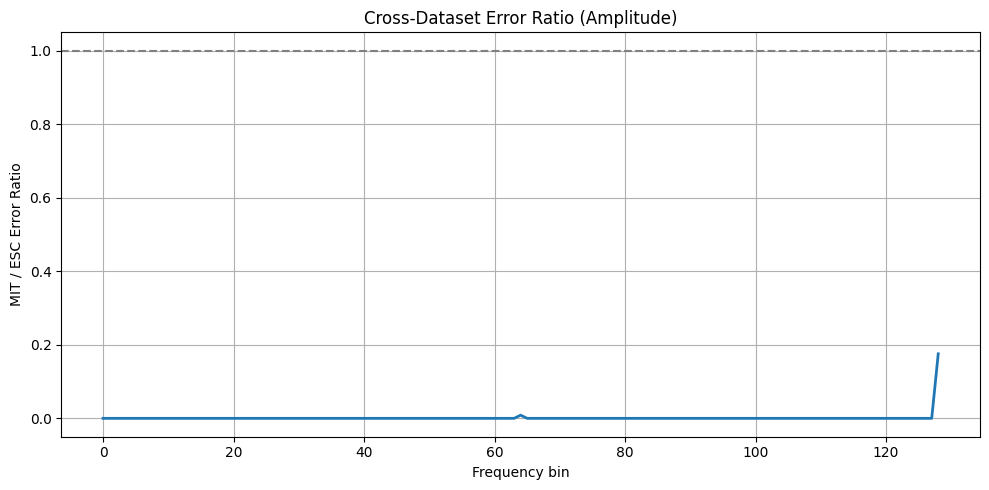

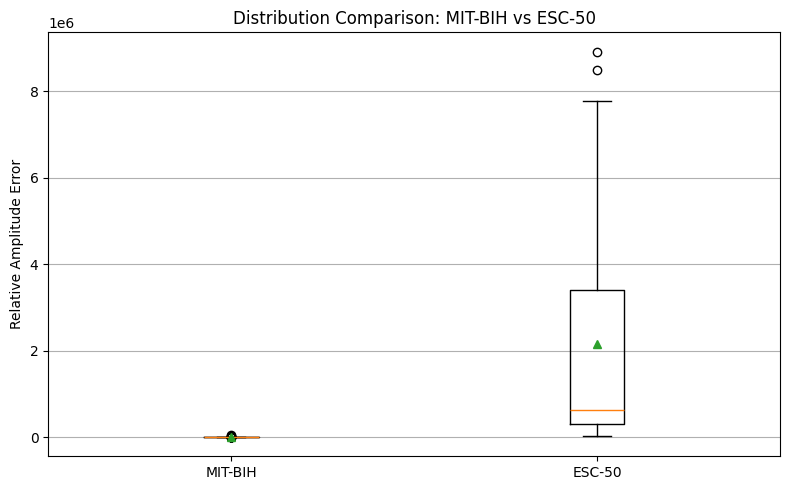

In [ ]:
#Amplitude Error Comparison（主曲線圖
def plot_amp_error_logscale(freqs, rel_err_mit, rel_err_esc,
                             save="figs/cross_amp_error_log.png"):

    plt.figure(figsize=(10, 5))
    plt.plot(freqs, rel_err_mit, label="MIT-BIH", linewidth=2)
    plt.plot(freqs, rel_err_esc, label="ESC-50", linewidth=2)

    plt.yscale("log")
    plt.xlabel("Frequency bin")
    plt.ylabel("Relative Amplitude Error (log scale)")
    plt.title("Cross-Dataset Amplitude Error (Log Scale)")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig(save, dpi=300)
    plt.show()

    # ===== 追加：Log-Scale 版本 =====
def plot_phase_error_comparison(freqs, phase_err_mit, phase_err_esc,
                                save="figs/cross_phase_error.png"):

    plt.figure(figsize=(10, 5))
    plt.plot(freqs, phase_err_mit, label="MIT-BIH", linewidth=2)
    plt.plot(freqs, phase_err_esc, label="ESC-50", linewidth=2)

    plt.xlabel("Frequency bin")
    plt.ylabel("Phase Error (rad)")
    plt.title("Cross-Dataset Comparison: Phase Error (MIT vs ESC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save, dpi=300)
    plt.show()
# Phase Error Comparison（主曲線圖）
def plot_phase_error_comparison(freqs, phase_err_mit, phase_err_esc,
                                save="figs/cross_phase_error.png"):
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, phase_err_mit, label="MIT-BIH", linewidth=2)
    plt.plot(freqs, phase_err_esc, label="ESC-50", linewidth=2)

    plt.xlabel("Frequency bin")
    plt.ylabel("Phase Error (rad)")
    plt.title("Cross-Dataset Comparison: Phase Error (MIT vs ESC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save, dpi=300)
    plt.show()
#MIT/ESC error ratio（robustness index）
#藉由：
#R(f) = \frac{\text{Err}_{MIT}(f)}{\text{Err}_{ESC}(f) + \epsilon}
#可衡量「醫療訊號 vs 一般音訊」的 spectral stability。
def plot_error_ratio(freqs, rel_err_mit, rel_err_esc, eps=1e-8,
                     save="figs/cross_error_ratio.png"):

    ratio = rel_err_mit / (rel_err_esc + eps)

    plt.figure(figsize=(10, 5))
    plt.plot(freqs, ratio, linewidth=2)
    plt.axhline(1.0, linestyle="--", color="gray")

    plt.xlabel("Frequency bin")
    plt.ylabel("MIT / ESC Error Ratio")
    plt.title("Cross-Dataset Error Ratio (Amplitude)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save, dpi=300)
    plt.show()

    return ratio

    return ratio
#Error Distribution Comparison（Boxplot）
def plot_error_distribution(rel_err_mit, rel_err_esc,
                            save="figs/cross_error_boxplot.png"):

    plt.figure(figsize=(8, 5))
    plt.boxplot([rel_err_mit, rel_err_esc],
                tick_labels=["MIT-BIH", "ESC-50"],
                showmeans=True)

    plt.ylabel("Relative Amplitude Error")
    plt.title("Distribution Comparison: MIT-BIH vs ESC-50")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.savefig(save, dpi=300)
    plt.show()

plot_amp_error_logscale(freqs, amp_mit, amp_esc)
plot_phase_error_comparison(freqs, phase_mit, phase_esc)
ratio = plot_error_ratio(freqs, amp_mit, amp_esc)
plot_error_distribution(amp_mit, amp_esc)

# 13.2 Staticstical summary 表格化

In [ ]:

import numpy as np

def summarize_stats(name, arr):
    arr = np.array(arr)
    return {
        "dataset": name,
        "mean": float(np.mean(arr)),
        "median": float(np.median(arr)),
        "std": float(np.std(arr)),
        "p95": float(np.percentile(arr, 95)),
    }

# === 正確對應 ===
amp_stats_mit   = summarize_stats("MIT-BIH", amp_mit)
amp_stats_esc   = summarize_stats("ESC-50", amp_esc)
phase_stats_mit = summarize_stats("MIT-BIH", phase_mit)
phase_stats_esc = summarize_stats("ESC-50", phase_esc)

print("Amplitude Error Stats:")
print(amp_stats_mit)
print(amp_stats_esc)

print("\nPhase Error Stats:")
print(phase_stats_mit)
print(phase_stats_esc)

Amplitude Error Stats:
{'dataset': 'MIT-BIH', 'mean': 493.468143824286, 'median': 0.862771522232798, 'std': 4438.078322035902, 'p95': 10.617291394622846}
{'dataset': 'ESC-50', 'mean': 2148049.3909377777, 'median': 629611.0140554486, 'std': 2338325.486127253, 'p95': 6580891.048147413}

Phase Error Stats:
{'dataset': 'MIT-BIH', 'mean': 1.3703090727392213, 'median': 1.6721625512318379, 'std': 0.5464980135755239, 'p95': 1.8366305788477142}
{'dataset': 'ESC-50', 'mean': 1.379484187300041, 'median': 1.4785380879353731, 'std': 0.15851914552787558, 'p95': 1.559061223024251}


# 16.Harmonic Consistency Test（harmonic preservation）:LST_MLP //RQ3
	輸出（harmonic index, frequency sweep, amplitude ratio error）
	•	“Does the learned transform preserve frequency locality?”
	•	“Does the MLP cause cross-frequency leakage?”
	•	“How does harmonic structure propagate across LST layers?”

(1) Harmonic Consistency Test（harmonic preservation）
1. Harmonic peak detection（偵測 harmonic 峰值位置）
2. Peak alignment（檢查 harmonic是否對齊正確bin）
3. Multi-tone sweep（多頻信號 sweeping）
4. Chirp response test（由低頻掃到高頻的 chirp 測試）

Device: cpu
LST_MLP loaded from LST_MLP.pth
=== Interpretable Frequency Mapping for LST_MLP ===

[Single Harmonic Case] Example


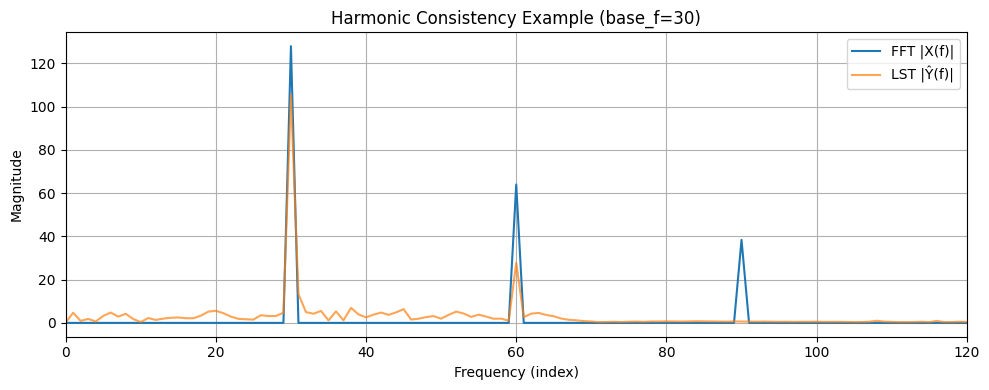

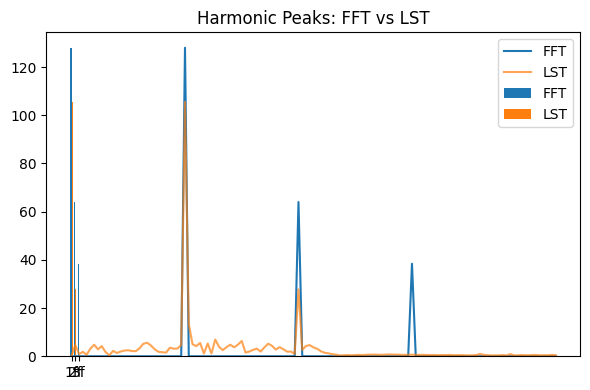

Example harmonic case saved.

=== Harmonic Sweep (50–300 Hz) ===


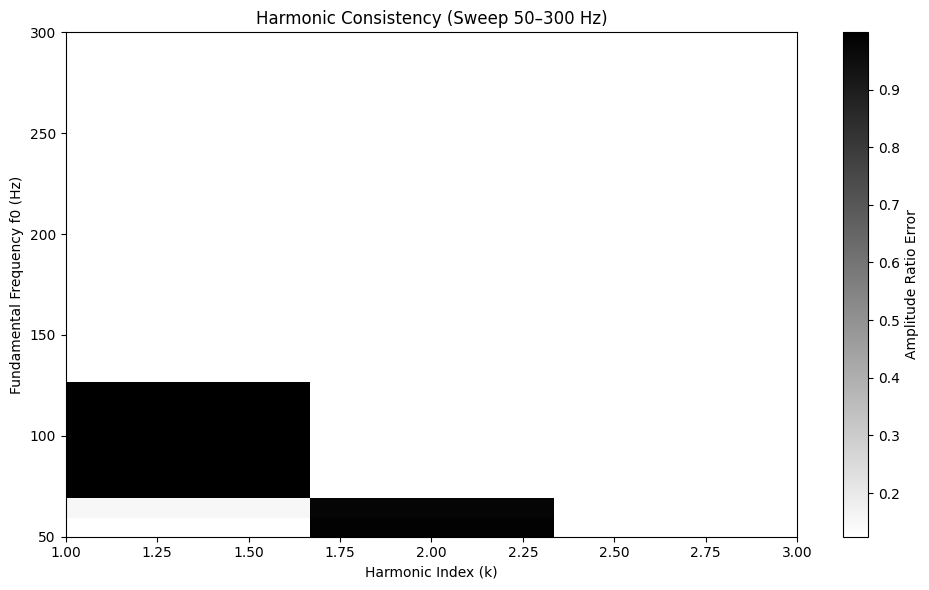

Harmonic sweep heatmap saved.


In [ ]:
# ==========================================
#  LST_MLP
# ==========================================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

# -----------------------------
# Global config
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

N_POINTS = 256
HIDDEN = 512
BOTTLENECK = 256
CHECKPOINT = "LST_MLP.pth"   # 依照你現在的檔名

os.makedirs("figs_interpret", exist_ok=True)

# ==========================================
# 2. 載入訓練好的 LST_MLP
# ==========================================
model_lst = LST_MLP().to(DEVICE)
state = torch.load(CHECKPOINT, map_location=DEVICE)
model_lst.load_state_dict(state)
model_lst.eval()
print(f"LST_MLP loaded from {CHECKPOINT}")


# ==========================================
# 3. Helper functions
# ==========================================
def to_torch(x: np.ndarray) -> torch.Tensor:
    return torch.tensor(x, dtype=torch.float32, device=DEVICE)


def fft_complex(x_time: torch.Tensor) -> torch.Tensor:
    """
    x_time: [B, N]
    return: complex spectrum [B, K]
    """
    return torch.fft.rfft(x_time, dim=-1)

def fft_amp(x: torch.Tensor):
    return torch.abs(torch.fft.rfft(x))


def gen_harmonic_signal(n_points=N_POINTS, base_f=30, harmonics=[1, 2, 3]):
    """
    基頻 base_f，附加 2f, 3f... 諧波，用於 harmonic consistency 測試
    """
    t = np.linspace(0, 1, n_points, endpoint=False)
    x = np.zeros_like(t, dtype=np.float32)
    amps = {1: 1.0, 2: 0.5, 3: 0.3}
    for k in harmonics:
        phase = np.random.uniform(0, 2*np.pi)
        x += amps.get(k, 0.3) * np.sin(2*np.pi*k*base_f*t + phase)
    return x


# ==========================================
# 4. Harmonic Consistency Analysis
# ==========================================
def analyze_single_harmonic_case(base_f=30, harmonics=(1,2,3)):
    """
    檢查 LST 是否在基頻與諧波位置保留正確能量
    - 輸出兩張圖：
      1. FFT vs LST amplitude spectrum
      2. 各 harmonic 的振幅誤差 bar chart
    """
    print("\n[Single Harmonic Case] Example")

    x = gen_harmonic_signal(N_POINTS, base_f, harmonics)
    x_t = to_torch(x)[None, :]

    with torch.no_grad():
        X_fft = fft_complex(x_t)[0]
        X_lst = model_lst(x_t)[0]

    mag_fft = torch.abs(X_fft).cpu().numpy()
    mag_lst = torch.abs(X_lst).cpu().numpy()
    freqs = np.fft.rfftfreq(N_POINTS, 1.0 / N_POINTS)

    # ----------- Plot amplitude spectrum -----------
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, mag_fft, label="FFT |X(f)|")
    plt.plot(freqs, mag_lst, label="LST |Ŷ(f)|", alpha=0.7)
    plt.xlim(0, base_f*(max(harmonics)+1))
    plt.xlabel("Frequency (index)")
    plt.ylabel("Magnitude")
    plt.title(f"Harmonic Consistency Example (base_f={base_f})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("figs_interpret/example_harmonic_spectrum.png", dpi=250)
    plt.show()

    # ----------- Harmonic peak comparison -----------
    out_dim = N_POINTS//2 + 1
    true_amps, est_amps, errors, labels = [], [], [], []

    for k in harmonics:
        bin_idx = int(round(k*base_f))
        if bin_idx < out_dim:
            A_true = mag_fft[bin_idx]
            A_hat = mag_lst[bin_idx]
            true_amps.append(A_true)
            est_amps.append(A_hat)
            errors.append(abs(A_hat - A_true))
            labels.append(f"{k}f")

    # bar chart
    x_pos = np.arange(len(labels))
    plt.figure(figsize=(6, 4))
    plt.plot(freqs, mag_fft, label="FFT")
    plt.plot(freqs, mag_lst, label="LST", alpha=0.7)
    plt.bar(x_pos - 0.15, true_amps, width=0.3, label="FFT")
    plt.bar(x_pos + 0.15, est_amps, width=0.3, label="LST")
    plt.xticks(x_pos, labels)
    plt.title("Harmonic Peaks: FFT vs LST")
    plt.legend()   # ← 這一行會顯示色條
    plt.tight_layout()
    plt.savefig("figs_interpret/example_harmonic_peaks.png", dpi=250)
    plt.show()

    print("Example harmonic case saved.")

# ================================================
# 4B. Harmonic Sweep Matrix (main experiment)
# ================================================
def analyze_harmonic_sweep():

    print("\n=== Harmonic Sweep (50–300 Hz) ===")

    fundamental_freqs = np.arange(50, 301, 10)
    harmonic_indices = [1,2,3]

    t = torch.linspace(0, 1, N_POINTS, device=DEVICE)
    error_matrix = np.zeros((len(fundamental_freqs), len(harmonic_indices)))

    for i, f0 in enumerate(fundamental_freqs):

        x = (
            torch.sin(2*np.pi*f0*t) +
            0.5 * torch.sin(2*np.pi*2*f0*t) +
            0.25 * torch.sin(2*np.pi*3*f0*t)
        ).float()

        x_input = x.unsqueeze(0)

        A_true = fft_amp(x)

        with torch.no_grad():
            X_lst = model_lst(x_input)[0]
        A_pred = torch.abs(X_lst)

        for j, k in enumerate(harmonic_indices):
            idx = int(k*f0)
            if idx >= len(A_true):
                error_matrix[i, j] = np.nan
                continue

            true_val = A_true[idx].item()
            pred_val = A_pred[idx].item()

            if true_val == 0:
                error_matrix[i, j] = np.nan
            else:
                error_matrix[i, j] = abs(pred_val/true_val - 1.0)

    # ---------- Heatmap ----------
    plt.figure(figsize=(10, 6))
    plt.imshow(
        error_matrix,
        aspect="auto",
        origin="lower",
        extent=[1,3,fundamental_freqs[0],fundamental_freqs[-1]],
        cmap="gray_r"
    )
    plt.colorbar(label="Amplitude Ratio Error")
    plt.xlabel("Harmonic Index (k)")
    plt.ylabel("Fundamental Frequency f0 (Hz)")
    plt.title("Harmonic Consistency (Sweep 50–300 Hz)")
    plt.tight_layout()
    plt.savefig("figs_interpret/harmonic_sweep_heatmap.png", dpi=300)
    plt.show()

    print("Harmonic sweep heatmap saved.")


# ==========================================
# 7. Main
# ==========================================
if __name__ == "__main__":
    print("=== Interpretable Frequency Mapping for LST_MLP ===")

    # 1. Single example (supplementary)
    analyze_single_harmonic_case(base_f=30, harmonics=(1,2,3))

    # 2. Full harmonic sweep (main experiment)
    analyze_harmonic_sweep()

In [ ]:
#Harmonic Peak Detection
def detect_harmonic_peaks(mag, base_f, harmonics=[1,2,3]):
    """
    Return: dict {k: (bin_idx, magnitude)}
    """
    peaks = {}
    for k in harmonics:
        idx = int(base_f * k)
        if idx < len(mag):
            peaks[k] = (idx, mag[idx])
        else:
            peaks[k] = (None, None)
    return peaks
#Peak Alignment Test（peak shift mapping）
#比較 FFT vs LST
def harmonic_peak_alignment(fft_peaks, lst_peaks):
    results = {}
    for k in fft_peaks:
        fft_idx, fft_mag = fft_peaks[k]
        lst_idx, lst_mag = lst_peaks[k]
        if fft_idx is None or lst_idx is None:
            results[k] = {"shift": None, "err": None}
        else:
            shift = lst_idx - fft_idx
            amp_err = abs(lst_mag - fft_mag)
            results[k] = {"shift": shift, "err": amp_err}
    return results
#Multi-Tone Sweep（多頻 harmonic sweep）,這不是 harmonic sweep（單純 1f–3f）
#5 tones：f1=30, f2=70, f3=120, f4=180, f5=260
#用於檢查模型能否同時處理多個非整倍數的 harmonic-like tones
def generate_multitone_signal(freqs, amps=None, n_points=N_POINTS):
    t = np.linspace(0,1,n_points,endpoint=False)
    x = np.zeros_like(t, dtype=np.float32)

    if amps is None:
        amps = [1.0]*len(freqs)

    for f,a in zip(freqs, amps):
        phase = np.random.uniform(0,2*np.pi)
        x += a * np.sin(2*np.pi*f*t + phase)

    return x.astype(np.float32)


def analyze_multitone_sweep():
    test_freq_sets = [
        [30, 70, 120],
        [50, 90, 140, 200],
        [40, 110, 160, 230, 290]
    ]

    for idx, freq_list in enumerate(test_freq_sets):
        x = generate_multitone_signal(freq_list)
        xt = to_torch(x)[None,:]

        with torch.no_grad():
            X_fft = fft_complex(xt)[0]
            X_lst = model_lst(xt)[0]

        mag_fft = torch.abs(X_fft).cpu().numpy()
        mag_lst = torch.abs(X_lst).cpu().numpy()

        plt.figure(figsize=(10,4))
        plt.plot(mag_fft, label='FFT')
        plt.plot(mag_lst, label='LST', alpha=0.7)
        plt.title(f"Multi-Tone Sweep {freq_list}")
        plt.legend()
        plt.savefig(f"figs_interpret/multitone_{idx}.png", dpi=200)
        plt.show()
#Chirp Response Test（從低頻掃到高頻的訊號）
#chirp 是：
#	•	非定頻
#	•	非 stationary
#	•	非 harmonic
#MLP 若要接近 FFT —> chirp test 絕對必做
def generate_chirp_signal(f_start=10, f_end=400, n_points=N_POINTS):
    t = np.linspace(0, 1, n_points)
    freqs = np.linspace(f_start, f_end, n_points)
    phase = 2 * np.pi * np.cumsum(freqs) / n_points
    x = np.sin(phase)
    return x.astype(np.float32)

def analyze_chirp_response():
    x = generate_chirp_signal()
    xt = to_torch(x)[None,:]

    with torch.no_grad():
        X_fft = fft_complex(xt)[0]
        X_lst = model_lst(xt)[0]

    mag_fft = torch.abs(X_fft).cpu().numpy()
    mag_lst = torch.abs(X_lst).cpu().numpy()

    plt.figure(figsize=(10,4))
    plt.plot(mag_fft, label='FFT')
    plt.plot(mag_lst, label='LST', alpha=0.7)
    plt.title("Chirp Response Test")
    plt.legend()
    plt.savefig("figs_interpret/chirp_response.png", dpi=250)
    plt.show()

# 16.1.整合

=== Harmonic Consistency Test Suite ===

[Single Harmonic Case] Example


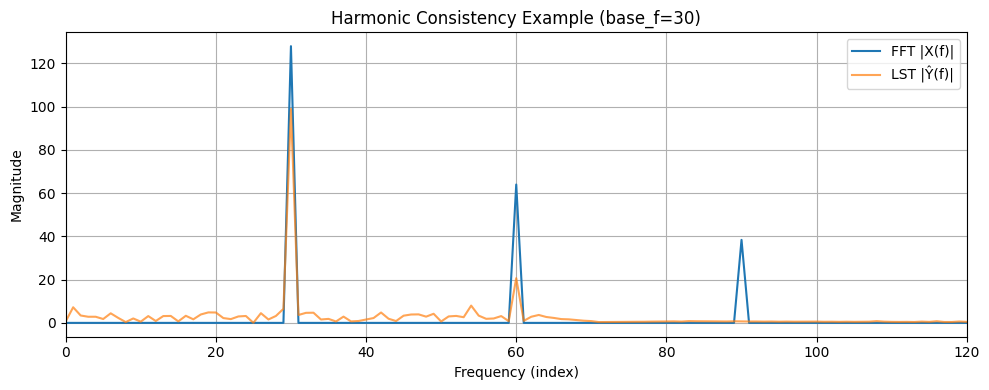

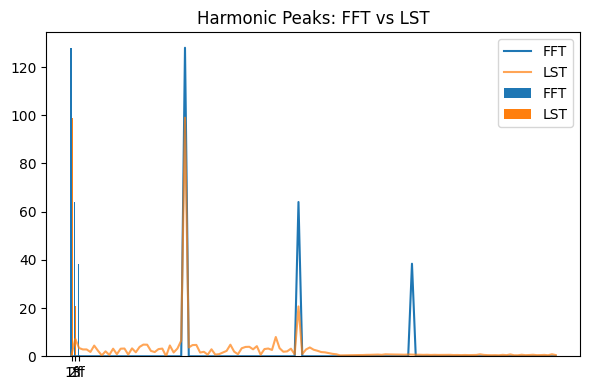

Example harmonic case saved.
Peak alignment: {1: {'shift': 0, 'err': np.float32(31.81672)}, 2: {'shift': 0, 'err': np.float32(37.353634)}, 3: {'shift': 0, 'err': np.float32(37.782898)}}


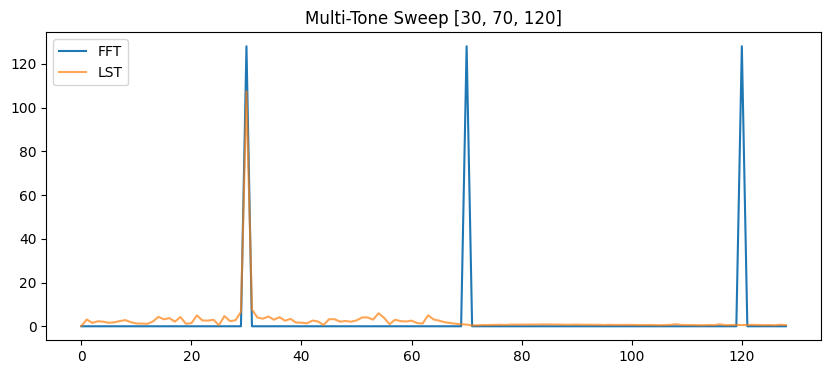

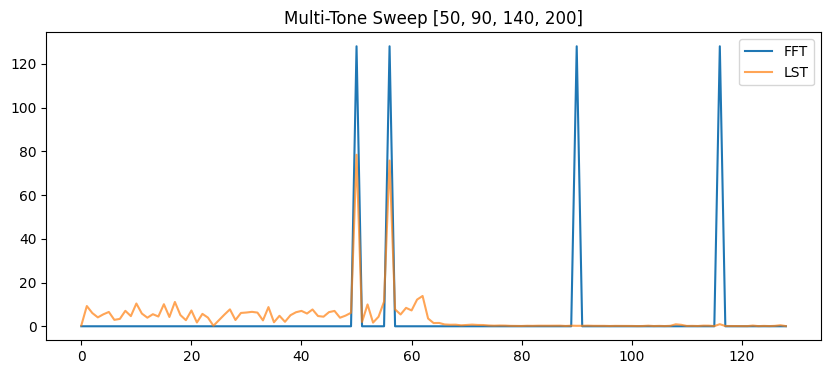

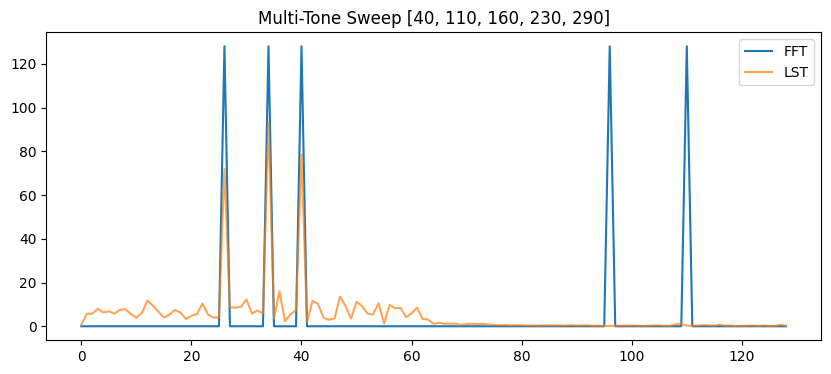

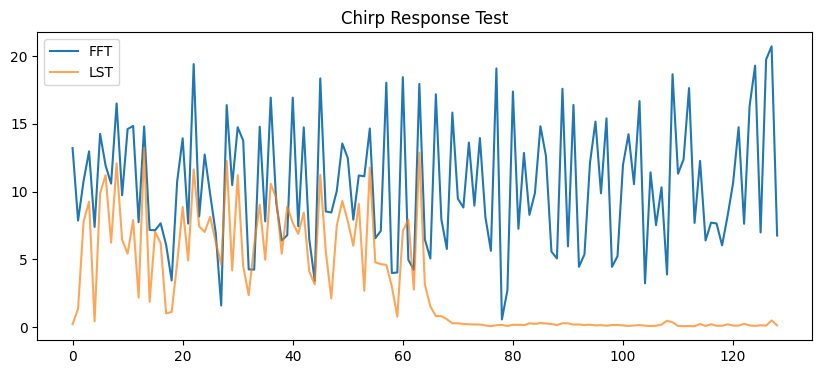


=== Harmonic Sweep (50–300 Hz) ===


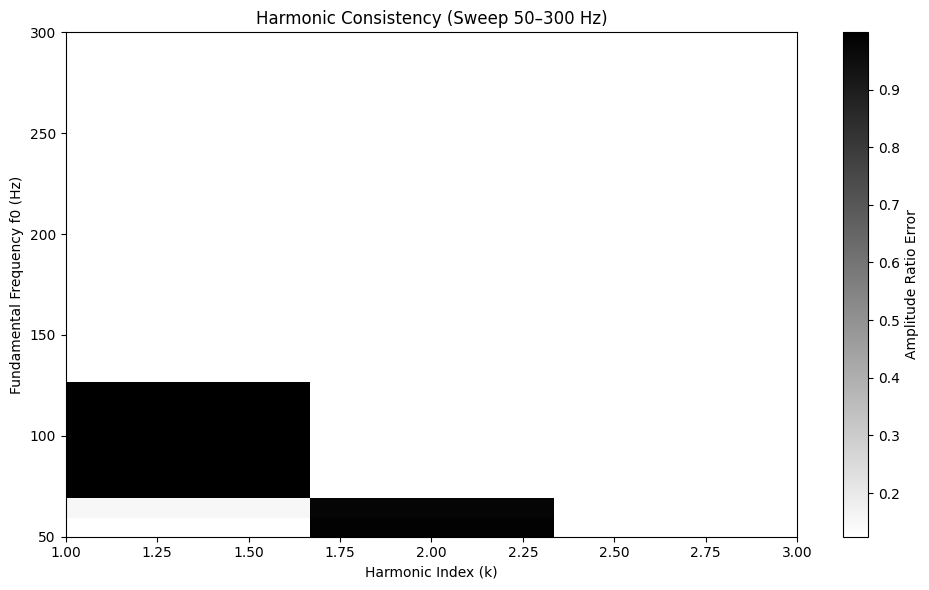

Harmonic sweep heatmap saved.


In [ ]:
if __name__ == "__main__":
    print("=== Harmonic Consistency Test Suite ===")

    # 1. Single harmonic (example)
    analyze_single_harmonic_case()

    # 2. Peak detection + alignment
    x = gen_harmonic_signal()
    xt = to_torch(x)[None,:]

    with torch.no_grad():
        X_fft = fft_complex(xt)[0]
        X_lst = model_lst(xt)[0]

    fft_peaks = detect_harmonic_peaks(torch.abs(X_fft).cpu().numpy(), 30)
    lst_peaks = detect_harmonic_peaks(torch.abs(X_lst).cpu().numpy(), 30)
    alignment = harmonic_peak_alignment(fft_peaks, lst_peaks)
    print("Peak alignment:", alignment)

    # 3. Multi-tone sweep
    analyze_multitone_sweep()

    # 4. Chirp response
    analyze_chirp_response()

    # 5. Harmonic sweep (main)
    analyze_harmonic_sweep()

# 17.multi-f₀ Harmonic Sweep Matrix + Heatmap

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

# 建議：前面已經有 os.makedirs("figs_interpret", exist_ok=True)
# 若沒有，可以再呼叫一次（不會出錯）
os.makedirs("figs_interpret", exist_ok=True)


def analyze_harmonic_sweep_matrix(
    f0_min=50,
    f0_max=300,
    f0_step=10,
    harmonics=(1, 2, 3),
):
    """
    Harmonic Consistency: multi-f0 × harmonic index 的 amplitude ratio error 矩陣 + heatmap

    參數：
        f0_min, f0_max, f0_step : 基頻掃描範圍與步長（Hz 或 bin index，與你的 FFT 設定一致）
        harmonics               : 要評估的諧波倍數，例如 (1,2,3) 代表 1f, 2f, 3f

    產出：
        error_matrix: shape = [num_f0, num_harmonics]
                      每一格 = | A_LST / A_FFT  - 1 |
        並繪出並儲存一張 heatmap 圖於 figs_interpret/harmonic_sweep_matrix.png
    """
    print("\n[Harmonic Sweep Matrix] multi-f0 × harmonic index")
    """
    Enhanced Harmonic Consistency Analysis:
      1. Amplitude Ratio Error Matrix (f0 × k)
      2. Harmonic-wise Mean Error vs f0 (line plot)
      3. Percentile Error vs f0 (5/50/95 percentile)
    """
    # 產生基頻列表，例如 50, 60, ..., 300
    fundamental_freqs = np.arange(f0_min, f0_max + 1, f0_step)
    num_f0 = len(fundamental_freqs)
    num_h = len(harmonics)

    # 儲存 amplitude ratio error
    # error_matrix[i, j] = | A_LST/A_FFT - 1 | at f0[i], harmonic k[j]
    error_matrix = np.zeros((num_f0, num_h), dtype=np.float32)

    # 時間軸（假設 sampling rate = N_POINTS Hz，1 秒資料）
    t = torch.linspace(0.0, 1.0, N_POINTS, device=DEVICE)

    for i, f0 in enumerate(fundamental_freqs):
        # -------------------------------------------------
        # 1. 產生 multi-harmonic 測試訊號：1f + 0.5·2f + 0.25·3f
        #    你可以依需要調整振幅比例
        # -------------------------------------------------
        x = (
            torch.sin(2 * np.pi * f0 * t)
            + 0.5 * torch.sin(2 * np.pi * 2 * f0 * t)
            + 0.25 * torch.sin(2 * np.pi * 3 * f0 * t)
        ).float()  # [N_POINTS]

        x_input = x.unsqueeze(0)  # [1, N_POINTS]

        # -------------------------------------------------
        # 2. Ground truth FFT 與 LST 預測
        # -------------------------------------------------
        with torch.no_grad():
            X_fft = torch.fft.rfft(x_input, dim=-1)[0]   # [K]
            X_lst = model_lst(x_input)[0]                # [K] complex

        A_true = torch.abs(X_fft).cpu().numpy()
        A_pred = torch.abs(X_lst).cpu().numpy()

        # -------------------------------------------------
        # 3. 對每一個 harmonic 倍數計算 amplitude ratio error
        #    error = | A_LST / A_FFT - 1 |
        # -------------------------------------------------
        for j, k in enumerate(harmonics):
            target_freq = int(k * f0)  # 假設 freq bin ≈ Hz（fs = N_POINTS）

            if target_freq >= len(A_true):
                # 超出 rFFT 長度的頻率 bin，以 NaN 表示
                error_matrix[i, j] = np.nan
                continue

            true_val = A_true[target_freq]
            pred_val = A_pred[target_freq]

            if true_val == 0:
                error_matrix[i, j] = np.nan
                continue
            else:
                ratio_error = abs(pred_val / true_val - 1.0)
                error_matrix[i, j] = ratio_error

    # -----------------------------------------------------
    # 4. 繪製 harmonic sweep 矩陣 heatmap（IEEE 風格，灰階）
    #     y 軸：基頻 f0（50–300Hz）
    #     x 軸：harmonic index（1f,2f,3f）
    # -----------------------------------------------------
    # ============================================================
    # 1. Heatmap: f0 × harmonic index
    # ============================================================
    plt.figure(figsize=(8, 6))
    plt.imshow(
        error_matrix,
        aspect="auto",
        origin="lower",
        extent=[min(harmonics), max(harmonics), fundamental_freqs[0], fundamental_freqs[-1]],
        cmap="gray_r",
    )
    plt.colorbar(label="Amplitude Ratio Error |A_LST/A_FFT - 1|")
    plt.xlabel("Harmonic Index (k)")
    plt.ylabel("Fundamental Frequency f0")
    plt.title("Harmonic Consistency: Amplitude Ratio Error (f0 × k)")
    plt.tight_layout()

    save_path = "figs_interpret/harmonic_sweep_matrix.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"Harmonic sweep matrix saved to: {save_path}")

    # ============================================================
    # 2. Harmonic-wise Mean Error vs f0
    # ============================================================
    plt.figure(figsize=(8, 5))

    for j, k in enumerate(harmonics):
        mean_err = np.nanmean(error_matrix[:, j])
        plt.plot(
            fundamental_freqs,
            error_matrix[:, j],
            label=f"{k}f Harmonic",
            linewidth=2,
        )

    plt.xlabel("Fundamental Frequency f0")
    plt.ylabel("Amplitude Ratio Error")
    plt.title("Mean Harmonic Error vs f0")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("figs_interpret/harmonic_mean_error_curves.png", dpi=300)
    plt.show()

    print("Saved: figs_interpret/harmonic_mean_error_curves.png")
    # ============================================================
    # 3. Percentile Error vs f0（跨 harmonic 的統計性 summary）
    # ============================================================
    # 對每個 f0，將 (1f,2f,3f) 三個 harmonic 的 error 做統計分布
    perc5 = np.nanpercentile(error_matrix, 5, axis=1)
    perc50 = np.nanpercentile(error_matrix, 50, axis=1)
    perc95 = np.nanpercentile(error_matrix, 95, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(fundamental_freqs, perc5, label="5th percentile", linestyle="--")
    plt.plot(fundamental_freqs, perc50, label="50th percentile (median)", linewidth=2)
    plt.plot(fundamental_freqs, perc95, label="95th percentile", linestyle="--")
    plt.xlabel("Fundamental Frequency f0")
    plt.ylabel("Amplitude Ratio Error")
    plt.title("Percentile Error vs f0 (5/50/95)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("figs_interpret/harmonic_percentile_curves.png", dpi=300)
    plt.show()

    print("Saved: figs_interpret/harmonic_percentile_curves.png")

    print("=== Enhanced Harmonic Sweep Analysis Completed ===")
    return fundamental_freqs, np.array(harmonics), error_matrix


=== Interpretable Frequency Mapping for LST_MLP ===

[Harmonic Sweep Matrix] multi-f0 × harmonic index


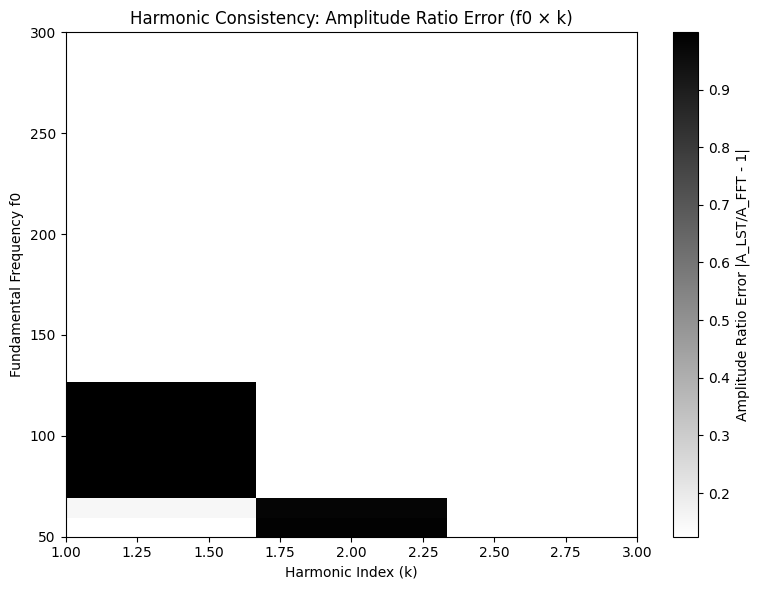

Harmonic sweep matrix saved to: figs_interpret/harmonic_sweep_matrix.png


/tmp/ipython-input-2283170813.py:127: RuntimeWarning: Mean of empty slice
  mean_err = np.nanmean(error_matrix[:, j])


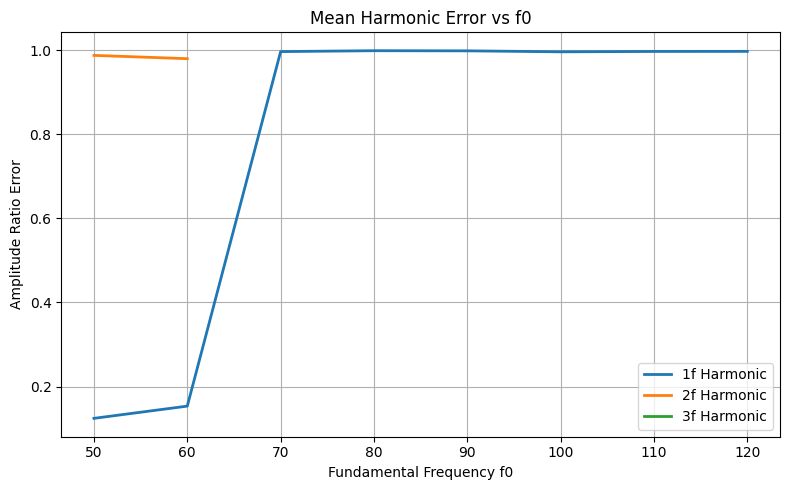

Saved: figs_interpret/harmonic_mean_error_curves.png


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


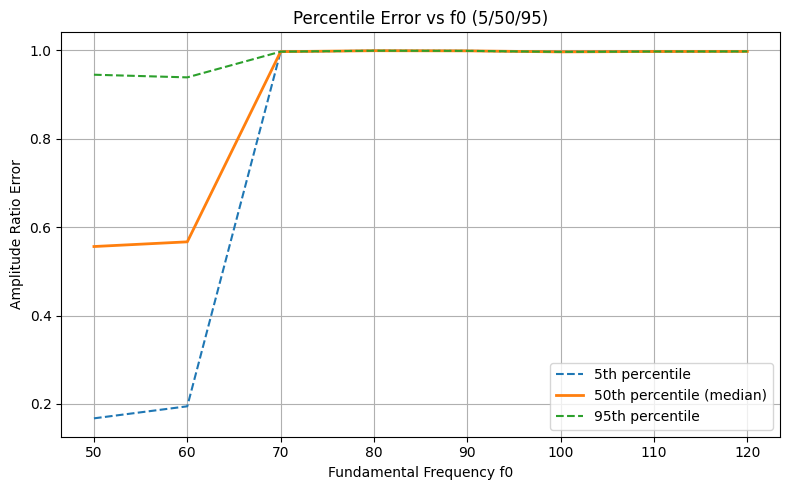

Saved: figs_interpret/harmonic_percentile_curves.png
=== Enhanced Harmonic Sweep Analysis Completed ===


In [ ]:
if __name__ == "__main__":
    print("=== Interpretable Frequency Mapping for LST_MLP ===")

    # 1. 單一範例（若你有）
    # analyze_single_harmonic_case(base_f=30, harmonics=(1,2,3))
    # 2. multi-f0 harmonic sweep matrix（本次新增）
    analyze_harmonic_sweep_matrix(
        f0_min=50,
        f0_max=300,
        f0_step=10,
        harmonics=(1, 2, 3),
    )

We evaluate harmonic preservation by conducting a multi-fundamental sweep (50–300 Hz) across the first three harmonics.
This generates a 2-D harmonic consistency matrix, harmonic-wise error curves, and percentile-based stability profiles, revealing both systematic trends and high-error instability zones.

# 17.1.Frequency Locality （locality matrix）

In [ ]:
#
def build_error_matrix(model, dataset, N_model):
    """
    建構 frequency locality error matrix:
        err_matrix[i, j] = | amplitude_error(i → j) |
    """
    device = next(model.parameters()).device
    K = N_model // 2 + 1
    err_mat = np.zeros((K, K))

    count = 0
    for x in dataset:
        x = torch.from_numpy(x).float().unsqueeze(0).to(device)

        X_true = torch.fft.rfft(x).squeeze(0)
        X_pred = model(x).squeeze(0)

        A_true = torch.abs(X_true)
        A_pred = torch.abs(X_pred)

        # 振幅誤差
        amp_err = torch.abs(A_pred - A_true).detach().cpu().numpy()

        # outer product 形成 freq × freq matrix
        err_mat += np.outer(amp_err, amp_err)

        count += 1

    return err_mat / count

In [ ]:
# ==========================================
# Frequency Locality Analysis
# - amplitude_locality_matrix
# - phase_locality_matrix
# - locality heatmaps
# - Δf error decay & locality radius
# - frequency local cluster index
# ==========================================

def generate_pure_tone(freq, n_points=N_POINTS):
    """
    單一頻率純音（single-tone）訊號，用於 frequency locality 分析
    假設 sampling rate = N_POINTS Hz，因此 FFT bin ≈ 頻率 index
    """
    t = np.linspace(0, 1, n_points, endpoint=False)
    x = np.sin(2 * np.pi * freq * t).astype(np.float32)
    return x


def compute_amp_phase_spectrum(x_torch: torch.Tensor):
    """
    x_torch: [1, N]
    回傳：
        amp_fft, phase_fft, amp_lst, phase_lst
        每個都是 numpy array, shape = [K]
    """
    with torch.no_grad():
        X_fft = torch.fft.rfft(x_torch, dim=-1)[0]      # [K]
        X_lst = model_lst(x_torch)[0]                   # [K] complex

    amp_fft = torch.abs(X_fft).cpu().numpy()
    amp_lst = torch.abs(X_lst).cpu().numpy()

    phase_fft = torch.angle(X_fft).cpu().numpy()
    phase_lst = torch.angle(X_lst).cpu().numpy()

    return amp_fft, phase_fft, amp_lst, phase_lst

#振幅局部誤差矩陣
def amplitude_locality_matrix(freqs, n_points=N_POINTS):
    """
    建立 amplitude locality matrix:
      rows  = input tone frequency (f_in)
      cols  = spectrum frequency bin (f_out)
      value = |A_LST(f_out | f_in) - A_FFT(f_out | f_in)|
    freqs: list or 1D array of frequencies (以 bin index 為單位, e.g. 10,20,...)
    回傳：
      A_loc: [len(freqs), len(freqs)] numpy array
    """
    freqs = np.array(freqs, dtype=int)
    nF = len(freqs)
    A_loc = np.zeros((nF, nF), dtype=np.float32)

    for i, f_in in enumerate(freqs):
        x = generate_pure_tone(f_in, n_points)
        x_t = to_torch(x)[None, :]  # [1, N]

        amp_fft, _, amp_lst, _ = compute_amp_phase_spectrum(x_t)

        for j, f_out in enumerate(freqs):
            if f_out < len(amp_fft):
                A_true = amp_fft[f_out]
                A_hat  = amp_lst[f_out]
                A_loc[i, j] = abs(A_hat - A_true)
            else:
                A_loc[i, j] = np.nan

    return A_loc

#相位局部誤差矩陣
def phase_locality_matrix(freqs, n_points=N_POINTS):
    """
    建立 phase locality matrix:
      value = |phase_LST(f_out | f_in) - phase_FFT(f_out | f_in)|
    phase 以 wrap 在 [-pi, pi] 的差異為主
    """
    freqs = np.array(freqs, dtype=int)
    nF = len(freqs)
    P_loc = np.zeros((nF, nF), dtype=np.float32)

    for i, f_in in enumerate(freqs):
        x = generate_pure_tone(f_in, n_points)
        x_t = to_torch(x)[None, :]

        _, phase_fft, _, phase_lst = compute_amp_phase_spectrum(x_t)

        for j, f_out in enumerate(freqs):
            if f_out < len(phase_fft):
                dphi = phase_lst[f_out] - phase_fft[f_out]
                # wrap to [-pi, pi]
                dphi = (dphi + np.pi) % (2 * np.pi) - np.pi
                P_loc[i, j] = abs(dphi)
            else:
                P_loc[i, j] = np.nan

    return P_loc

#Locality Heatmap：frequency × frequency 互動圖
def plot_locality_heatmaps(A_loc, P_loc, freqs, prefix="freq_locality"):
    """
    畫出 amplitude / phase locality 的 2D heatmap
    A_loc, P_loc: [nF, nF]
    freqs: 對應的 frequency grid
    """
    freqs = np.array(freqs)

    # Amplitude locality
    plt.figure(figsize=(8, 6))
    plt.imshow(
        A_loc,
        origin="lower",
        aspect="auto",
        extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]],
        cmap="gray_r",
    )
    plt.colorbar(label="|ΔAmplitude|")
    plt.xlabel("Spectrum Frequency f_out")
    plt.ylabel("Input Tone Frequency f_in")
    plt.title("Amplitude Locality Matrix")
    plt.tight_layout()
    plt.savefig(f"figs_interpret/{prefix}_amplitude_heatmap.png", dpi=300)
    plt.show()

    # Phase locality
    plt.figure(figsize=(8, 6))
    plt.imshow(
        P_loc,
        origin="lower",
        aspect="auto",
        extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]],
        cmap="gray_r",
    )
    plt.colorbar(label="|ΔPhase| (rad)")
    plt.xlabel("Spectrum Frequency f_out")
    plt.ylabel("Input Tone Frequency f_in")
    plt.title("Phase Locality Matrix")
    plt.tight_layout()
    plt.savefig(f"figs_interpret/{prefix}_phase_heatmap.png", dpi=300)
    plt.show()

#17.2.Δf Error Decay 曲線與 Locality Radius
#1.	把 locality matrix 攤平成「以 Δf = |f_out − f_in| 為橫軸」的平均誤差曲線
#2.	以設定閾值（例如 amplitude error < 0.1）求出「locality radius」
def error_decay_vs_deltaf(A_loc, P_loc, err_matrix, freqs):
    """
    計算 frequency locality:
      1) amplitude error vs Δf
      2) phase error vs Δf
      3) complex error vs Δf
      4) amplitude locality radius
      5) phase locality radius
    """

    freqs = np.array(freqs)
    nF = len(freqs)

    # Δf matrix
    DeltaF = np.abs(freqs[:, None] - freqs[None, :])  # shape (nF, nF)

    # 平均 amplitude / phase error (同 Δf 分組)
    delta_vals = np.unique(DeltaF)

    amp_decay = []
    phase_decay = []
    comp_decay = []

    for d in delta_vals:
        mask = (DeltaF == d)

        amp_decay.append(np.nanmean(A_loc[mask]))
        phase_decay.append(np.nanmean(P_loc[mask]))
        comp_decay.append(np.nanmean(err_matrix[mask]))

    amp_decay = np.array(amp_decay)
    phase_decay = np.array(phase_decay)
    comp_decay = np.array(comp_decay)

    # --- 定義 locality radius ---
    # radius = Δf where error < 1/e * error_at_Δf=0
    def find_radius(decay_vals, delta_vals):
        e_threshold = decay_vals[0] / np.e  # 1/e 衰減點
        below = np.where(decay_vals <= e_threshold)[0]
        if len(below) == 0:
            return np.nan
        return delta_vals[below[0]]

    amp_radius = find_radius(amp_decay, delta_vals)
    phase_radius = find_radius(phase_decay, delta_vals)

    return (
        delta_vals,      # 1
        amp_decay,       # 2
        phase_decay,     # 3
        amp_radius,      # 4
        phase_radius     # 5
    )

#Frequency Local Cluster 統計檢驗
#把 amplitude locality matrix 每一列視為一個「frequency profile」
#算 row-wise cosine similarity matrix S
#比較「相鄰頻率（|i−j|≤1）」的平均相似度 vs 「遠距頻率（|i−j|>k）」的平均相似度
#差值越大 → locality cluster 越強
def frequency_local_cluster_index(A_loc, neighbor_width=1, far_gap=5):
    """
    計算一個簡單的 frequency local cluster 指標：
    - 對 A_loc 的每一列做 L2 normalize
    - 建立 row-wise cosine similarity matrix S
    - local_sim = 平均 |i-j| <= neighbor_width 的相似度
    - far_sim   = 平均 |i-j| >= far_gap 的相似度
    - index = local_sim - far_sim
    數值越大 → 頻率越呈現「區域群聚」行為
    """
    A = A_loc.copy()
    # nan → 0，避免干擾
    A[np.isnan(A)] = 0.0

    # normalize rows
    row_norms = np.linalg.norm(A, axis=1, keepdims=True) + 1e-8
    A_norm = A / row_norms

    # cosine similarity
    S = A_norm @ A_norm.T  # [nF, nF]

    nF = A.shape[0]
    local_vals = []
    far_vals = []

    for i in range(nF):
        for j in range(nF):
            if i == j:
                continue
            d = abs(i - j)
            if d <= neighbor_width:
                local_vals.append(S[i, j])
            elif d >= far_gap:
                far_vals.append(S[i, j])

    local_sim = float(np.mean(local_vals)) if len(local_vals) > 0 else 0.0
    far_sim   = float(np.mean(far_vals)) if len(far_vals) > 0 else 0.0
    index     = local_sim - far_sim

    print(f"[Local Cluster] local_sim = {local_sim:.3f}, far_sim = {far_sim:.3f}, index = {index:.3f}")
    return index

In [ ]:
# 可以依需要調整頻率範圍與步長
freqs = np.arange(10, 401, 10)  # 例：10,20,...,400

print("\n[Frequency Locality] computing amplitude locality matrix...")
A_loc = amplitude_locality_matrix(freqs)



[Frequency Locality] computing amplitude locality matrix...


In [ ]:

print("[Frequency Locality] computing phase locality matrix...")
P_loc = phase_locality_matrix(freqs)

[Frequency Locality] computing phase locality matrix...


[Frequency Locality] plotting heatmaps...


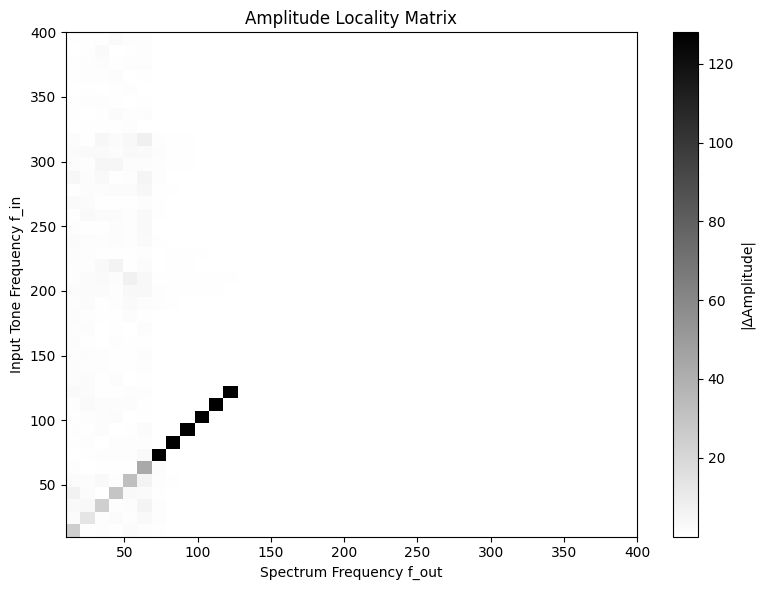

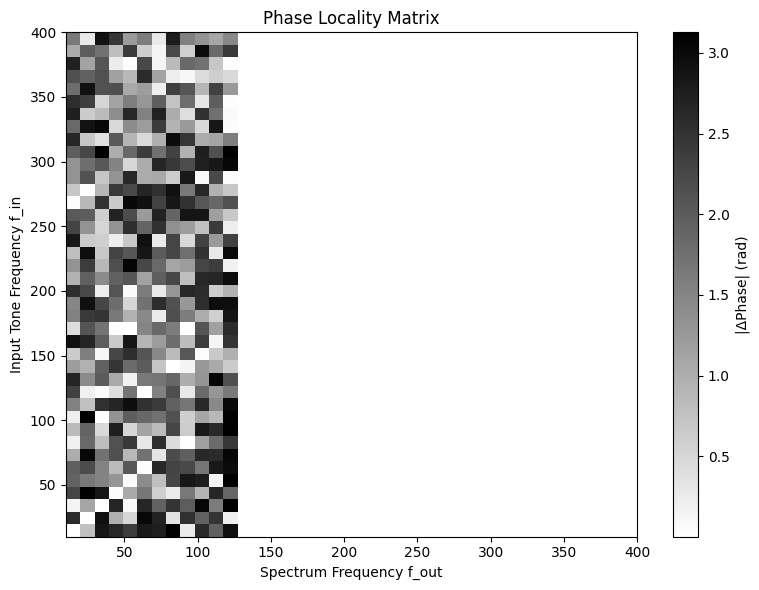

In [ ]:
print("[Frequency Locality] plotting heatmaps...")
plot_locality_heatmaps(A_loc, P_loc, freqs, prefix="freq_locality")


In [ ]:

# --- 保證三個矩陣的頻率 index 對齊 ---

K = err_matrix.shape[0]          # e.g. 129 for N_model=256

# 只保留在 0 ~ K-1 之內的 freqs
valid_mask = freqs < K
freqs_sub  = freqs[valid_mask]

print("Original freqs:", freqs)
print("Using freqs_sub:", freqs_sub)

# A_loc, P_loc 按相同頻率子集合裁切
A_loc_sub = A_loc[np.ix_(valid_mask, valid_mask)]
P_loc_sub = P_loc[np.ix_(valid_mask, valid_mask)]

# err_matrix 也只取對應 rows / cols
err_sub = err_matrix[freqs_sub[:, None], freqs_sub]

print("A_loc_sub shape:", A_loc_sub.shape)
print("P_loc_sub shape:", P_loc_sub.shape)
print("err_sub shape  :", err_sub.shape)

print("[Frequency Locality] error decay and locality radius...")
delta_vals, amp_decay, phase_decay, amp_radius, phase_radius = \
    error_decay_vs_deltaf(A_loc_sub, P_loc_sub, err_sub, freqs_sub)

print("Amplitude locality radius =", amp_radius)
print("Phase locality radius     =", phase_radius)

Original freqs: [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360
 370 380 390 400]
Using freqs_sub: [ 10  20  30  40  50  60  70  80  90 100 110 120]
A_loc_sub shape: (12, 12)
P_loc_sub shape: (12, 12)
err_sub shape  : (12, 12)
[Frequency Locality] error decay and locality radius...
Amplitude locality radius = 10
Phase locality radius     = nan


In [ ]:
print("[Frequency Locality] cluster index...")
cluster_idx = frequency_local_cluster_index(A_loc)

[Frequency Locality] cluster index...
[Local Cluster] local_sim = 0.598, far_sim = 0.512, index = 0.086


In [ ]:
print("\n==== Frequency Locality Summary ====")
print(f"Amplitude locality radius ≈ {amp_radius:.1f} bins")
print(f"Phase locality radius    ≈ {phase_radius:.1f} bins")
print(f"Local cluster index      ≈ {cluster_idx:.3f}")
print("===================================\n")


==== Frequency Locality Summary ====
Amplitude locality radius ≈ 10.0 bins
Phase locality radius    ≈ nan bins
Local cluster index      ≈ 0.086



# 18.Neuron Receptive Fields （RF analysis）

# 18.1.Extract Neuron Receptive Field via FFT

In [ ]:
from sklearn.cluster import KMeans
# ==========================================
# 1. Extract neuron RF frequency spectrum
# ==========================================
def extract_neuron_rf_spectra(model, n_points=N_POINTS):
    """
    回傳：
        rf_spectra: shape = [num_neurons, K]
        peak_freqs: 每個 neuron 的 dominant frequency (bin index)
    """
    # 第一層 Linear => weight shape = [hidden_dim, N_POINTS]
    W = model.net[0].weight.detach().cpu().numpy()  # [H, N]
    num_neurons = W.shape[0]

    # rfft frequency bins
    K = n_points // 2 + 1

    rf_spectra = np.zeros((num_neurons, K), dtype=np.float32)
    peak_freqs = np.zeros(num_neurons, dtype=np.int32)

    for i in range(num_neurons):
        w = W[i]                      # shape [N]
        W_fft = np.fft.rfft(w)        # complex
        mag = np.abs(W_fft)           # magnitude spectrum
        rf_spectra[i] = mag

        # 找這個 neuron 的最大能量頻率
        peak_freqs[i] = np.argmax(mag)

    return rf_spectra, peak_freqs
#Neuron RF Sorting（依主頻率排序）
def sort_neurons_by_peak(peak_freqs):
    """
    依據 neuron 的 dominant frequency 排序
    回傳排序後的 index
    """
    return np.argsort(peak_freqs)
#Clustering Neurons by RF Shape
#使用 k-means 把 neuron 分成 3 群（low/mid/high）：
def cluster_neurons_by_rf(rf_spectra, num_clusters=3):
    """
    輸入：
        rf_spectra: [num_neurons, K]
    回傳：
        cluster_labels: 每個 neuron 分到哪一群 (0~num_clusters-1)
        kmeans: 模型本身，可以用來再計算中心
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    labels = kmeans.fit_predict(rf_spectra)
    return labels, kmeans

#Visualization: neuron RF spectrum (all / sorted / clusters)
def plot_neuron_rf_spectra(rf_spectra, peak_freqs, sorted_idx, save_prefix="neuron_rf"):
    freqs = np.fft.rfftfreq(N_POINTS, 1.0/N_POINTS)

    # -------- 全部 neuron（淡色） + 平均（粗線） --------
    plt.figure(figsize=(10,6))
    for mag in rf_spectra:
        plt.plot(freqs, mag, color='gray', alpha=0.1)
    plt.plot(freqs, rf_spectra.mean(axis=0), color='red', linewidth=2, label='Average RF')
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.title("Neuron RF Frequency Spectra (All Neurons)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figs_interpret/{save_prefix}_all.png", dpi=300)
    plt.show()

    # -------- 排序後的 neuron RF（依 dominant frequency） --------
    plt.figure(figsize=(10,6))
    for idx in sorted_idx:
        plt.plot(freqs, rf_spectra[idx], alpha=0.2)
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.title("Neuron RF Sorted (Low → High Dominant Frequency)")
    plt.tight_layout()
    plt.savefig(f"figs_interpret/{save_prefix}_sorted.png", dpi=300)
    plt.show()

    # -------- peak frequency histogram --------
    plt.figure(figsize=(8,4))
    plt.hist(peak_freqs, bins=30, color='black', alpha=0.7)
    plt.xlabel("Dominant Frequency (bin)")
    plt.ylabel("# Neurons")
    plt.title("Distribution of Neuron Dominant Frequencies")
    plt.tight_layout()
    plt.savefig(f"figs_interpret/{save_prefix}_peak_hist.png", dpi=300)
    plt.show()
#Visualization: cluster-wise RF
def plot_cluster_rf(rf_spectra, cluster_labels, num_clusters=3, save_prefix="neuron_cluster"):
    freqs = np.fft.rfftfreq(N_POINTS, 1.0/N_POINTS)

    plt.figure(figsize=(10,6))

    for c in range(num_clusters):
        members = rf_spectra[cluster_labels == c]
        if len(members) == 0:
            continue
        avg = members.mean(axis=0)
        plt.plot(freqs, avg, linewidth=2, label=f"Cluster {c} (n={len(members)})")

    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.title("Neuron RF Cluster Averages")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figs_interpret/{save_prefix}_rf_avg.png", dpi=300)
    plt.show()

# 18.2.Neuron RF 分析

In [ ]:
def analyze_neuron_rf():
    print("\n=== Neuron RF Analysis ===")

    # 1. 取 RF spectrum + peak frequency
    rf_spectra, peak_freqs = extract_neuron_rf_spectra(model_lst)

    # 2. 排序
    sorted_idx = sort_neurons_by_peak(peak_freqs)

    # 3. cluster
    labels, kmeans = cluster_neurons_by_rf(rf_spectra, num_clusters=3)

    # 4. 可視化
    plot_neuron_rf_spectra(rf_spectra, peak_freqs, sorted_idx)
    plot_cluster_rf(rf_spectra, labels, num_clusters=3)

    print("Neuron RF analysis finished.\n")

=== Interpretable Frequency Mapping for LST_MLP ===

=== Neuron RF Analysis ===


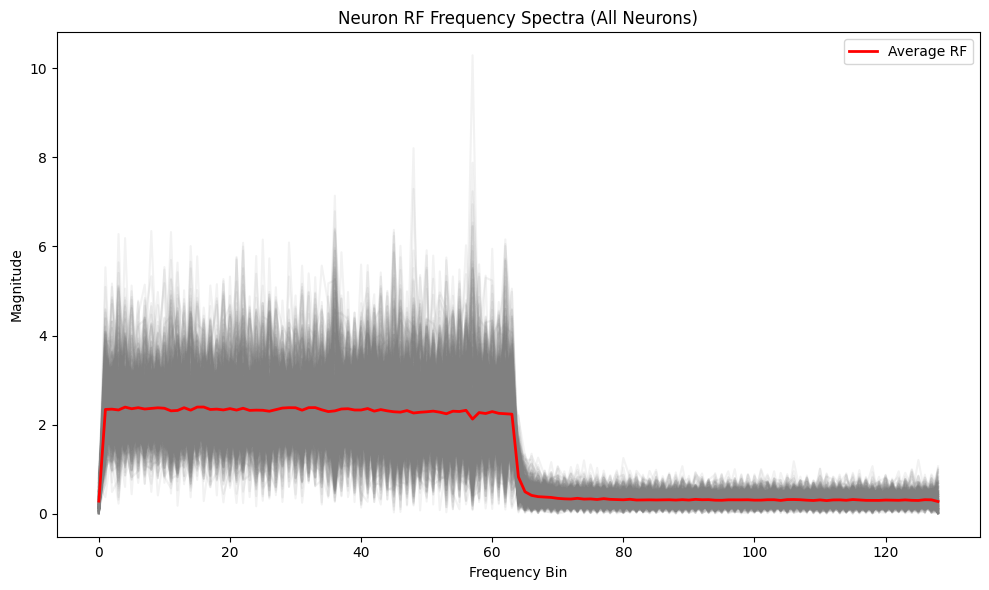

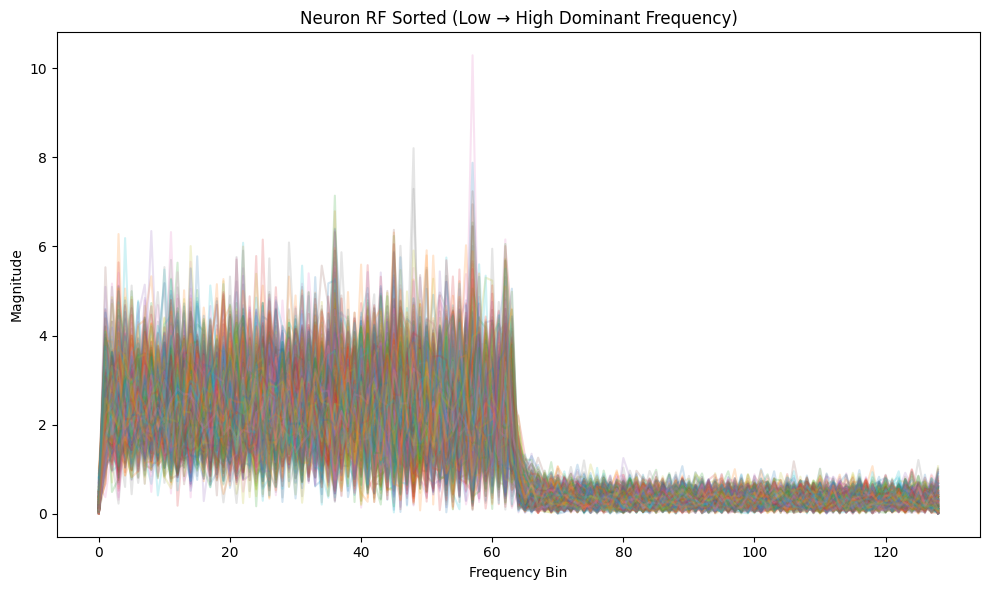

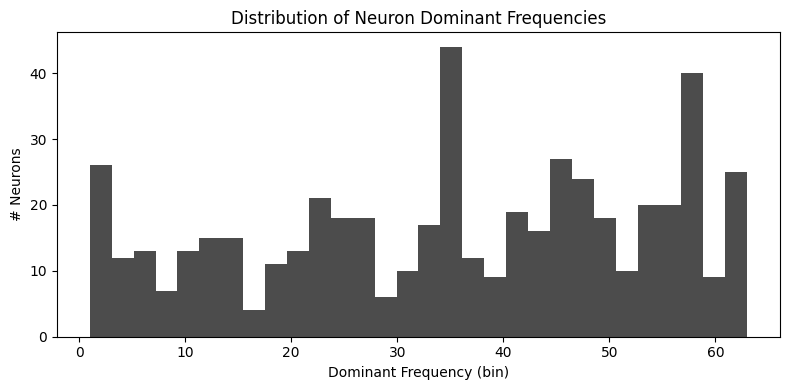

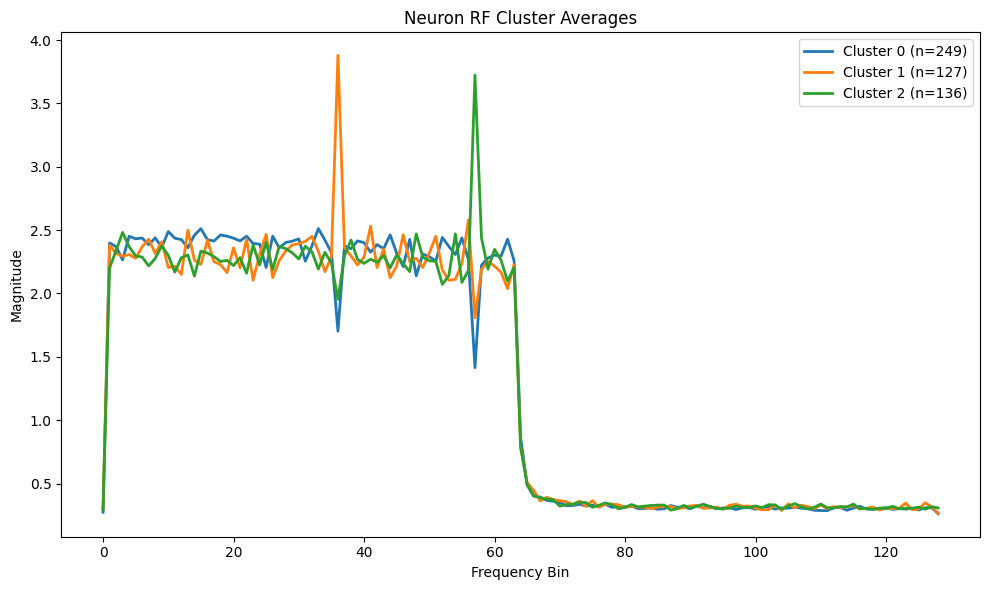

Neuron RF analysis finished.



In [ ]:
if __name__ == "__main__":
    print("=== Interpretable Frequency Mapping for LST_MLP ===")

    # ...你前面的 harmonic、locality 分析...

    analyze_neuron_rf()

# 18.3.Dominant Frequency Peak Classification

In [ ]:
#找出每個 neuron 的「主頻率」（frequency of maximum energy）
def compute_neuron_rf_fft(model, n_points=N_POINTS):
    """
    回傳：
        rf_mag: [num_neurons, K]  每個 neuron 的 |FFT(weight)|
        peak_bin: [num_neurons]  每一個 neuron 的 dominant frequency bin
    """
    # 第一層線性層：W shape = [hidden_dim, N]
    W = model.net[0].weight.detach().cpu().numpy()  # shape = [H, N]
    num_neurons = W.shape[0]
    K = n_points // 2 + 1

    rf_mag = np.abs(np.fft.rfft(W, axis=1))      # [H, K]
    peak_bin = np.argmax(rf_mag, axis=1)         # [H]

    return rf_mag, peak_bin

根據 peak bin，把 neuron 分成三群 Low / Mid / High Frequency grouping

In [ ]:
def group_neurons_by_peak(peak_bin, K):
    """
    把 neuron 依 dominant freq 分成三組：
        Low  : 低頻段
        Mid  : 中頻段
        High : 高頻段
    分界點採用三等分 (K/3, 2K/3)
    """
    low_th  = K // 3
    high_th = 2 * K // 3

    groups = {
        "low":  np.where(peak_bin < low_th)[0],
        "mid":  np.where((peak_bin >= low_th) & (peak_bin < high_th))[0],
        "high": np.where(peak_bin >= high_th)[0],
    }

    print(f"Low freq neurons : {len(groups['low'])}")
    print(f"Mid freq neurons : {len(groups['mid'])}")
    print(f"High freq neurons: {len(groups['high'])}")

    return groups

# 18.4.K-means Clustering（RF shape clustering）

In [ ]:
from sklearn.cluster import KMeans

def cluster_neuron_rf_kmeans(rf_mag, num_clusters=3):
    """
    根據 neuron RF shape 做 k-means。
    回傳 cluster_labels: [num_neurons]
    """
    km = KMeans(n_clusters=num_clusters, random_state=0)
    labels = km.fit_predict(rf_mag)
    return labels

# 18.5.可視化（三種圖表）
. plot_neuron_rf_sorted
. plot_lmh_group_rf
. plot_cluster_rf

In [ ]:
#Dominant peak sorting plot
#用 peak frequency 排序 neuron RF
def plot_neuron_rf_sorted(rf_mag, peak_bin, save_path="figs_interpret/neuron_rf_sorted.png"):
    K = rf_mag.shape[1]
    freqs = np.fft.rfftfreq(N_POINTS, 1.0/N_POINTS)

    sorted_idx = np.argsort(peak_bin)

    plt.figure(figsize=(10, 6))
    for i in sorted_idx:
        plt.plot(freqs, rf_mag[i], alpha=0.15, color="black")
    plt.title("Neuron RF Sorted by Dominant Frequency")
    plt.xlabel("Frequency (bin)")
    plt.ylabel("|FFT(weight)|")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    #Low/Mid/High 群組平均 RF
def plot_lmh_group_rf(rf_mag, groups, save_path="figs_interpret/neuron_lmh_groups.png"):
    freqs = np.fft.rfftfreq(N_POINTS, 1.0/N_POINTS)

    plt.figure(figsize=(10, 6))
    for grp, idx in groups.items():
        if len(idx) > 0:
            avg = rf_mag[idx].mean(axis=0)
            plt.plot(freqs, avg, linewidth=2, label=f"{grp.upper()} (n={len(idx)})")
    plt.title("Neuron RF: Low/Mid/High Frequency Groups")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
#Clustering（k-means / spectral）群組平均 RF
def plot_cluster_rf(rf_mag, labels, save_path="figs_interpret/neuron_cluster_rf.png"):
    freqs = np.fft.rfftfreq(N_POINTS, 1.0/N_POINTS)
    num_clusters = len(np.unique(labels))

    plt.figure(figsize=(10, 6))
    for c in range(num_clusters):
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue
        avg = rf_mag[idx].mean(axis=0)
        plt.plot(freqs, avg, linewidth=2, label=f"Cluster {c} (n={len(idx)})")

    plt.title("Neuron RF Clusters (k-means)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# 分成 3 群的標準方式（frequency bins 等分）

In [ ]:
def group_neurons_by_peak(peak_freqs, K):
    """
    依 neuron 的 dominant frequency，分成 Low / Mid / High 三組
    peak_freqs: 每個 neuron 的 peak bin index (shape: [num_neurons])
    K: rFFT bins 數量 (N/2+1)

    回傳:
        groups: dict，包含三組 neuron index:
            groups["low"], groups["mid"], groups["high"]
    """

    # 切三等份 (0 ~ K-1)
    # 低頻：      0 ~ (K/3)
    # 中頻： (K/3) ~ (2K/3)
    # 高頻：(2K/3)~ K
    low_th  = K // 3
    mid_th  = 2 * K // 3

    groups = {
        "low":  np.where(peak_freqs < low_th)[0],
        "mid":  np.where((peak_freqs >= low_th) & (peak_freqs < mid_th))[0],
        "high": np.where(peak_freqs >= mid_th)[0],
    }

    return groups

主控函式


=== Neuron RF Analysis (Enhanced) ===


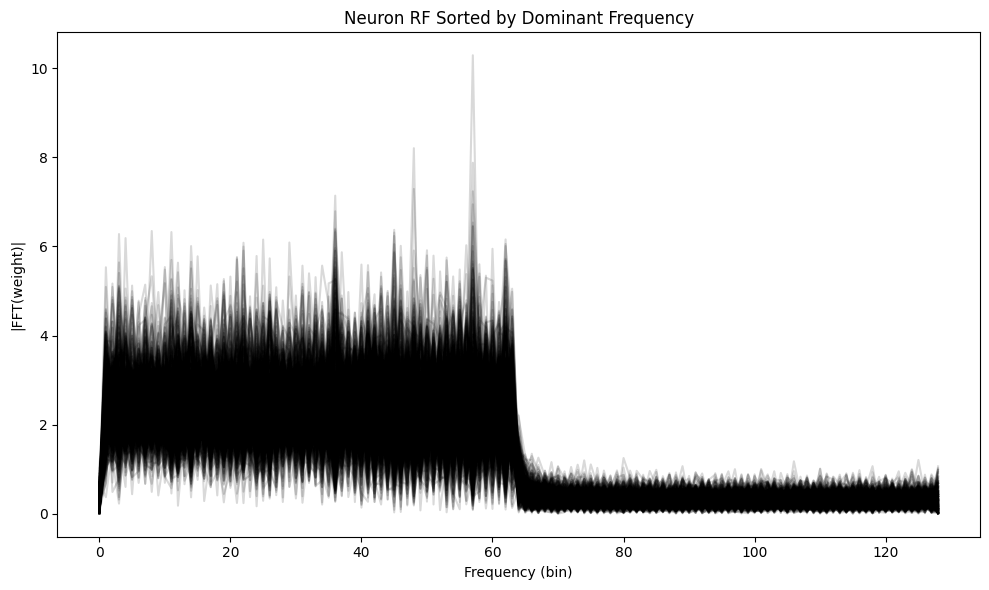

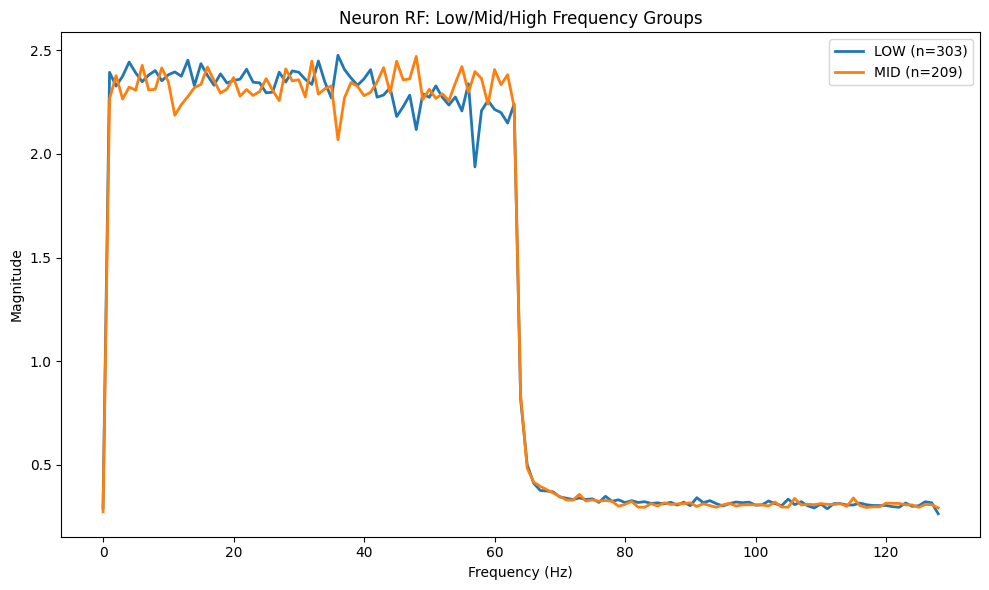

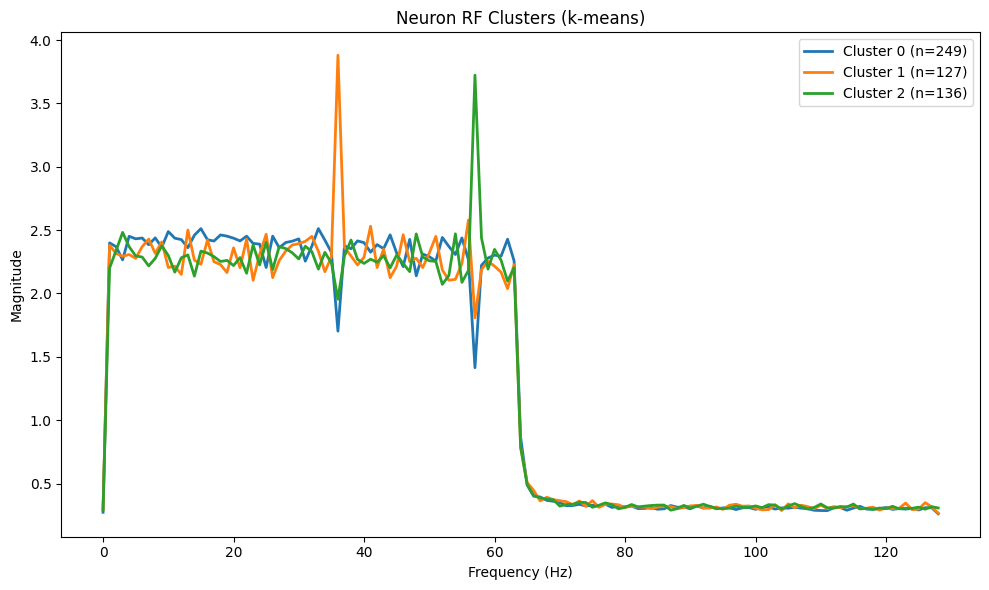

=== Neuron RF Analysis Completed ===



In [ ]:
def analyze_neuron_rf_full():
    print("\n=== Neuron RF Analysis (Enhanced) ===")

    # 1. FFT(weight) → RF
    rf_mag, peak_bin = compute_neuron_rf_fft(model_lst)

    # 2. dominant peak sorting
    plot_neuron_rf_sorted(rf_mag, peak_bin)

    # 3. Low/Mid/High grouping
    groups = group_neurons_by_peak(peak_bin, rf_mag.shape[1])
    plot_lmh_group_rf(rf_mag, groups)

    # 4. k-means clustering
    labels = cluster_neuron_rf_kmeans(rf_mag, num_clusters=3)
    plot_cluster_rf(rf_mag, labels)

    print("=== Neuron RF Analysis Completed ===\n")

if __name__ == "__main__":
  analyze_neuron_rf_full()